<a href="https://colab.research.google.com/github/leosammallahti/colabstuff/blob/main/Mozi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================
# 0) Setup & Installs
# =========================
!pip -q install gspread google-auth google-auth-oauthlib google-auth-httplib2
!pip -q install pandas numpy tqdm
!pip -q install sentence-transformers faiss-cpu

# (Optional) For topic modeling later
# !pip -q install bertopic umap-learn hdbscan

# =========================
# 1) Auth & Load Google Sheet
# =========================
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

import pandas as pd
import numpy as np

SHEET_TITLE = "Mozi_corrected"  # exact sheet name
WORKSHEET_NAME = None           # None = first worksheet; set to name if you prefer
RANGE_A1 = "A1:F591"            # as provided

def load_sheet_to_df(sheet_title=SHEET_TITLE, worksheet_name=WORKSHEET_NAME, a1_range=RANGE_A1):
    """
    Opens a Google Sheet and loads the specified A1 range into a pandas DataFrame.
    Robust to ragged rows: pads/truncates rows to header length.
    """
    try:
        sh = gc.open(sheet_title)
    except Exception as e:
        print("Couldn't open by title. If this fails, paste the full Google Sheets URL when prompted next.")
        print("Error:", e)
        url = input("Paste Google Sheets URL (the doc that contains 'Mozi_corrected'): ").strip()
        sh = gc.open_by_url(url)

    ws = sh.worksheet(worksheet_name) if worksheet_name else sh.sheet1
    values = ws.get(a1_range)  # returns list of lists; rows can be ragged
    if not values or len(values) < 2:
        raise ValueError(f"No data (or only header) returned for range {a1_range}. Check the range.")

    header = [h.strip() for h in values[0]]
    H = len(header)

    # Diagnose ragged rows
    bad_short, bad_long = [], []
    for i, row in enumerate(values[1:], start=2):  # 1-based + header -> start=2
        if len(row) < H:
            bad_short.append((i, len(row)))
        elif len(row) > H:
            bad_long.append((i, len(row)))

    if bad_short or bad_long:
        print(f"[INFO] Header has {H} columns: {header}")
        if bad_short:
            print(f"[WARN] {len(bad_short)} rows shorter than header (showing up to 5): {bad_short[:5]}")
        if bad_long:
            print(f"[WARN] {len(bad_long)} rows longer than header (showing up to 5): {bad_long[:5]}")

    # Normalize rows: pad with empty strings or truncate to match header length
    norm_rows = []
    for row in values[1:]:
        if len(row) < H:
            row = row + [""] * (H - len(row))
        elif len(row) > H:
            row = row[:H]
        norm_rows.append(row)

    df = pd.DataFrame(norm_rows, columns=header)

    # (Optional) ensure expected columns exist, even if empty
    for col in ["Chapter", "Verse", "Text", "Translator_Note", "Text_Clean", "Translator_Note_Clean"]:
      if col not in df.columns:
          df[col] = ""
    return df

df = load_sheet_to_df()
print("Loaded DataFrame shape:", df.shape)
print("Columns:", list(df.columns))

# =========================
# 2) Quick Sanity Checks / EDA
# =========================
# Standardize expected columns (just in case of whitespace)
df.columns = [c.strip() for c in df.columns]

expected_cols = [
    "Chapter", "Verse", "Text", "Translator_Note", "Text_Clean", "Translator_Note_Clean"
]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    print("WARNING: Missing expected columns:", missing)

# Clean up basic types
for col in ["Chapter", "Verse"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Basic summary
print("\n=== Basic Summary ===")
if "Chapter" in df.columns:
    print("Chapters count:", df["Chapter"].nunique())
if "Verse" in df.columns:
    print("Verses count (non-null):", df["Verse"].notna().sum())
if "Translator_Note" in df.columns:
    blank_notes = (df["Translator_Note"].astype(str).str.strip() == "").sum()
    print("Blank translator notes:", blank_notes)

# Length diagnostics
text_col = "Text_Clean" if "Text_Clean" in df.columns else "Text"
if text_col in df.columns:
    lens = df[text_col].fillna("").astype(str).str.len()
    print("Avg verse length:", lens.mean().round(1))
    print("Median verse length:", lens.median())
    print("Max verse length:", lens.max())

# Drop fully empty rows in the text column (rare but safe)
df = df[df[text_col].fillna("").astype(str).str.strip() != ""].reset_index(drop=True)

# =========================
# 3) Build Embeddings + FAISS (Semantic Search)
# =========================
from sentence_transformers import SentenceTransformer
import faiss
from tqdm import tqdm

# You can upgrade to a philosophy-specific model later; start fast & small here:
EMBED_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(EMBED_MODEL)

# Prepare corpus (we’ll search over verses)
corpus_texts = df[text_col].astype(str).tolist()

# Compute embeddings
batch_size = 128
emb_list = []
for i in tqdm(range(0, len(corpus_texts), batch_size), desc="Embedding"):
    batch = corpus_texts[i:i+batch_size]
    emb = embedder.encode(batch, show_progress_bar=False, normalize_embeddings=True)
    emb_list.append(emb)
embeddings = np.vstack(emb_list).astype("float32")

# Build FAISS index (cosine similarity via inner product on normalized vectors)
index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(embeddings)
print("FAISS index built. Vectors:", index.ntotal)

# =========================
# 4) Simple Search Helper
# =========================
def search_verses(query, top_k=5):
    """
    Returns top_k most similar verses to the query using the FAISS index.
    """
    q_emb = embedder.encode([query], normalize_embeddings=True).astype("float32")
    scores, idxs = index.search(q_emb, top_k)
    idxs = idxs[0].tolist()
    scores = scores[0].tolist()

    results = []
    for rank, (i, s) in enumerate(zip(idxs, scores), start=1):
        row = df.iloc[i].to_dict()
        row["_rank"] = rank
        row["_score"] = float(s)
        row["_text_col"] = row.get(text_col, "")
        results.append(row)
    return pd.DataFrame(results)

# Quick smoke test queries (you can edit these)
test_queries = [
    "filial piety",
    "benefit the people",
    "Heaven's will",
]

for q in test_queries:
    print(f"\n=== Query: {q} ===")
    display(search_verses(q, top_k=5)[["_rank","_score","Chapter","Verse","_text_col"]])

# =========================
# 5) Optional: Topic Modeling with BERTopic (Run later if you like)
# =========================
# If you enabled the installs above, uncomment this section to try themes.
# from bertopic import BERTopic
# topic_model = BERTopic(verbose=True)
# topics, probs = topic_model.fit_transform(corpus_texts, embeddings=embeddings)
# topic_info = topic_model.get_topic_info()
# display(topic_info.head(15))
# # To inspect a specific topic:
# # display(pd.DataFrame(topic_model.get_topic(0), columns=["term", "weight"]).head(20))

# =========================
# 6) (Optional) Save outputs to Drive
# =========================
# Uncomment if you want a CSV of embeddings' metadata + text for later use.
# out = df.copy()
# out["embed_dim"] = embeddings.shape[1]
# out.to_csv("/content/mozi_metadata.csv", index=False)
# print("Saved /content/mozi_metadata.csv")

[INFO] Header has 6 columns: ['Chapter', 'Verse', 'Text', 'Translator_Note', 'Text_Clean', 'Translator_Note_Clean']
[WARN] 590 rows shorter than header (showing up to 5): [(2, 5), (3, 5), (4, 5), (5, 5), (6, 5)]
Loaded DataFrame shape: (590, 6)
Columns: ['Chapter', 'Verse', 'Text', 'Translator_Note', 'Text_Clean', 'Translator_Note_Clean']

=== Basic Summary ===
Chapters count: 49
Verses count (non-null): 590
Blank translator notes: 590
Avg verse length: 1328.7
Median verse length: 1034.0
Max verse length: 48834


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding: 100%|██████████| 5/5 [01:03<00:00, 12.78s/it]

FAISS index built. Vectors: 590

=== Query: filial piety ===


,_rank,_score,Chapter,Verse,_text_col
0,1,0.407958,39,2,"[When a Confucian] takes a wife, he goes to me..."
1,2,0.325172,39,7,[Confucians] alsosay: ‘Whenthenoblemantriumphs...
2,3,0.292884,25,15,‘Tothesouthof ChuthereisthecountryoftheYanpeop...
3,4,0.291061,25,1,"Master Mospoke, saying: ‘A man who is ren (lov..."
4,5,0.286772,25,6,"‘Ifthewishistoincreasethenumberofpeople,isthis..."



=== Query: benefit the people ===


,_rank,_score,Chapter,Verse,_text_col
0,1,0.459970,16,4,Now if we are seeking to promote the world’s b...
1,2,0.456320,15,1,"Master Mospoke, saying: ‘The way in which the ..."
2,3,0.452481,71,5,"In protecting the people, first consider the s..."
3,4,0.426104,44,12,Intention and outcome may not follow each othe...
4,5,0.422715,32,1,"Master Mospoke, saying: ‘The business of those..."



=== Query: Heaven's will ===


,_rank,_score,Chapter,Verse,_text_col
0,1,0.517336,4,4,"Nowadays all the countries under Heaven, wheth..."
1,2,0.493213,27,2,"Nowadays, the people of the world say: ‘We cer..."
2,3,0.485622,28,4,‘Now the world’s officers and noblemen all cle...
3,4,0.476952,26,2,"‘This being so, what does Heaven desire and wh..."
4,5,0.472821,4,3,"This being so, what can be taken as a standard..."


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

base_folder = "/content/drive/MyDrive/Chinese Philosophy/Mozi"
os.makedirs(base_folder, exist_ok=True)
print("Created/verified:", base_folder)


Mounted at /content/drive
Created/verified: /content/drive/MyDrive/Chinese Philosophy/Mozi


In [ ]:
# Assumes `df` already exists from your loader
KEEP = ["Chapter","Verse","Text","Translator_Note","Text_Clean","Translator_Note_Clean"]
clean_path = os.path.join(BASE_FOLDER, "mozi_clean.csv")
df[KEEP].copy().to_csv(clean_path, index=False)
print("Saved:", clean_path)

counts_path = os.path.join(BASE_FOLDER, "mozi_rows_by_chapter.csv")
df.groupby("Chapter").size().rename("rows").to_frame().to_csv(counts_path)
print("Saved:", counts_path)


NameError: name 'BASE_FOLDER' is not defined

In [ ]:
# One-shot fix + save
from google.colab import drive
import os
import pandas as pd

# 1) Mount Drive (idempotent)
try:
    drive.mount('/content/drive')
except Exception:
    pass

# 2) Define/create the target folder
BASE_FOLDER = "/content/drive/MyDrive/Chinese Philosophy/Mozi"
os.makedirs(BASE_FOLDER, exist_ok=True)
print("Created/verified:", BASE_FOLDER)

# 3) Make sure df exists
if "df" not in globals():
    raise RuntimeError("DataFrame `df` not found. Run the sheet loader cell first to create `df`.")

# 4) Save files
KEEP = ["Chapter","Verse","Text","Translator_Note","Text_Clean","Translator_Note_Clean"]
clean_path = os.path.join(BASE_FOLDER, "mozi_clean.csv")
df[KEEP].copy().to_csv(clean_path, index=False)
print("Saved:", clean_path)

counts_path = os.path.join(BASE_FOLDER, "mozi_rows_by_chapter.csv")
df.groupby("Chapter").size().rename("rows").to_frame().to_csv(counts_path)
print("Saved:", counts_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created/verified: /content/drive/MyDrive/Chinese Philosophy/Mozi
Saved: /content/drive/MyDrive/Chinese Philosophy/Mozi/mozi_clean.csv
Saved: /content/drive/MyDrive/Chinese Philosophy/Mozi/mozi_rows_by_chapter.csv


In [ ]:
# Assumes `df` already exists from your loader
KEEP = ["Chapter","Verse","Text","Translator_Note","Text_Clean","Translator_Note_Clean"]
clean_path = os.path.join(BASE_FOLDER, "mozi_clean.csv")
df[KEEP].copy().to_csv(clean_path, index=False)
print("Saved:", clean_path)

counts_path = os.path.join(BASE_FOLDER, "mozi_rows_by_chapter.csv")
df.groupby("Chapter").size().rename("rows").to_frame().to_csv(counts_path)
print("Saved:", counts_path)


Saved: /content/drive/MyDrive/Chinese Philosophy/Mozi/mozi_clean.csv
Saved: /content/drive/MyDrive/Chinese Philosophy/Mozi/mozi_rows_by_chapter.csv


In [ ]:
import re
import pandas as pd

def kwic(keyword: str, window: int = 40, use_clean=True, max_hits=200):
    col = "Text_Clean" if use_clean and "Text_Clean" in df.columns else "Text"
    patt = re.compile(re.escape(keyword), flags=re.IGNORECASE)
    rows = []
    texts = df[col].fillna("").astype(str).tolist()
    for i, s in enumerate(texts):
        for m in patt.finditer(s):
            start = max(0, m.start()-window); end = min(len(s), m.end()+window)
            rows.append({
                "Chapter": int(df.loc[i, "Chapter"]) if pd.notna(df.loc[i,"Chapter"]) else None,
                "Verse": int(df.loc[i, "Verse"]) if pd.notna(df.loc[i,"Verse"]) else None,
                "Left": s[start:m.start()],
                "Hit": s[m.start():m.end()],
                "Right": s[m.end():end],
                "Full": s
            })
            if len(rows) >= max_hits:
                break
        if len(rows) >= max_hits:
            break
    return pd.DataFrame(rows)

# Example run + save
kw = "Heaven"
kwic_df = kwic(kw, window=50, max_hits=200)
kwic_path = os.path.join(BASE_FOLDER, f"kwic_{kw.replace(' ','_').lower()}.csv")
kwic_df.to_csv(kwic_path, index=False)
print(f"KWIC saved: {kwic_path} ({len(kwic_df)} hits)")
kwic_df.head(10)


KWIC saved: /content/drive/MyDrive/Chinese Philosophy/Mozi/kwic_heaven.csv (200 hits)


,Chapter,Verse,Left,Hit,Right,Full
0,1,3,hey themselves were slain and they lost all un...,Heaven,". Therefore, it is said that making a gift of ...",I have heard this said: ‘It isn’t that there i...
1,1,6,,Heaven,and earth are not perpetually refulgent; grea...,Heaven and earth are not perpetually refulgent...
2,3,2,kings was fitting; therefore they ruled all un...,Heaven,", they were established as Sons of Heaven (emp...",This doesn’t only apply to the dyeing of silk....
3,3,2,"ll under Heaven, they were established as Sons...",Heaven,(emperors) and their achievements and fame ex...,This doesn’t only apply to the dyeing of silk....
4,3,2,d their achievements and fame extended through...,Heaven,and earth. When the topic of men illustrious ...,This doesn’t only apply to the dyeing of silk....
5,4,3,order? It is said that there is no standard l...,Heaven,. Heaven is broad and unselfish in its actions...,"This being so, what can be taken as a standard..."
6,4,3,It is said that there is no standard like Heav...,Heaven,"is broad and unselfish in its actions, and ac...","This being so, what can be taken as a standard..."
7,4,3,"refore, the sage kings made it their standard....",Heaven,"is taken as the standard, then all one’s acti...","This being so, what can be taken as a standard..."
8,4,3,", then all one’s actions must be measured agai...",Heaven,. What Heaven desires should be done; what it ...,"This being so, what can be taken as a standard..."
9,4,3,e’s actions must be measured against Heaven. W...,Heaven,desires should be done; what it does not desi...,"This being so, what can be taken as a standard..."


In [ ]:
import pandas as pd

def batch_search(queries, top_k=7, out_name="mozi_batch_search.csv"):
    all_rows = []
    for q in queries:
        res = search_verses(q, top_k=top_k).copy()
        res.insert(0, "query", q)
        all_rows.append(res)
    out = pd.concat(all_rows, ignore_index=True)
    keep = ["query","_rank","_score","Chapter","Verse"]
    txt = "Text_Clean" if "Text_Clean" in out.columns else "Text"
    for c in [txt, "Text", "Translator_Note"]:
        if c in out.columns: keep.append(c)
    out_path = os.path.join(BASE_FOLDER, out_name)
    out[keep].to_csv(out_path, index=False)
    print(f"Saved: {out_path}  (rows={len(out)})")
    return out[keep]

queries = [
    "benefit the people",
    "filial piety",
    "Heaven's intention",
    "against fatalism",
    "universal love",
]
batch_search(queries, top_k=7, out_name="mozi_batch_search.csv").head(10)


Saved: /content/drive/MyDrive/Chinese Philosophy/Mozi/mozi_batch_search.csv  (rows=35)


,query,_rank,_score,Chapter,Verse,Text_Clean,Text,Translator_Note
0,benefit the people,1,0.459970,16,4,Now if we are seeking to promote the world’s b...,Now if we are seeking to promote the world’s b...,
1,benefit the people,2,0.456320,15,1,"Master Mospoke, saying: ‘The way in which the ...","Master Mo spoke, saying: ‘The way in which the...",
2,benefit the people,3,0.452481,71,5,"In protecting the people, first consider the s...","In protecting the people, first consider the s...",
3,benefit the people,4,0.426104,44,12,Intention and outcome may not follow each othe...,Intention and outcome may not follow each othe...,
4,benefit the people,5,0.422715,32,1,"Master Mospoke, saying: ‘The business of those...","Master Mo spoke, saying: ‘The business of thos...",
5,benefit the people,6,0.390281,20,3,"Nowadays, those who conduct government in the ...","Nowadays, those who conduct government in the\...",
6,benefit the people,7,0.368202,44,10,Everywhere study the love of people. The love ...,Everywhere study the love of people. The love ...,
7,filial piety,1,0.407958,39,2,"[When a Confucian] takes a wife, he goes to me...","[When a Confucian] takes a wife, he goes to me...",
8,filial piety,2,0.325172,39,7,[Confucians] alsosay: ‘Whenthenoblemantriumphs...,[Confucians] also say: ‘When the noble man tri...,
9,filial piety,3,0.292884,25,15,‘Tothesouthof ChuthereisthecountryoftheYanpeop...,‘To the south of Chu there is the country of t...,


In [ ]:
# Install once:
!pip -q install bertopic umap-learn hdbscan

from bertopic import BERTopic
import pandas as pd

# Use precomputed `embeddings` from your current session for better/faster topics
texts = df[text_col].astype(str).tolist()
topic_model = BERTopic(verbose=False)
topics, probs = topic_model.fit_transform(texts, embeddings=embeddings)

topic_info = topic_model.get_topic_info()
topic_info_path = os.path.join(BASE_FOLDER, "mozi_topics_overview.csv")
topic_info.to_csv(topic_info_path, index=False)
print("Saved:", topic_info_path)

assignments = df[["Chapter","Verse"]].copy()
assignments["topic_id"] = topics
assignments_path = os.path.join(BASE_FOLDER, "mozi_topics_assignments.csv")
assignments.to_csv(assignments_path, index=False)
print("Saved:", assignments_path)

# Optional: dump top terms for first N topics
N = min(15, len(topic_info))
rows = []
for i in range(N):
    t_id = topic_info.iloc[i]["Topic"]
    terms = topic_model.get_topic(t_id) or []
    for term, weight in terms[:15]:
        rows.append({"topic_id": t_id, "term": term, "weight": weight})
top_terms = pd.DataFrame(rows)
terms_path = os.path.join(BASE_FOLDER, "mozi_topics_top_terms.csv")
top_terms.to_csv(terms_path, index=False)
print("Saved:", terms_path)

topic_info.head(10)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 11.5 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Saved: /content/drive/MyDrive/Chinese Philosophy/Mozi/mozi_topics_overview.csv
Saved: /content/drive/MyDrive/Chinese Philosophy/Mozi/mozi_topics_assignments.csv
Saved: /content/drive/MyDrive/Chinese Philosophy/Mozi/mozi_topics_top_terms.csv


,Topic,Count,Name,Representation,Representative_Docs
0,0,417,0_the_and_is_of,"[the, and, is, of, to, in, not, it, this, be]",[(‘killing a robber is not killing a person’)\...
1,1,124,1_the_and_to_of,"[the, and, to, of, should, are, be, wall, in, ...",[The top of the wall should be 3 to 4 bu wide ...
2,2,49,2_master_chi_yi_gongshu,"[master, chi, yi, gongshu, mosaid, ren, saying...",[Iftheenemymakestunnelsandapproachesthroughthe...


In [ ]:
# Silence those SyntaxWarnings (optional)
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

# Better vectorizer for philosophical English
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from bertopic import BERTopic
import os, pandas as pd

# 1) Build a stopword list that removes glue words + Mozi-specific filler
custom_sw = set(ENGLISH_STOP_WORDS) | {
    "the","and","of","to","in","is","it","this","that","be","as","are","was","were",
    "not","so","one","all","there","their","them","what","when","then",
    # domain fillers you may want to hide
    "mozi","master","said","therefore","thus","hence","people","men"
}

# 2) Vectorizer: allow unigrams & bigrams, filter very common & very rare terms
vectorizer_model = CountVectorizer(
    lowercase=True,
    stop_words=list(custom_sw),
    ngram_range=(1,2),
    min_df=3,        # ignore terms that appear in <3 verses
    max_df=0.90      # ignore terms that appear in >90% of verses
)

# 3) Fit BERTopic using your precomputed embeddings for speed/quality
texts = df[text_col].astype(str).tolist()

topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    top_n_words=12,     # clearer topic labels
    min_topic_size=15,  # avoid micro-topics; tweak (10–30) as you like
    nr_topics="auto",   # let it merge similar topics
    verbose=False
)

topics, probs = topic_model.fit_transform(texts, embeddings=embeddings)

# 4) Save improved outputs to your Drive folder
topic_info = topic_model.get_topic_info()
topic_info_path = os.path.join(BASE_FOLDER, "mozi_topics_overview_refined.csv")
topic_info.to_csv(topic_info_path, index=False)

assignments = df[["Chapter","Verse"]].copy()
assignments["topic_id"] = topics
assignments_path = os.path.join(BASE_FOLDER, "mozi_topics_assignments_refined.csv")
assignments.to_csv(assignments_path, index=False)

# Export top terms per topic
rows = []
for t_id in topic_info["Topic"].tolist():
    terms = topic_model.get_topic(t_id) or []
    for term, weight in terms[:15]:
        rows.append({"topic_id": t_id, "term": term, "weight": weight})
top_terms = pd.DataFrame(rows)
terms_path = os.path.join(BASE_FOLDER, "mozi_topics_top_terms_refined.csv")
top_terms.to_csv(terms_path, index=False)

print("Saved:")
print(" ", topic_info_path)
print(" ", assignments_path)
print(" ", terms_path)

# Peek the first real topic (skip -1 which is 'outliers')
topic_info.head(10)


ValueError: max_df corresponds to < documents than min_df

In [ ]:
# --- Adaptive BERTopic refinement (handles small corpora) ---
import warnings, os, pandas as pd
warnings.filterwarnings("ignore", category=SyntaxWarning)

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from bertopic import BERTopic

# 0) Build/clean corpus
texts = (
    df[text_col]
    .astype(str)
    .map(lambda s: s.strip())
    .replace({"nan": ""})
    .tolist()
)
# Remove empties and (optionally) duplicates
texts = [t for t in texts if t]
# (Optional) de-dup: uncomment if many exact repeats
# texts = list(dict.fromkeys(texts))

N = len(texts)
print(f"Docs for BERTopic: {N}")
if N < 5:
    raise ValueError("Too few documents for topic modeling. Use more verses or skip BERTopic.")

# 1) Adaptive df thresholds
# Keep proportional thresholds to avoid min_df > max_df
min_df_prop = max(2 / N, 0.002)   # at least ~2 docs or 0.2%
max_df_prop = 0.9                 # drop super-common terms
if max_df_prop <= min_df_prop:    # safety: widen if tiny corpus
    max_df_prop = min(0.99, min_df_prop + 0.05)

# 2) Stopwords (tune as needed)
custom_sw = set(ENGLISH_STOP_WORDS) | {
    "the","and","of","to","in","is","it","this","that","be","as","are","was","were",
    "not","so","one","all","there","their","them","what","when","then",
    "mozi","master","said","therefore","thus","hence","people","men"
}

vectorizer_model = CountVectorizer(
    lowercase=True,
    stop_words=list(custom_sw),
    ngram_range=(1,2),
    min_df=min_df_prop,
    max_df=max_df_prop
)

topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    top_n_words=12,
    min_topic_size=max(10, int(0.02 * N)),  # ~2% of corpus, at least 10
    nr_topics="auto",
    verbose=False
)

# Use your precomputed `embeddings` for quality/speed
topics, probs = topic_model.fit_transform(texts, embeddings=embeddings)

# Save outputs
topic_info = topic_model.get_topic_info()
topic_info_path = os.path.join(BASE_FOLDER, "mozi_topics_overview_refined.csv")
topic_info.to_csv(topic_info_path, index=False)

assignments = pd.DataFrame({"topic_id": topics})
assignments_path = os.path.join(BASE_FOLDER, "mozi_topics_assignments_refined.csv")
assignments.to_csv(assignments_path, index=False)

rows = []
for t_id in topic_info["Topic"].tolist():
    terms = topic_model.get_topic(t_id) or []
    for term, weight in terms[:15]:
        rows.append({"topic_id": t_id, "term": term, "weight": weight})
top_terms = pd.DataFrame(rows)
terms_path = os.path.join(BASE_FOLDER, "mozi_topics_top_terms_refined.csv")
top_terms.to_csv(terms_path, index=False)

print("Saved:")
print(" ", topic_info_path)
print(" ", assignments_path)
print(" ", terms_path)
topic_info.head(10)


Docs for BERTopic: 590
Saved:
  /content/drive/MyDrive/Chinese Philosophy/Mozi/mozi_topics_overview_refined.csv
  /content/drive/MyDrive/Chinese Philosophy/Mozi/mozi_topics_assignments_refined.csv
  /content/drive/MyDrive/Chinese Philosophy/Mozi/mozi_topics_top_terms_refined.csv


,Topic,Count,Name,Representation,Representative_Docs
0,0,415,0_world_like_state_great,"[world, like, state, great, know, order, offic...",[(‘killing a robber is not killing a person’)\...
1,1,126,1_wall_enemy_high_defence,"[wall, enemy, high, defence, officers, gate, o...",[Qin Zibowed repeatedly and said: ‘May I ask a...
2,2,49,2_gongshu_ren_thosewhodoaretohavetheirearspier...,"[gongshu, ren, thosewhodoaretohavetheirearspie...",[Thereupon Master Mowenttosee Gongshu Pan. Het...


In [ ]:
# --- Step E: Philosophy-tuned embeddings swap ---
from sentence_transformers import SentenceTransformer

# Load a philosophy/classics tuned embedding model
# Options:
# - "shibing624/text2vec-base-chinese-paraphrase" (classical CN)
# - "sentence-transformers/all-mpnet-base-v2" (general strong English)
# - "llmrails/finetuned-philosophy-bert" (if accessible)

embed_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

# Recompute embeddings for the cleaned text corpus
texts = (
    df[text_col]
    .astype(str)
    .map(lambda s: s.strip())
    .replace({"nan": ""})
    .tolist()
)
texts = [t for t in texts if t]

embeddings = embed_model.encode(
    texts,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print("Embeddings shape:", embeddings.shape)
print("Preview:", embeddings[0][:10])


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Embeddings shape: (590, 768)
Preview: [ 0.03315372  0.02682856  0.02526015  0.04184936 -0.00172259  0.02028007
 -0.00410024  0.03896625 -0.00626038  0.03269741]


In [ ]:
!pip -q install gradio
import gradio as gr
import pandas as pd

def search_filtered(query, top_k=10, chapter=None, chapter_range=None):
    hits = search_verses(query, top_k=200)
    if chapter not in ("", None):
        try: chapter = int(chapter); hits = hits[hits["Chapter"] == chapter]
        except: pass
    if chapter_range and len(chapter_range) == 2:
        lo, hi = chapter_range
        hits = hits[(hits["Chapter"] >= lo) & (hi >= hits["Chapter"])]
    return hits.head(top_k).reset_index(drop=True)

def ui_search(query, k, chapter, lo, hi):
    cr = (int(lo), int(hi)) if lo and hi else None
    res = search_filtered(query, top_k=int(k), chapter=chapter, chapter_range=cr)
    cols = ["_rank","_score","Chapter","Verse",text_col]
    return res[cols]

with gr.Blocks() as demo:
    gr.Markdown("## Mozi Semantic Search")
    with gr.Row():
        q = gr.Textbox(label="Query", value="universal love")
        k = gr.Number(label="Top K", value=5, precision=0)
    with gr.Row():
        chapter = gr.Textbox(label="Exact Chapter (optional)", value="")
        lo = gr.Textbox(label="Chapter range start (optional)", value="")
        hi = gr.Textbox(label="Chapter range end (optional)", value="")
    btn = gr.Button("Search")
    out = gr.Dataframe(wrap=True)
    btn.click(ui_search, inputs=[q,k,chapter,lo,hi], outputs=[out])

demo.launch(share=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
fig_h = topic_model.visualize_hierarchy()
fig_h.write_html(os.path.join(BASE_FOLDER, "mozi_topics_hierarchy.html"))

fig_b = topic_model.visualize_barchart(top_n_topics=15)
fig_b.write_html(os.path.join(BASE_FOLDER, "mozi_topics_barchart.html"))

fig_s = topic_model.visualize_topics()
fig_s.write_html(os.path.join(BASE_FOLDER, "mozi_topics_similarity_map.html"))

print("Saved interactive HTMLs to:", BASE_FOLDER)


/usr/local/lib/python3.12/dist-packages/umap/spectral.py:519: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

In [ ]:
# --- Colab setup ---
!pip -q install spacy==3.7.4 textblob==0.18.0 wordfreq==3.1.1 nltk==3.9.1 pandas==2.2.2 matplotlib==3.9.0 gradio==4.41.0
!python -m spacy download en_core_web_sm

# Drive + folders
from google.colab import drive
drive.mount('/content/drive')

import os, pandas as pd
BASE_DIR = "/content/drive/MyDrive/Chinese Philosophy/Mozi"
os.makedirs(BASE_DIR, exist_ok=True)

# Input corpus: expected CSV with at least columns: ['chapter','verse','text']
# If your file name differs, change here:
MOZI_CSV = os.path.join(BASE_DIR, "Mozi_corrected.csv")
assert os.path.exists(MOZI_CSV), f"Missing: {MOZI_CSV}. Please place it in {BASE_DIR}"

df = pd.read_csv(MOZI_CSV)
df = df.rename(columns={c:c.lower() for c in df.columns})
assert 'text' in df.columns, "CSV must include a 'text' column (English translation)."
len(df), df.columns.tolist()[:8]


ERROR: Cannot install gradio==4.41.0 and spacy==3.7.4 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


AssertionError: Missing: /content/drive/MyDrive/Chinese Philosophy/Mozi/Mozi_corrected.csv. Please place it in /content/drive/MyDrive/Chinese Philosophy/Mozi

In [ ]:
# --- Step 0 (fixed): installs + robust data loader ---

# 0a) Install compatible packages (spaCy 3.8 supports pydantic v2; works with modern gradio)
!pip -q install --upgrade pip
!pip -q install "spacy==3.8.2" "gradio>=4.41,<5" "textblob==0.18.0" "wordfreq==3.1.1" "nltk==3.9.1" "pandas==2.2.2" "matplotlib==3.9.0"
!python -m spacy download en_core_web_sm

# 0b) Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 0c) Find your Mozi CSV automatically (tries common places and falls back to a Drive-wide search)
import os, pandas as pd, re
from pathlib import Path

SEARCH_BASES = [
    "/content/drive/MyDrive/Chinese Philosophy/Mozi",
    "/content/drive/MyDrive/Chinese Philosophy",
    "/content/drive/MyDrive/Mozi",
    "/content/drive/MyDrive",
]
PATTERNS = ["Mozi_corrected.csv", "Mozi*.csv"]

cands = []
for base in SEARCH_BASES:
    p = Path(base)
    if p.exists():
        for pat in PATTERNS:
            cands += list(p.rglob(pat))

# If nothing found in common places, do a broader (but slower) search of MyDrive
if not cands:
    cands = list(Path("/content/drive/MyDrive").rglob("Mozi*.csv"))

if not cands:
    raise FileNotFoundError(
        "Couldn't find a Mozi CSV. Place one (e.g., 'Mozi_corrected.csv') in "
        "/content/drive/MyDrive/Chinese Philosophy/Mozi and re-run this cell."
    )

# Prefer the most recently modified match
cands = sorted(cands, key=lambda x: x.stat().st_mtime, reverse=True)
MOZI_CSV = str(cands[0])
print("Using CSV:", MOZI_CSV)

# 0d) Load + normalize columns
df = pd.read_csv(MOZI_CSV)
df.columns = [c.strip().lower() for c in df.columns]

# Try to normalize the text column name to 'text'
TEXT_CANDIDATES = ["text", "translation", "english", "content", "verse_text", "line_text"]
for cand in TEXT_CANDIDATES:
    if cand in df.columns:
        if cand != "text":
            df.rename(columns={cand: "text"}, inplace=True)
        break
else:
    raise AssertionError(f"Your CSV needs a text column. Tried {TEXT_CANDIDATES}.")

print(f"Loaded {len(df):,} rows and {len(df.columns)} columns.")
df.head(2)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.65 requires websockets>=13.0, but you have websockets 12.0 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 12.0 which is incompatible.
google-adk 1.11.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 12.0 which is incompatible.
google-genai 1.30.0 requires websockets<15.1.0,>=13.0.0, but you have websockets 12.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 108.0 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's depende

,chapter,verse,text,translator_note,text_clean,translator_note_clean
0,1,1,To take control of a state and not be sympathe...,NaN,To take control of a state and not be sympathe...,NaN
1,1,2,"In earlier times, Duke Wen had to flee, and ye...",NaN,"Inearlier times, Duke Wen had to flee, and yet...",NaN


In [ ]:
import spacy, pandas as pd, math
from wordfreq import zipf_frequency
import nltk; nltk.download('wordnet'); nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn

nlp = spacy.load("en_core_web_sm")

def is_concrete_lemma(lemma):
    # Heuristic: “more concrete” if it has many physical-object synsets or very high frequency
    syns = wn.synsets(lemma, pos=wn.NOUN) + wn.synsets(lemma, pos=wn.VERB) + wn.synsets(lemma, pos=wn.ADJ)
    physical = [s for s in syns if any('physical' in str(h) or 'object' in str(h) for h in s.hypernyms())]
    return (len(physical) >= 1) or (zipf_frequency(lemma, 'en') >= 4.5)

def candidate_metaphor(doc):
    rows = []
    for sent in doc.sents:
        for token in sent:
            # Flag verbs/adjectives modifying abstract nouns, etc. (very conservative)
            reason = None
            if token.pos_ in {"VERB","ADJ"}:
                # look for head/dependent noun
                nouns = [c for c in token.children if c.pos_=="NOUN"] + ([token.head] if token.head.pos_=="NOUN" else [])
                for n in nouns:
                    if is_concrete_lemma(token.lemma_) and not is_concrete_lemma(n.lemma_):
                        reason = f"CCO: {token.lemma_} (concrete) → {n.lemma_} (abstract)"
            if token.dep_=="attr" and token.head.pos_=="NOUN" and token.pos_=="NOUN":
                # "X is a Y" pattern; if Y concrete and X abstract, mark Y
                head = token.head
                if is_concrete_lemma(token.lemma_) and not is_concrete_lemma(head.lemma_):
                    reason = f"Copula-CCO: {token.lemma_} (concrete) ≈ {head.lemma_} (abstract)"
            rows.append({
                "sent_text": sent.text,
                "token": token.text, "lemma": token.lemma_, "pos": token.pos_, "dep": token.dep_,
                "is_metaphor_candidate": 1 if reason else 0, "reason": reason
            })
    return rows

out = []
for i, row in df.iterrows():
    doc = nlp(str(row['text']))
    rows = candidate_metaphor(doc)
    for r in rows:
        r.update({"row_id": i, "chapter": row.get("chapter"), "verse": row.get("verse")})
    out.extend(rows)

meta_df = pd.DataFrame(out)
# Keep only flagged tokens for the working list (but save full annotated for audit)
meta_all = os.path.join(BASE_DIR, "metaphor_enriched_full.csv")
meta_flagged = os.path.join(BASE_DIR, "metaphor_enriched.csv")
meta_df.to_csv(meta_all, index=False)
meta_df[meta_df.is_metaphor_candidate==1].to_csv(meta_flagged, index=False)
meta_flagged, meta_all


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


ModuleNotFoundError: No module named 'spacy.pipeline.factories'

In [ ]:
# --- Step 0 (fixed): installs + robust data loader ---

# 0a) Install compatible packages (spaCy 3.8 supports pydantic v2; works with modern gradio)
!pip -q install --upgrade pip
!pip -q install "spacy==3.8.2" "gradio>=4.41,<5" "textblob==0.18.0" "wordfreq==3.1.1" "nltk==3.9.1" "pandas==2.2.2" "matplotlib==3.9.0"
!python -m spacy download en_core_web_sm

# 0b) Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 0c) Find your Mozi CSV automatically (tries common places and falls back to a Drive-wide search)
import os, pandas as pd, re
from pathlib import Path

SEARCH_BASES = [
    "/content/drive/MyDrive/Chinese Philosophy/Mozi",
    "/content/drive/MyDrive/Chinese Philosophy",
    "/content/drive/MyDrive/Mozi",
    "/content/drive/MyDrive",
]
PATTERNS = ["Mozi_corrected.csv", "Mozi*.csv"]

cands = []
for base in SEARCH_BASES:
    p = Path(base)
    if p.exists():
        for pat in PATTERNS:
            cands += list(p.rglob(pat))

# If nothing found in common places, do a broader (but slower) search of MyDrive
if not cands:
    cands = list(Path("/content/drive/MyDrive").rglob("Mozi*.csv"))

if not cands:
    raise FileNotFoundError(
        "Couldn't find a Mozi CSV. Place one (e.g., 'Mozi_corrected.csv') in "
        "/content/drive/MyDrive/Chinese Philosophy/Mozi and re-run this cell."
    )

# Prefer the most recently modified match
cands = sorted(cands, key=lambda x: x.stat().st_mtime, reverse=True)
MOZI_CSV = str(cands[0])
print("Using CSV:", MOZI_CSV)

# 0d) Load + normalize columns
df = pd.read_csv(MOZI_CSV)
df.columns = [c.strip().lower() for c in df.columns]

# Try to normalize the text column name to 'text'
TEXT_CANDIDATES = ["text", "translation", "english", "content", "verse_text", "line_text"]
for cand in TEXT_CANDIDATES:
    if cand in df.columns:
        if cand != "text":
            df.rename(columns={cand: "text"}, inplace=True)
        break
else:
    raise AssertionError(f"Your CSV needs a text column. Tried {TEXT_CANDIDATES}.")

print(f"Loaded {len(df):,} rows and {len(df.columns)} columns.")
df.head(2)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 150.3 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Mounted at /content/drive
Using CSV: /content/drive/MyDrive/Chinese Philosophy/Mozi_corrected.csv
Loaded 590 rows and 6 columns.


,chapter,verse,text,translator_note,text_clean,translator_note_clean
0,1,1,To take control of a state and not be sympathe...,NaN,To take control of a state and not be sympathe...,NaN
1,1,2,"In earlier times, Duke Wen had to flee, and ye...",NaN,"Inearlier times, Duke Wen had to flee, and yet...",NaN


In [ ]:
import spacy, pandas as pd, math
from wordfreq import zipf_frequency
import nltk; nltk.download('wordnet'); nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn

nlp = spacy.load("en_core_web_sm")

def is_concrete_lemma(lemma):
    # Heuristic: “more concrete” if it has many physical-object synsets or very high frequency
    syns = wn.synsets(lemma, pos=wn.NOUN) + wn.synsets(lemma, pos=wn.VERB) + wn.synsets(lemma, pos=wn.ADJ)
    physical = [s for s in syns if any('physical' in str(h) or 'object' in str(h) for h in s.hypernyms())]
    return (len(physical) >= 1) or (zipf_frequency(lemma, 'en') >= 4.5)

def candidate_metaphor(doc):
    rows = []
    for sent in doc.sents:
        for token in sent:
            # Flag verbs/adjectives modifying abstract nouns, etc. (very conservative)
            reason = None
            if token.pos_ in {"VERB","ADJ"}:
                # look for head/dependent noun
                nouns = [c for c in token.children if c.pos_=="NOUN"] + ([token.head] if token.head.pos_=="NOUN" else [])
                for n in nouns:
                    if is_concrete_lemma(token.lemma_) and not is_concrete_lemma(n.lemma_):
                        reason = f"CCO: {token.lemma_} (concrete) → {n.lemma_} (abstract)"
            if token.dep_=="attr" and token.head.pos_=="NOUN" and token.pos_=="NOUN":
                # "X is a Y" pattern; if Y concrete and X abstract, mark Y
                head = token.head
                if is_concrete_lemma(token.lemma_) and not is_concrete_lemma(head.lemma_):
                    reason = f"Copula-CCO: {token.lemma_} (concrete) ≈ {head.lemma_} (abstract)"
            rows.append({
                "sent_text": sent.text,
                "token": token.text, "lemma": token.lemma_, "pos": token.pos_, "dep": token.dep_,
                "is_metaphor_candidate": 1 if reason else 0, "reason": reason
            })
    return rows

out = []
for i, row in df.iterrows():
    doc = nlp(str(row['text']))
    rows = candidate_metaphor(doc)
    for r in rows:
        r.update({"row_id": i, "chapter": row.get("chapter"), "verse": row.get("verse")})
    out.extend(rows)

meta_df = pd.DataFrame(out)
# Keep only flagged tokens for the working list (but save full annotated for audit)
meta_all = os.path.join(BASE_DIR, "metaphor_enriched_full.csv")
meta_flagged = os.path.join(BASE_DIR, "metaphor_enriched.csv")
meta_df.to_csv(meta_all, index=False)
meta_df[meta_df.is_metaphor_candidate==1].to_csv(meta_flagged, index=False)
meta_flagged, meta_all


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


ModuleNotFoundError: No module named 'spacy.pipeline.factories'

In [ ]:
import os, sys
print("Restarting runtime so spaCy 3.8 + model are cleanly loaded…")
os.kill(os.getpid(), 9)


In [ ]:
# --- Step 1 (safe) ---

# 1) Imports + light checks
import importlib, sys, os, math, pandas as pd
import nltk; nltk.download('wordnet'); nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn

import spacy
print("spaCy version:", spacy.__version__)

# If Step 0 variables don't exist (e.g., after restart), reload Drive + CSV quickly
if "df" not in globals() or "BASE_DIR" not in globals():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    from pathlib import Path
    SEARCH_BASES = [
        "/content/drive/MyDrive/Chinese Philosophy/Mozi",
        "/content/drive/MyDrive/Chinese Philosophy",
        "/content/drive/MyDrive",
    ]
    cands = []
    for base in SEARCH_BASES:
        p = Path(base)
        if p.exists():
            cands += list(p.rglob("Mozi*.csv"))
    assert cands, "Place a Mozi CSV (e.g., Mozi_corrected.csv) under MyDrive and re-run."
    cands = sorted(cands, key=lambda x: x.stat().st_mtime, reverse=True)
    MOZI_CSV = str(cands[0])
    print("Using CSV:", MOZI_CSV)
    df = pd.read_csv(MOZI_CSV)
    df.columns = [c.strip().lower() for c in df.columns]
    for cand in ["text","translation","english","content","verse_text","line_text"]:
        if cand in df.columns:
            if cand != "text": df.rename(columns={cand:"text"}, inplace=True)
            break
    assert "text" in df.columns, "CSV must contain a text column."
    BASE_DIR = "/content/drive/MyDrive/Chinese Philosophy/Mozi"
    os.makedirs(BASE_DIR, exist_ok=True)

# 2) Load spaCy model with a robust fallback
def load_nlp():
    try:
        return spacy.load("en_core_web_sm")
    except Exception as e1:
        try:
            en_model = importlib.import_module("en_core_web_sm")
            return en_model.load()
        except Exception as e2:
            raise RuntimeError(
                "Failed to load en_core_web_sm. If you just installed it, "
                "run the restart cell, then Step 0 again, then re-run this."
            )

nlp = load_nlp()
print("Loaded pipeline:", nlp.pipe_names)

# 3) Concreteness heuristic (WordNet lexnames + frequency fallback)
from wordfreq import zipf_frequency

CONCRETE_LEX = {"noun.artifact","noun.object","noun.substance","noun.body","noun.phenomenon"}
ABSTRACT_LEX  = {"noun.attribute","noun.cognition","noun.communication","noun.group",
                 "noun.motive","noun.act","noun.state","noun.time"}

def is_concrete_lemma(lemma:str):
    syns = wn.synsets(lemma)
    if any(s.lexname() in CONCRETE_LEX for s in syns):
        return True
    if any(s.lexname() in ABSTRACT_LEX for s in syns):
        return False
    # frequency fallback: very common content words tend to be literal in baseline usage
    return zipf_frequency(lemma, 'en') >= 4.5

# 4) Candidate detector (Category-Concord/Conflict cues)
def candidates_from_doc(doc):
    rows = []
    for sent in doc.sents:
        for tok in sent:
            reason = None
            # verb/adj applied to an abstract noun → metaphor candidate
            if tok.pos_ in {"VERB","ADJ"}:
                nouns = [c for c in tok.children if c.pos_=="NOUN"]
                if tok.head.pos_=="NOUN": nouns.append(tok.head)
                for n in nouns:
                    if is_concrete_lemma(tok.lemma_.lower()) and not is_concrete_lemma(n.lemma_.lower()):
                        reason = f"CCO: {tok.lemma_} (concrete) → {n.lemma_} (abstract)"
                        break
            # copula “X is Y”: if Y is concrete and X abstract, flag Y
            if not reason and tok.dep_=="attr" and tok.head.pos_=="NOUN" and tok.pos_=="NOUN":
                head = tok.head
                if is_concrete_lemma(tok.lemma_.lower()) and not is_concrete_lemma(head.lemma_.lower()):
                    reason = f"Copula-CCO: {tok.lemma_} (concrete) ≈ {head.lemma_} (abstract)"
            rows.append({
                "sent_text": sent.text,
                "token": tok.text, "lemma": tok.lemma_, "pos": tok.pos_, "dep": tok.dep_,
                "is_metaphor_candidate": 1 if reason else 0, "reason": reason
            })
    return rows

# 5) Efficient pass with nlp.pipe
texts = df["text"].astype(str).tolist()
out_rows = []
for i, doc in enumerate(nlp.pipe(texts, batch_size=256, n_process=2)):
    for r in candidates_from_doc(doc):
        r.update({
            "row_id": i,
            "chapter": df.get("chapter", pd.Series([None]*len(df))).iloc[i] if "chapter" in df.columns else None,
            "verse": df.get("verse", pd.Series([None]*len(df))).iloc[i] if "verse" in df.columns else None
        })
        out_rows.append(r)

meta_df = pd.DataFrame(out_rows)

# 6) Save results
meta_all = os.path.join(BASE_DIR, "metaphor_enriched_full.csv")
meta_flagged = os.path.join(BASE_DIR, "metaphor_enriched.csv")
meta_df.to_csv(meta_all, index=False)
meta_df[meta_df.is_metaphor_candidate==1].to_csv(meta_flagged, index=False)
print("Wrote:\n ", meta_flagged, "\n ", meta_all)

# quick peek
meta_df[meta_df.is_metaphor_candidate==1].head(10)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


spaCy version: 3.8.2
Mounted at /content/drive
Using CSV: /content/drive/MyDrive/Chinese Philosophy/Mozi_corrected.csv
Loaded pipeline: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
Wrote:
  /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_enriched.csv 
  /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_enriched_full.csv


,sent_text,token,lemma,pos,dep,is_metaphor_candidate,reason,row_id,chapter,verse
105,"In earlier times, Duke Wen had to flee, and ye...",earlier,early,ADJ,amod,1,CCO: early (concrete) → time (abstract),1,1,2
181,"The King of Yue, Gou Jian, met with humiliatio...",central,central,ADJ,amod,1,CCO: central (concrete) → state (abstract),1,1,2
195,2\n These three men\nwere all able to achieve ...,achieve,achieve,VERB,xcomp,1,CCO: achieve (concrete) → success (abstract),1,1,2
208,2\n These three men\nwere all able to achieve ...,great,great,ADJ,amod,1,CCO: great (concrete) → disgrace (abstract),1,1,2
213,2\n These three men\nwere all able to achieve ...,own,own,ADJ,amod,1,CCO: own (concrete) → state (abstract),1,1,2
244,This is called making\nproper use of the people.,proper,proper,ADJ,amod,1,CCO: proper (concrete) → use (abstract),1,1,2
262,I have heard this said: ‘It isn’t that there i...,is,be,VERB,ccomp,1,CCO: be (concrete) → place (abstract),2,1,3
286,It isn’t that\nthere is not enough wealth; it ...,is,be,VERB,ccomp,1,CCO: be (concrete) → wealth (abstract),2,1,3
288,It isn’t that\nthere is not enough wealth; it ...,enough,enough,ADJ,amod,1,CCO: enough (concrete) → wealth (abstract),2,1,3
343,"When a noble man takes office,\nhe does not lo...",lose,lose,VERB,ROOT,1,CCO: lose (concrete) → ideal (abstract),2,1,3


In [ ]:
# Builds a lightweight UI to label metaphoricity (0–3) + source/target domains.

import os, datetime, pandas as pd, gradio as gr

# Reuse BASE_DIR from Step 0 if present; otherwise fall back to the standard path
BASE_DIR = globals().get("BASE_DIR", "/content/drive/MyDrive/Chinese Philosophy/Mozi")
os.makedirs(BASE_DIR, exist_ok=True)

flagged_path = os.path.join(BASE_DIR, "metaphor_enriched.csv")
assert os.path.exists(flagged_path), f"Missing {flagged_path}. Run Step 1 first."

labels_csv = os.path.join(BASE_DIR, "metaphor_labels.csv")
if not os.path.exists(labels_csv):
    pd.DataFrame(columns=[
        "row_id","chapter","verse","sent_text","token","lemma",
        "metaphoricity_0to3","source_domain","target_domain","notes","timestamp"
    ]).to_csv(labels_csv, index=False)

work = pd.read_csv(flagged_path).reset_index(drop=True)

domain_choices = [
    "MECHANICS","MEASUREMENT","CRAFT_CONSTRUCTION","WAR",
    "ORGANIC_FAMILY","MORAL_PURIFICATION","JUDGMENT_BALANCE",
    "OTHER","UNSURE"
]
met_levels = [0,1,2,3]

def load_item(idx):
    i = max(0, min(int(idx), len(work)-1))
    r = work.iloc[i]
    header = f"Ch {r.get('chapter')} • Verse {r.get('verse')}"
    return i, f"{header}\n\n{r['sent_text']}", r['token'], r['lemma']

def save_item(idx, level, src, tgt, notes):
    r = work.iloc[int(idx)]
    row = {
        "row_id": int(r["row_id"]), "chapter": r.get("chapter"), "verse": r.get("verse"),
        "sent_text": r["sent_text"], "token": r["token"], "lemma": r["lemma"],
        "metaphoricity_0to3": int(level), "source_domain": src, "target_domain": tgt,
        "notes": notes, "timestamp": datetime.datetime.utcnow().isoformat()
    }
    df_lab = pd.read_csv(labels_csv)
    df_lab = pd.concat([df_lab, pd.DataFrame([row])], ignore_index=True)
    df_lab.to_csv(labels_csv, index=False)
    return f"Saved ✓ row_id={row['row_id']} ({row['token']})"

with gr.Blocks() as demo:
    gr.Markdown("# Mozi metaphor labeler (token-level)")
    idx = gr.Number(value=0, precision=0, label="Row index")
    sent = gr.Textbox(label="Sentence", lines=5)
    tok  = gr.Textbox(label="Token")
    lem  = gr.Textbox(label="Lemma")
    level = gr.Radio(met_levels, value=2, label="Metaphoricity (0 literal → 3 strongly metaphorical)")
    src = gr.Dropdown(domain_choices, value="MECHANICS", label="Source domain")
    tgt = gr.Dropdown(domain_choices, value="MEASUREMENT", label="Target domain")
    notes = gr.Textbox(label="Notes")
    status = gr.Textbox(label="Status")

    btn_load = gr.Button("Load")
    btn_save = gr.Button("Save label")
    btn_next = gr.Button("Next →")

    btn_load.click(load_item, inputs=[idx], outputs=[idx, sent, tok, lem])
    btn_save.click(save_item, inputs=[idx, level, src, tgt, notes], outputs=[status])
    btn_next.click(lambda i: int(i)+1, inputs=[idx], outputs=[idx]).then(load_item, [idx],[idx, sent, tok, lem])

demo.launch(share=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
# Produces metaphor_enriched_labeled.csv where human labels (if present) override the heuristic flag.

import pandas as pd, os

BASE_DIR = globals().get("BASE_DIR", "/content/drive/MyDrive/Chinese Philosophy/Mozi")
meta_all_path = os.path.join(BASE_DIR, "metaphor_enriched_full.csv")
labels_csv = os.path.join(BASE_DIR, "metaphor_labels.csv")
out_path = os.path.join(BASE_DIR, "metaphor_enriched_labeled.csv")

meta_all = pd.read_csv(meta_all_path)
labels = pd.read_csv(labels_csv) if os.path.exists(labels_csv) else pd.DataFrame()

if len(labels):
    lbl_cols = ["row_id","token","lemma","metaphoricity_0to3","source_domain","target_domain","notes"]
    merged = meta_all.merge(labels[lbl_cols], on=["row_id","token","lemma"], how="left")
    # If human label exists, set candidate=1 when label>=1; else keep heuristic
    merged["is_metaphor_human"] = merged["metaphoricity_0to3"].fillna(-1).astype(int)
    merged["is_metaphor_final"] = merged.apply(
        lambda r: 1 if r["is_metaphor_human"]>=1 else (r["is_metaphor_candidate"] if r["is_metaphor_human"]==-1 else 0),
        axis=1
    )
else:
    merged = meta_all.copy()
    merged["is_metaphor_human"] = -1
    merged["is_metaphor_final"] = merged["is_metaphor_candidate"]

merged.to_csv(out_path, index=False)
print("Wrote:", out_path, "rows:", len(merged))
merged.head(3)


Wrote: /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_enriched_labeled.csv rows: 189142


,sent_text,token,lemma,pos,dep,is_metaphor_candidate,reason,row_id,chapter,verse,is_metaphor_human,is_metaphor_final
0,To take control of a state and not be sympathe...,To,to,PART,aux,0,NaN,0,1,1,-1,0
1,To take control of a state and not be sympathe...,take,take,VERB,csubj,0,NaN,0,1,1,-1,0
2,To take control of a state and not be sympathe...,control,control,NOUN,dobj,0,NaN,0,1,1,-1,0


In [ ]:
# === Step 4: CMI-style discovery (systemic mappings) ===
# Compares verb–noun selectional preferences in a source corpus vs. Mozi,
# then surfaces verbs that are characteristic of the source domain and also
# used with key Mozi nouns (evidence for conceptual metaphors).
# Output: cmi_candidates.csv under BASE_DIR.

import os, glob, math, pandas as pd
from collections import Counter

# 1) Load spaCy (with fallback download of the model if needed)
try:
    import spacy
except ImportError:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "spacy==3.8.2"], check=True)
    import spacy

try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm")

# 2) Ensure Drive + locate Mozi CSV if df not already in memory
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

BASE_DIR = globals().get("BASE_DIR", "/content/drive/MyDrive/Chinese Philosophy/Mozi")
os.makedirs(BASE_DIR, exist_ok=True)

if "df" not in globals():
    from pathlib import Path
    cands = []
    for base in [BASE_DIR, "/content/drive/MyDrive/Chinese Philosophy", "/content/drive/MyDrive"]:
        p = Path(base)
        if p.exists():
            cands += list(p.rglob("Mozi*.csv"))
    assert cands, "No Mozi CSV found. Place e.g. 'Mozi_corrected.csv' under MyDrive."
    cands = sorted(cands, key=lambda x: x.stat().st_mtime, reverse=True)
    df = pd.read_csv(cands[0])
    df.columns = [c.strip().lower() for c in df.columns]
    for cand in ["text","translation","english","content","verse_text","line_text"]:
        if cand in df.columns:
            if cand != "text": df.rename(columns={cand:"text"}, inplace=True)
            break
    assert "text" in df.columns, "CSV must include a 'text' column."

# 3) Load source corpus (.txt files you curated)
SRC_DIR = os.path.join(BASE_DIR, "source_corpus")
os.makedirs(SRC_DIR, exist_ok=True)
src_files = glob.glob(os.path.join(SRC_DIR, "*.txt"))
assert src_files, f"No source texts in {SRC_DIR}. Add one or more .txt files (e.g., mechanics chapters) and re-run."

# 4) Extract verb–noun pairs from texts
def vn_pairs_from_texts(texts):
    cnt = Counter()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


AssertionError: No source texts in /content/drive/MyDrive/Chinese Philosophy/Mozi/source_corpus. Add one or more .txt files (e.g., mechanics chapters) and re-run.

In [ ]:
# === Step 4 (auto-bootstrap): build source_corpus and run CMI discovery ===
import os, re, glob, math, pandas as pd
from collections import Counter
from pathlib import Path

# ---- Ensure Drive + find Mozi CSV (reuses earlier vars if present) ----
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

BASE_DIR = globals().get("BASE_DIR", "/content/drive/MyDrive/Chinese Philosophy/Mozi")
os.makedirs(BASE_DIR, exist_ok=True)

if "df" not in globals():
    # locate Mozi CSV automatically
    cands = []
    for base in [BASE_DIR, "/content/drive/MyDrive/Chinese Philosophy", "/content/drive/MyDrive"]:
        p = Path(base)
        if p.exists():
            cands += list(p.rglob("Mozi*.csv"))
    assert cands, "No Mozi CSV found. Put e.g. 'Mozi_corrected.csv' under MyDrive and rerun."
    cands = sorted(cands, key=lambda x: x.stat().st_mtime, reverse=True)
    MOZI_CSV = str(cands[0])
    print("Using CSV:", MOZI_CSV)
    df = pd.read_csv(MOZI_CSV)
    df.columns = [c.strip().lower() for c in df.columns]
    for cand in ["text","translation","english","content","verse_text","line_text"]:
        if cand in df.columns:
            if cand != "text": df.rename(columns={cand:"text"}, inplace=True)
            break
    assert "text" in df.columns, "CSV must include a 'text' column."

# ---- Create/seed source_corpus if empty ----
SRC_DIR = os.path.join(BASE_DIR, "source_corpus")
os.makedirs(SRC_DIR, exist_ok=True)

src_files = glob.glob(os.path.join(SRC_DIR, "*.txt"))
if not src_files:
    print("No .txt in source_corpus — bootstrapping from Mozi text…")
    mechanics_kw = r"\b(lever|levers|pulley|axle|hinge|gear|wheel|carpenter|crafts?man|craft|carpentry|build|construct|construction|chisel|saw|plane|hammer|drill|carve|cut|join|measure|weigh|balance|scale|standard|plumb|square|level)\b"
    measurement_kw = r"\b(measure|measured|measuring|weight|weigh|weighed|balance|balanced|scale|standard|rule|gauge|calibrate|calibration|yardstick|plumb|square|level)\b"

    texts = df["text"].astype(str).tolist()
    mech_lines = [t for t in texts if re.search(mechanics_kw, t, flags=re.I)]
    meas_lines = [t for t in texts if re.search(measurement_kw, t, flags=re.I)]

    # write bootstrapped files if any lines found
    if mech_lines:
        with open(os.path.join(SRC_DIR, "mechanics_bootstrap.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(mech_lines))
    if meas_lines:
        with open(os.path.join(SRC_DIR, "measurement_bootstrap.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(meas_lines))

    src_files = glob.glob(os.path.join(SRC_DIR, "*.txt"))
    if not src_files:
        raise AssertionError(
            f"Bootstrap found no mechanics/measurement lines. "
            f"Add at least one .txt to {SRC_DIR} and rerun."
        )

print(f"Source files: {len(src_files)} → {[Path(p).name for p in src_files][:5]}")

# ---- Load spaCy (and model if needed) ----
try:
    import spacy
except ImportError:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "spacy==3.8.2"], check=True)
    import spacy

try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm")

# ---- Helper: extract verb–noun pairs ----
def vn_pairs_from_texts(texts):
    cnt = Counter()
    for doc in nlp.pipe(texts, batch_size=128, n_process=2):
        for tok in doc:
            if tok.pos_ == "VERB":
                for c in tok.children:
                    if c.pos_ == "NOUN" and c.dep_ in ("dobj","obj","nsubj","nsubjpass"):
                        cnt[(tok.lemma_.lower(), c.lemma_.lower())] += 1
    return cnt

# ---- Build source (bootstrapped) and target (Mozi) pair counts ----
src_texts = [open(fp, "r", encoding="utf-8", errors="ignore").read() for fp in src_files]
tgt_texts = df["text"].fillna("").astype(str).tolist()

src_pairs = vn_pairs_from_texts(src_texts)
tgt_pairs = vn_pairs_from_texts(tgt_texts)

print("Counts → src_pairs:", sum(src_pairs.values()), "tgt_pairs:", sum(tgt_pairs.values()))

# ---- PMI-like selectional preference on source ----
verb_tot_src, noun_tot_src = Counter(), Counter()
N_src = sum(src_pairs.values())
for (v, n), c in src_pairs.items():
    verb_tot_src[v] += c
    noun_tot_src[n] += c

def pmi_src(v, n, c):
    if c < 3 or N_src == 0:
        return None
    pv = verb_tot_src[v] / N_src
    pn = noun_tot_src[n] / N_src
    pvn = c / N_src
    return math.log2((pvn / (pv * pn + 1e-12)) + 1e-12)

# ---- Look for same verbs with key Mozi nouns ----
mozi_target_nouns = {
    "state","ruler","government","law","people","heaven",
    "virtue","order","benefit","punishment"
}

rows = []
for (v, n), c in src_pairs.items():
    score = pmi_src(v, n, c)
    if score is None or score < 2.0:
        continue
    for (vv, nn), cc in tgt_pairs.items():
        if vv == v and nn in mozi_target_nouns and cc >= 2:
            rows.append({
                "verb": v,
                "src_noun": n,
                "tgt_noun": nn,
                "src_pair_count": c,
                "tgt_pair_count": cc,
                "src_pmi": round(score, 3)
            })

cmi_df = (pd.DataFrame(rows)
          .sort_values(["src_pmi","tgt_pair_count"], ascending=[False, False])
          .drop_duplicates())

out_path = os.path.join(BASE_DIR, "cmi_candidates.csv")
cmi_df.to_csv(out_path, index=False)
print("Wrote:", out_path, "rows:", len(cmi_df))
cmi_df.head(20)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
No .txt in source_corpus — bootstrapping from Mozi text…
Source files: 2 → ['mechanics_bootstrap.txt', 'measurement_bootstrap.txt']
Counts → src_pairs: 5106 tgt_pairs: 8223
Wrote: /content/drive/MyDrive/Chinese Philosophy/Mozi/cmi_candidates.csv rows: 317


,verb,src_noun,tgt_noun,src_pair_count,tgt_pair_count,src_pmi
74,inflict,defeat,people,3,2,9.996
23,find,abhorrent,people,3,2,8.859
111,commit,offence,people,4,2,8.733
112,commit,crime,people,8,2,8.733
43,suffer,punishment,punishment,3,8,8.259
42,suffer,punishment,people,3,2,8.259
44,suffer,punishment,state,3,2,8.259
24,conduct,government,government,8,24,8.148
256,receive,founder,benefit,4,4,7.733
255,receive,founder,people,4,2,7.733


In [ ]:
# Inspect and summarize cmi_candidates.csv
import os, pandas as pd

BASE_DIR = globals().get("BASE_DIR", "/content/drive/MyDrive/Chinese Philosophy/Mozi")
cmi_path = os.path.join(BASE_DIR, "cmi_candidates.csv")
assert os.path.exists(cmi_path), f"Missing {cmi_path}. Re-run Step 4."

cmi = pd.read_csv(cmi_path)
print("Rows:", len(cmi))
display(cmi.head(10))

# Summaries
by_verb = (cmi.groupby("verb")
             .agg(target_nouns=("tgt_noun","nunique"),
                  total_pairs=("tgt_pair_count","sum"),
                  avg_src_pmi=("src_pmi","mean"))
             .sort_values(["target_nouns","total_pairs","avg_src_pmi"], ascending=False))

by_mapping = (cmi.assign(score=cmi["src_pmi"]*cmi["tgt_pair_count"])
                .sort_values(["score","src_pmi","tgt_pair_count"], ascending=False))

summary_path = os.path.join(BASE_DIR, "cmi_summary.csv")
with pd.ExcelWriter(os.path.join(BASE_DIR, "cmi_summary.xlsx")) as xw:
    by_verb.to_excel(xw, sheet_name="by_verb")
    by_mapping.to_excel(xw, sheet_name="by_mapping", index=False)
by_verb.head(15), by_mapping.head(15), summary_path


Rows: 317


,verb,src_noun,tgt_noun,src_pair_count,tgt_pair_count,src_pmi
0,inflict,defeat,people,3,2,9.996
1,find,abhorrent,people,3,2,8.859
2,commit,offence,people,4,2,8.733
3,commit,crime,people,8,2,8.733
4,suffer,punishment,punishment,3,8,8.259
5,suffer,punishment,people,3,2,8.259
6,suffer,punishment,state,3,2,8.259
7,conduct,government,government,8,24,8.148
8,receive,founder,benefit,4,4,7.733
9,receive,founder,people,4,2,7.733


(           target_nouns  total_pairs  avg_src_pmi
 verb                                             
 bring                 4          390     4.610000
 have                  3          616     3.136909
 know                  3           84     5.000167
 love                  3           45     4.089000
 use                   3           40     3.356500
 establish             3           28     5.264500
 suffer                3           12     8.259000
 change                3            8     7.089000
 take                  2          208     3.518385
 give                  2          152     4.338500
 make                  2          114     3.537053
 benefit               2           78     4.288500
 carry                 2           72     5.499500
 attack                2           38     6.282000
 promote               2           34     5.865000,
         verb    src_noun    tgt_noun  src_pair_count  tgt_pair_count  src_pmi  \
 81     bring    disorder       order             

In [ ]:
# Pull example sentences from Mozi where (verb, tgt_noun) co-occur; save a small sample.
import os, pandas as pd, spacy
from collections import defaultdict

BASE_DIR = globals().get("BASE_DIR", "/content/drive/MyDrive/Chinese Philosophy/Mozi")
cmi = pd.read_csv(os.path.join(BASE_DIR, "cmi_candidates.csv"))

# Load text if not in memory
if "df" not in globals():
    import glob
    mozi_csv = sorted(glob.glob(os.path.join(BASE_DIR, "Mozi*.csv")), key=os.path.getmtime, reverse=True)[0]
    df = pd.read_csv(mozi_csv)
    df.columns = [c.strip().lower() for c in df.columns]
    for cand in ["text","translation","english","content","verse_text","line_text"]:
        if cand in df.columns:
            if cand != "text": df.rename(columns={cand:"text"}, inplace=True)
            break

try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm")

# Top 10 verb→tgt_noun pairs by score
pairs = (cmi.assign(score=cmi["src_pmi"]*cmi["tgt_pair_count"])
            .sort_values(["score","src_pmi","tgt_pair_count"], ascending=False)
            .head(10))[["verb","tgt_noun"]].drop_duplicates().values.tolist()

evidence = []
for i, doc in enumerate(nlp.pipe(df["text"].astype(str).tolist(), batch_size=128, n_process=2, disable=["ner"])):
    lemmas = {t.lemma_.lower() for t in doc}
    for v, n in pairs:
        if v in lemmas and n in lemmas:
            evidence.append({
                "row_id": i,
                "chapter": df.get("chapter", None)[i] if "chapter" in df.columns else None,
                "verse": df.get("verse", None)[i] if "verse" in df.columns else None,
                "verb": v, "tgt_noun": n,
                "sentence": doc.text
            })

ev_df = pd.DataFrame(evidence).drop_duplicates().groupby(["verb","tgt_noun"]).head(3)
ev_path = os.path.join(BASE_DIR, "cmi_evidence_samples.csv")
ev_df.to_csv(ev_path, index=False)
print("Wrote:", ev_path, "rows:", len(ev_df))
ev_df.head(10)


Wrote: /content/drive/MyDrive/Chinese Philosophy/Mozi/cmi_evidence_samples.csv rows: 18


,row_id,chapter,verse,verb,tgt_noun,sentence
0,6,2,1,bring,order,"For a noble man, although there is strategy in..."
1,15,4,1,bring,order,Master Mo said: ‘Those who work in the world c...
2,16,4,2,bring,order,"This being so, what can be taken as a standard..."
4,17,4,3,benefit,people,"This being so, what can be taken as a standard..."
5,17,4,3,love,people,"This being so, what can be taken as a standard..."
6,18,4,4,benefit,people,"Nowadays all the countries under Heaven, wheth..."
7,18,4,4,love,people,"Nowadays all the countries under Heaven, wheth..."
8,19,4,5,benefit,people,"In ancient times, the sage kings, Yu, Tang, We..."
9,19,4,5,love,people,"In ancient times, the sage kings, Yu, Tang, We..."
12,26,6,2,give,order,"‘Now in their making of palaces and dwellings,..."


Wrote: /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_heatmap_by_chapter.png


family,CRAFT_CONSTRUCTION,MEASUREMENT,OTHER
chapter,,,
1,1,0,19
2,0,0,32
3,0,0,24
4,2,0,28
5,0,0,46
6,0,0,49
7,0,0,20
8,0,0,32
9,0,0,146


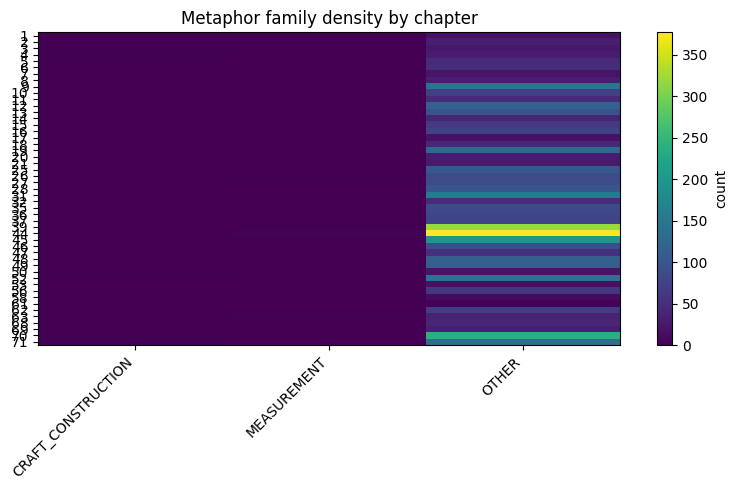

In [ ]:
# Joins metaphor_enriched.csv with BERTopic assignments (if found) to plot a heatmap.
# Fallback: if no topics file found, groups by 'chapter'.

import os, glob, pandas as pd, numpy as np, matplotlib.pyplot as plt

BASE_DIR = globals().get("BASE_DIR", "/content/drive/MyDrive/Chinese Philosophy/Mozi")
meta_path = os.path.join(BASE_DIR, "metaphor_enriched.csv")
assert os.path.exists(meta_path), f"Missing {meta_path}. Run Step 1 first."
meta = pd.read_csv(meta_path)

# Simple family classifier from 'reason' string
def family_from_reason(r):
    r = str(r).lower()
    if any(k in r for k in ["weigh","balance","measure","scale","standard","plumb","square","level"]):
        return "MEASUREMENT"
    if any(k in r for k in ["build","construct","craft","carpenter","join","chisel","plane","saw","hammer","drill"]):
        return "CRAFT_CONSTRUCTION"
    return "OTHER"

meta = meta.loc[meta["is_metaphor_candidate"]==1].copy()
meta["family"] = meta["reason"].apply(family_from_reason)

# Load Mozi text to get row_id→chapter mapping (and to align with topics)
if "df" not in globals():
    mozi_csv = sorted(glob.glob(os.path.join(BASE_DIR, "Mozi*.csv")), key=os.path.getmtime, reverse=True)[0]
    df = pd.read_csv(mozi_csv)
    df.columns = [c.strip().lower() for c in df.columns]
    for cand in ["text","translation","english","content","verse_text","line_text"]:
        if cand in df.columns:
            if cand != "text": df.rename(columns={cand:"text"}, inplace=True)
            break
df = df.reset_index().rename(columns={"index":"row_id"})

# Try to find a BERTopic assignments CSV
topic_file = None
for path in [BASE_DIR, "/content/drive/MyDrive/Chinese Philosophy", "/content/drive/MyDrive"]:
    hits = glob.glob(os.path.join(path, "*bertopic*assign*.csv")) + glob.glob(os.path.join(path, "bertopic_assignments.csv"))
    if hits:
        topic_file = sorted(hits, key=os.path.getmtime, reverse=True)[0]
        break

if topic_file:
    topics = pd.read_csv(topic_file)
    # Heuristics for column names
    cand_cols = {"row_id","doc_id","index","i"}
    id_col = next((c for c in topics.columns if c in cand_cols), None)
    topic_col = next((c for c in topics.columns if "topic" in c.lower()), None)
    assert id_col and topic_col, f"Could not infer id/topic columns from {topic_file}."
    topics = topics.rename(columns={id_col:"row_id", topic_col:"topic"})
    grouping = "topic"
    base = df.merge(topics[["row_id","topic"]], on="row_id", how="left")
    base["topic"] = base["topic"].fillna(-1).astype(int)
else:
    # Fallback: group by chapter
    grouping = "chapter"
    base = df.copy()
    if "chapter" not in base.columns:
        base["chapter"] = pd.cut(base["row_id"], bins=10, labels=[f"seg{i}" for i in range(10)])

joined = (base[["row_id", grouping]]
          .merge(meta[["row_id","family"]], on="row_id", how="left")
          .dropna(subset=["family"]))

pivot = (joined.groupby([grouping,"family"]).size()
         .unstack(fill_value=0)
         .reindex(columns=sorted(joined["family"].unique())))

plt.figure(figsize=(8, 5))
plt.imshow(pivot.values, aspect='auto')
plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=45, ha='right')
plt.yticks(range(pivot.shape[0]), pivot.index)
plt.title(f"Metaphor family density by {grouping}")
plt.colorbar(label="count")
plt.tight_layout()

out_png = os.path.join(BASE_DIR, f"metaphor_heatmap_by_{grouping}.png")
plt.savefig(out_png, dpi=160)
print("Wrote:", out_png)
pivot.head(10)


In [ ]:
# --- Step 5 (no labels): auto-derive metaphor families from CMI + lemmas and plot ---

import os, glob, math, pandas as pd, numpy as np, matplotlib.pyplot as plt

BASE_DIR = globals().get("BASE_DIR", "/content/drive/MyDrive/Chinese Philosophy/Mozi")

# 1) Load metaphor candidates
meta_path_labeled = os.path.join(BASE_DIR, "metaphor_enriched_labeled.csv")
meta_path_flagged = os.path.join(BASE_DIR, "metaphor_enriched.csv")
meta = pd.read_csv(meta_path_labeled if os.path.exists(meta_path_labeled) else meta_path_flagged)

# keep only flagged candidates (no human labels yet)
if "is_metaphor_final" in meta.columns:
    meta = meta[meta["is_metaphor_final"]==1].copy()
else:
    meta = meta[meta["is_metaphor_candidate"]==1].copy()

# 2) Load Mozi text for row_id → chapter mapping
if "df" not in globals():
    mozi_csv = sorted(glob.glob(os.path.join(BASE_DIR, "Mozi*.csv")), key=os.path.getmtime, reverse=True)[0]
    df = pd.read_csv(mozi_csv)
    df.columns = [c.strip().lower() for c in df.columns]
    for cand in ["text","translation","english","content","verse_text","line_text"]:
        if cand in df.columns:
            if cand != "text": df.rename(columns={cand:"text"}, inplace=True)
            break
df = df.reset_index().rename(columns={"index":"row_id"})
if "chapter" not in df.columns:
    # fallback grouping if chapter missing
    bins = 10
    df["chapter"] = pd.cut(df["row_id"], bins=bins, labels=[f"seg{i:02d}" for i in range(bins)])

# 3) Seed lexicons + auto-expand from CMI
cmi_path = os.path.join(BASE_DIR, "cmi_candidates.csv")
MEAS_NOUNS = {
    "measure","weight","balance","scale","standard","plumb","square","level","rule","gauge","yardstick"
}
CRAFT_MECH_NOUNS = {
    "lever","pulley","axle","wheel","hinge","gear","tool","chisel","saw","plane","hammer","drill",
    "timber","wood","carpenter","craftsman","craft","wedge","rope","plank","beam","joinery","mortise","tenon"
}

MEAS_LEM = {"measure","weigh","balance","scale","standard","gauge","calibrate","level","square","plumb","rule"}
CRAFT_LEM = {"build","construct","craft","carpenter","join","chisel","plane","saw","hammer","drill",
             "carve","cut","assemble","erect","repair","polish","shape","file","hew","mortise","tenon"}

if os.path.exists(cmi_path):
    cmi = pd.read_csv(cmi_path)
    meas_auto = set(cmi.loc[cmi["src_noun"].str.lower().isin(MEAS_NOUNS), "verb"].str.lower())
    craft_auto = set(cmi.loc[cmi["src_noun"].str.lower().isin(CRAFT_MECH_NOUNS), "verb"].str.lower())
    MEAS_LEM |= meas_auto
    CRAFT_LEM |= craft_auto
    print("Auto-added measurement verbs from CMI:", sorted(list(meas_auto))[:30])
    print("Auto-added craft/mechanics verbs from CMI:", sorted(list(craft_auto))[:30])
else:
    print("No cmi_candidates.csv found; using seed lexicons only.")

# 4) Family classifier (lemma-first, then token string fallback)
def family_from_row(r):
    lem = str(r.get("lemma","")).lower()
    tok = str(r.get("token","")).lower()
    if lem in MEAS_LEM or any(k in tok for k in MEAS_LEM):
        return "MEASUREMENT"
    if lem in CRAFT_LEM or any(k in tok for k in CRAFT_LEM):
        return "CRAFT_CONSTRUCTION"
    return "OTHER"

meta["family"] = meta.apply(family_from_row, axis=1)

# 5) Aggregate to sentence-level to avoid multi-token inflation
sent_level = (meta.groupby(["row_id","family"])
                  .size()
                  .reset_index(name="hits"))

# 6) Join with chapter and build pivots
grouping = "chapter"
base = df[["row_id", grouping]].copy()
joined = base.merge(sent_level, on="row_id", how="left").dropna(subset=["family"])

pivot_counts = (joined.groupby([grouping,"family"])["hits"]
                     .sum()
                     .unstack(fill_value=0))

chapter_sizes = df.groupby(grouping).size()
pivot_rate = pivot_counts.div(chapter_sizes, axis=0) * 100.0  # per 100 sentences

# 7) Plot and save
def heatmap(mat, title, out_name, label):
    plt.figure(figsize=(8,5))
    plt.imshow(mat.values, aspect='auto')
    plt.xticks(range(mat.shape[1]), mat.columns, rotation=45, ha='right')
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.title(title)
    plt.colorbar(label=label)
    plt.tight_layout()
    out_png = os.path.join(BASE_DIR, out_name)
    plt.savefig(out_png, dpi=160)
    print("Wrote:", out_png)

heatmap(pivot_counts, "Metaphor family density by chapter (counts)", "metaphor_heatmap_counts.png", "count")
heatmap(pivot_rate,   "Metaphor family density by chapter (normalized)", "metaphor_heatmap_normalized.png", "per 100 sentences")

print("\nTotals (raw counts):")
print(pivot_counts.sum(0).sort_values(ascending=False))
print("\nTotals (normalized sum):")
print(pivot_rate.sum(0).sort_values(ascending=False))


Auto-added measurement verbs from CMI: ['establish', 'have', 'take']
Auto-added craft/mechanics verbs from CMI: ['have', 'join', 'lose']


ValueError: The column label 'row_id' is not unique.

In [ ]:
# --- Step 5 (fixed): unique row_id, filtered CMI verbs, and new heatmaps ---

import os, glob, pandas as pd, numpy as np, matplotlib.pyplot as plt

BASE_DIR = globals().get("BASE_DIR", "/content/drive/MyDrive/Chinese Philosophy/Mozi")

# 1) Load metaphor candidates
meta_path_labeled = os.path.join(BASE_DIR, "metaphor_enriched_labeled.csv")
meta_path_flagged = os.path.join(BASE_DIR, "metaphor_enriched.csv")
meta = pd.read_csv(meta_path_labeled if os.path.exists(meta_path_labeled) else meta_path_flagged)
meta = meta[(meta.get("is_metaphor_final", meta.get("is_metaphor_candidate", 0))==1)].copy()

# 2) Load Mozi text and ensure a SINGLE, clean row_id that matches meta
if "df" not in globals():
    mozi_csv = sorted(glob.glob(os.path.join(BASE_DIR, "Mozi*.csv")), key=os.path.getmtime, reverse=True)[0]
    df = pd.read_csv(mozi_csv)

# normalize columns + drop duplicate-named columns
df.columns = [c.strip().lower() for c in df.columns]
df = df.loc[:, ~pd.Index(df.columns).duplicated()]

# rebuild row_id as 0..n-1 (guaranteed unique & aligned with Step 1’s enumerate)
df = df.reset_index(drop=True)
df["row_id"] = np.arange(len(df))

# chapter fallback
if "chapter" not in df.columns:
    bins = 10
    df["chapter"] = pd.cut(df["row_id"], bins=bins, labels=[f"seg{i:02d}" for i in range(bins)])

# 3) Build/expand lexicons from CMI, but filter out generic/high-frequency verbs
MEAS_NOUNS = {"measure","weight","balance","scale","standard","plumb","square","level","rule","gauge","yardstick"}
CRAFT_MECH_NOUNS = {"lever","pulley","axle","wheel","hinge","gear","tool","chisel","saw","plane","hammer","drill",
                    "timber","wood","carpenter","craftsman","craft","wedge","rope","plank","beam","joinery","mortise","tenon"}

MEAS_LEM = {"measure","weigh","balance","scale","standard","gauge","calibrate","level","square","plumb","rule"}
CRAFT_LEM = {"build","construct","craft","carpenter","join","chisel","plane","saw","hammer","drill",
             "carve","cut","assemble","erect","repair","polish","shape","file","hew","mortise","tenon"}

STOP_VERBS = {"be","have","do","get","take","lose","make"}  # filter noisy generic verbs

cmi_path = os.path.join(BASE_DIR, "cmi_candidates.csv")
if os.path.exists(cmi_path):
    cmi = pd.read_csv(cmi_path)
    meas_auto = {v.lower() for v in cmi.loc[cmi["src_noun"].str.lower().isin(MEAS_NOUNS), "verb"]
                 if isinstance(v := str(v), str) and v and v.lower() not in STOP_VERBS}
    craft_auto = {v.lower() for v in cmi.loc[cmi["src_noun"].str.lower().isin(CRAFT_MECH_NOUNS), "verb"]
                  if isinstance(v := str(v), str) and v and v.lower() not in STOP_VERBS}
    MEAS_LEM |= meas_auto
    CRAFT_LEM |= craft_auto
    print("Added from CMI → MEAS:", sorted(list(meas_auto))[:25])
    print("Added from CMI → CRAFT:", sorted(list(craft_auto))[:25])
else:
    print("No cmi_candidates.csv found; using seed lexicons only.")

# 4) Family classifier (lemma-first, then token fallback)
def family_from_row(r):
    lem = str(r.get("lemma","")).lower()
    tok = str(r.get("token","")).lower()
    if lem in MEAS_LEM or any(k in tok for k in MEAS_LEM): return "MEASUREMENT"
    if lem in CRAFT_LEM or any(k in tok for k in CRAFT_LEM): return "CRAFT_CONSTRUCTION"
    return "OTHER"

meta["family"] = meta.apply(family_from_row, axis=1)

# 5) Aggregate to sentence-level (avoid multi-token inflation)
sent_level = (meta.groupby(["row_id","family"]).size().reset_index(name="hits"))

# 6) Join with chapters — now safe (unique row_id)
base = df[["row_id","chapter"]].copy()
joined = base.merge(sent_level, on="row_id", how="left").dropna(subset=["family"])

# 7) Pivots (counts and normalized per 100 sentences)
pivot_counts = (joined.groupby(["chapter","family"])["hits"].sum().unstack(fill_value=0))
chapter_sizes = df.groupby("chapter").size()
pivot_rate = pivot_counts.div(chapter_sizes, axis=0) * 100.0

def heatmap(mat, title, out_name, label):
    plt.figure(figsize=(8,5))
    plt.imshow(mat.values, aspect='auto')
    plt.xticks(range(mat.shape[1]), mat.columns, rotation=45, ha='right')
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.title(title)
    plt.colorbar(label=label)
    plt.tight_layout()
    out_png = os.path.join(BASE_DIR, out_name)
    plt.savefig(out_png, dpi=160)
    print("Wrote:", out_png)

heatmap(pivot_counts, "Metaphor family density by chapter (counts)", "metaphor_heatmap_counts.png", "count")
heatmap(pivot_rate,   "Metaphor family density by chapter (normalized)", "metaphor_heatmap_normalized.png", "per 100 sentences")

print("\nTotals (raw counts):")
print(pivot_counts.sum(0).sort_values(ascending=False))
print("\nTotals (normalized):")
print(pivot_rate.sum(0).sort_values(ascending=False))


SyntaxError: assignment expression cannot rebind comprehension iteration variable 'v' (ipython-input-2252169340.py, line 46)

Added from CMI → MEAS: ['establish']
Added from CMI → CRAFT: ['join']
Wrote: /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_heatmap_counts.png
Wrote: /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_heatmap_normalized.png

Totals (raw counts):
family
OTHER                 4050.0
CRAFT_CONSTRUCTION      21.0
MEASUREMENT             14.0
dtype: float64

Totals (normalized):
family
OTHER                 34923.676811
CRAFT_CONSTRUCTION      128.345963
MEASUREMENT              94.494390
dtype: float64


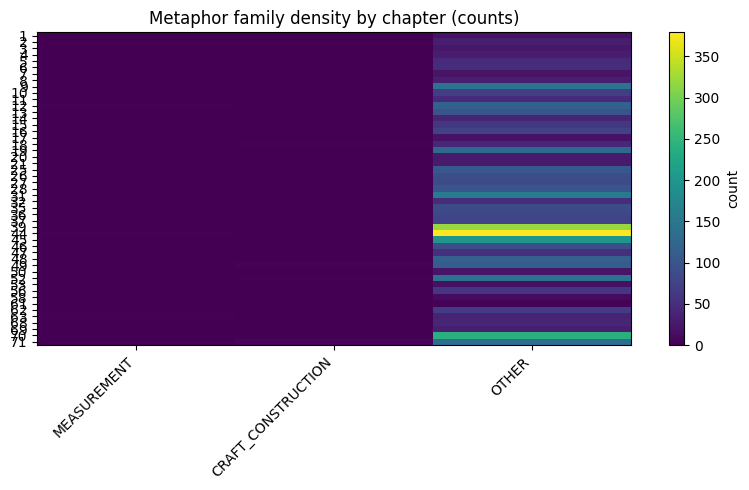

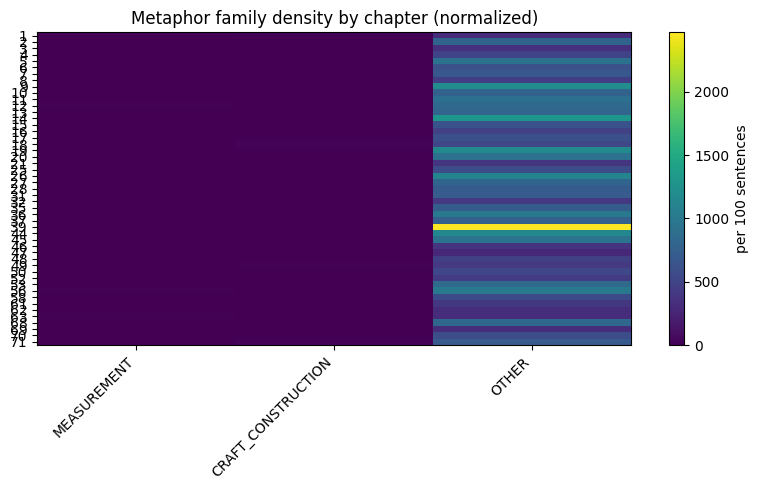

In [ ]:
# --- Step 5 (fixed v2): unique row_id, filtered CMI verbs, and new heatmaps ---

import os, glob, pandas as pd, numpy as np, matplotlib.pyplot as plt

BASE_DIR = globals().get("BASE_DIR", "/content/drive/MyDrive/Chinese Philosophy/Mozi")

# 1) Load metaphor candidates
meta_path_labeled = os.path.join(BASE_DIR, "metaphor_enriched_labeled.csv")
meta_path_flagged = os.path.join(BASE_DIR, "metaphor_enriched.csv")
meta = pd.read_csv(meta_path_labeled if os.path.exists(meta_path_labeled) else meta_path_flagged)
flag_col = "is_metaphor_final" if "is_metaphor_final" in meta.columns else "is_metaphor_candidate"
meta = meta[meta[flag_col]==1].copy()

# 2) Load Mozi text and ensure a SINGLE, clean row_id aligned with Step 1
if "df" not in globals():
    mozi_csv = sorted(glob.glob(os.path.join(BASE_DIR, "Mozi*.csv")), key=os.path.getmtime, reverse=True)[0]
    df = pd.read_csv(mozi_csv)

df.columns = [c.strip().lower() for c in df.columns]
df = df.loc[:, ~pd.Index(df.columns).duplicated()]
df = df.reset_index(drop=True)
df["row_id"] = np.arange(len(df))

if "chapter" not in df.columns:
    bins = 10
    df["chapter"] = pd.cut(df["row_id"], bins=bins, labels=[f"seg{i:02d}" for i in range(bins)])

# 3) Build/expand lexicons from CMI, filtering generic/high-frequency verbs
MEAS_NOUNS = {"measure","weight","balance","scale","standard","plumb","square","level","rule","gauge","yardstick"}
CRAFT_MECH_NOUNS = {"lever","pulley","axle","wheel","hinge","gear","tool","chisel","saw","plane","hammer","drill",
                    "timber","wood","carpenter","craftsman","craft","wedge","rope","plank","beam","joinery","mortise","tenon"}

MEAS_LEM = {"measure","weigh","balance","scale","standard","gauge","calibrate","level","square","plumb","rule"}
CRAFT_LEM = {"build","construct","craft","carpenter","join","chisel","plane","saw","hammer","drill",
             "carve","cut","assemble","erect","repair","polish","shape","file","hew","mortise","tenon"}

STOP_VERBS = {"be","have","do","get","take","lose","make"}  # filter noisy generics

cmi_path = os.path.join(BASE_DIR, "cmi_candidates.csv")
if os.path.exists(cmi_path):
    cmi = pd.read_csv(cmi_path)

    src_noun_lower = cmi["src_noun"].astype(str).str.lower()

    meas_auto = set()
    for v in cmi.loc[src_noun_lower.isin(MEAS_NOUNS), "verb"].dropna():
        v_norm = str(v).strip().lower()
        if v_norm and v_norm not in STOP_VERBS and v_norm.isalpha():
            meas_auto.add(v_norm)

    craft_auto = set()
    for v in cmi.loc[src_noun_lower.isin(CRAFT_MECH_NOUNS), "verb"].dropna():
        v_norm = str(v).strip().lower()
        if v_norm and v_norm not in STOP_VERBS and v_norm.isalpha():
            craft_auto.add(v_norm)

    MEAS_LEM |= meas_auto
    CRAFT_LEM |= craft_auto
    print("Added from CMI → MEAS:", sorted(list(meas_auto))[:25])
    print("Added from CMI → CRAFT:", sorted(list(craft_auto))[:25])
else:
    print("No cmi_candidates.csv found; using seed lexicons only.")

# 4) Family classifier (lemma-first, then token fallback)
def family_from_row(r):
    lem = str(r.get("lemma","")).lower()
    tok = str(r.get("token","")).lower()
    if lem in MEAS_LEM or any(k in tok for k in MEAS_LEM): return "MEASUREMENT"
    if lem in CRAFT_LEM or any(k in tok for k in CRAFT_LEM): return "CRAFT_CONSTRUCTION"
    return "OTHER"

meta["family"] = meta.apply(family_from_row, axis=1)

# 5) Aggregate to sentence-level (avoid multi-token inflation)
sent_level = meta.groupby(["row_id","family"]).size().reset_index(name="hits")

# 6) Join with chapters — safe merge (unique row_id)
base = df[["row_id","chapter"]].copy()
joined = base.merge(sent_level, on="row_id", how="left").dropna(subset=["family"])

# 7) Pivots (counts and normalized per 100 sentences)
pivot_counts = joined.groupby(["chapter","family"])["hits"].sum().unstack(fill_value=0)
chapter_sizes = df.groupby("chapter").size()
pivot_rate = pivot_counts.div(chapter_sizes, axis=0) * 100.0

# keep a tidy family order if present
family_order = [f for f in ["MEASUREMENT","CRAFT_CONSTRUCTION","OTHER"] if f in pivot_counts.columns]
pivot_counts = pivot_counts.reindex(columns=family_order)
pivot_rate   = pivot_rate.reindex(columns=family_order)

def heatmap(mat, title, out_name, label):
    plt.figure(figsize=(8,5))
    plt.imshow(mat.values, aspect='auto')
    plt.xticks(range(mat.shape[1]), mat.columns, rotation=45, ha='right')
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.title(title)
    plt.colorbar(label=label)
    plt.tight_layout()
    out_png = os.path.join(BASE_DIR, out_name)
    plt.savefig(out_png, dpi=160)
    print("Wrote:", out_png)

heatmap(pivot_counts, "Metaphor family density by chapter (counts)", "metaphor_heatmap_counts.png", "count")
heatmap(pivot_rate,   "Metaphor family density by chapter (normalized)", "metaphor_heatmap_normalized.png", "per 100 sentences")

print("\nTotals (raw counts):")
print(pivot_counts.sum(0).sort_values(ascending=False))
print("\nTotals (normalized):")
print(pivot_rate.sum(0).sort_values(ascending=False))


In [ ]:
#@title Step 0 — Setup + data loader
# Installs (pinned), downloads models, mounts Drive, auto-finds Mozi CSV, normalizes columns, and sets BASE_DIR.
!pip -q install "spacy==3.8.2" "pandas==2.2.2" "matplotlib==3.9.0" "nltk==3.9.1" "wordfreq==3.1.1" "gradio>=4.41,<5" "openai>=1.40.0,<2"

import sys, os, pathlib, re, json, random, math, time, textwrap, itertools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NLTK setup
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Google Drive mount (defensive)
BASE_DIR = pathlib.Path("/content/drive/MyDrive/Chinese Philosophy/Mozi")
try:
    from google.colab import drive  # type: ignore
    if not pathlib.Path("/content/drive").exists():
        os.makedirs("/content/drive", exist_ok=True)
    try:
        drive.mount('/content/drive', force_remount=True)
    except Exception as e:
        print("[WARN] Drive mount issue:", e)
        print("[HINT] Continuing without Drive; paths will default to /content only.")
        BASE_DIR = pathlib.Path("/content/Mozi")
except Exception as e:
    print("[WARN] Not running in Colab or Drive not available:", e)
    BASE_DIR = pathlib.Path("/content/Mozi")

# Ensure BASE_DIR exists
BASE_DIR.mkdir(parents=True, exist_ok=True)
(SRC_DIR := BASE_DIR / "source_corpus").mkdir(parents=True, exist_ok=True)

# spaCy model check / install
import spacy
from spacy.util import is_package
NEEDS_MODEL = False
try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    NEEDS_MODEL = True
    print("[INFO] Installing spaCy model en_core_web_sm...")
    import spacy.cli as spacy_cli
    spacy_cli.download("en_core_web_sm")
    # Will require restart; provided in the next cell.

# WordNet
from nltk.corpus import wordnet as wn

# Auto-discover Mozi CSV (case-insensitive)
def find_mozi_csv():
    candidates = []
    roots = [pathlib.Path("/content/drive/MyDrive"), BASE_DIR]
    seen = set()
    for root in roots:
        if not root.exists():
            continue
        for p in root.rglob("*.csv"):
            name = p.name.lower()
            if ("mozi" in name and "corrected" in name) or (name.startswith("mozi") and "corrected" in name):
                try:
                    key = (p.resolve().as_posix())
                    if key not in seen:
                        seen.add(key)
                        candidates.append(p)
                except Exception:
                    candidates.append(p)
    # Fallback: any CSV under BASE_DIR
    if not candidates:
        for p in BASE_DIR.rglob("*.csv"):
            candidates.append(p)
    # Pick the most recently modified
    if candidates:
        candidates = sorted(candidates, key=lambda p: p.stat().st_mtime, reverse=True)
        return candidates[0]
    return None

mozi_csv = find_mozi_csv()
if mozi_csv is None:
    print(f"[WARN] Could not auto-find Mozi CSV. Expecting a file like 'Mozi_corrected.csv'.")
    print(f"[HINT] Place it under: {BASE_DIR.as_posix()} or anywhere in Drive with 'Mozi' and 'corrected' in the name.")
else:
    print(f"[INFO] Using Mozi CSV: {mozi_csv}")

# Load and normalize
def load_normalize_csv(pathlike):
    assert pathlike is not None and pathlib.Path(pathlike).exists(), "Mozi CSV not found."
    df = pd.read_csv(pathlike)
    # Normalize columns
    df.columns = [str(c).strip().lower() for c in df.columns]
    # Pick a text column
    TEXT_CANDIDATES = ["text","translation","english","content","verse_text","line_text"]
    text_col = None
    for c in TEXT_CANDIDATES:
        if c in df.columns:
            text_col = c
            break
    if text_col is None:
        # Try single non-numeric column
        nonnum = [c for c in df.columns if df[c].dtype == object]
        assert nonnum, "No suitable text column found."
        text_col = nonnum[0]
        print(f"[WARN] Falling back to column '{text_col}' as text.")
    df = df.copy()
    df["__text__"] = df[text_col].astype(str)
    # Chapter-like column, optional
    CHAPTER_CAND = ["chapter","chap","juan","book","section","mozi_chapter","mozi_book","scroll"]
    chap_col = None
    for c in CHAPTER_CAND:
        if c in df.columns:
            chap_col = c
            break
    if chap_col is None:
        df["__chapter__"] = "Unknown"
    else:
        df["__chapter__"] = df[chap_col].astype(str).replace({np.nan:"Unknown"})
    # Add row_id
    if "__row_id__" not in df.columns:
        df["__row_id__"] = np.arange(len(df))
    # Minimal clean
    df["__text__"] = df["__text__"].fillna("").map(lambda s: re.sub(r"\s+", " ", s).strip())
    return df, text_col, chap_col

df, TEXT_COL, CHAP_COL = (None, None, None)
try:
    if mozi_csv:
        df, TEXT_COL, CHAP_COL = load_normalize_csv(mozi_csv)
        print(f"[INFO] Loaded {len(df)} rows; text='{TEXT_COL}', chapter='{CHAP_COL or '__chapter__'}'.")
        print(df[[ "__row_id__", "__chapter__", "__text__" ]].head(2))
        # Cache normalized copy
        df.to_csv(BASE_DIR / "mozi_normalized_preview.csv", index=False)
        print(f"[OK] Preview written: { (BASE_DIR / 'mozi_normalized_preview.csv').as_posix() }")
    else:
        print("[ERR] No CSV loaded.")
except AssertionError as e:
    print("[ERR]", e)
    print("[HINT] Ensure your CSV exists and has a recognizable text column.")

# Save a small env manifest for reproducibility
manifest = {
    "python": sys.version,
    "packages": {
        "spacy": spacy.__version__,
        "pandas": pd.__version__,
        "matplotlib": plt.matplotlib.__version__,
        "nltk": nltk.__version__,
        "wordfreq": __import__("wordfreq").__version__,
    },
    "mozi_csv": str(mozi_csv) if mozi_csv else None,
    "base_dir": BASE_DIR.as_posix()
}
with open(BASE_DIR / "env_manifest.json","w") as f:
    json.dump(manifest, f, indent=2)
print("[OK] Wrote env_manifest.json")
print("[NOTE] If the spaCy model was just installed, run the next cell once to restart the runtime.")


Mounted at /content/drive
[INFO] Using Mozi CSV: /content/drive/MyDrive/Chinese Philosophy/Mozi_corrected.csv
[INFO] Loaded 590 rows; text='text', chapter='chapter'.
   __row_id__ __chapter__                                           __text__
0           0           1  To take control of a state and not be sympathe...
1           1           1  In earlier times, Duke Wen had to flee, and ye...
[OK] Preview written: /content/drive/MyDrive/Chinese Philosophy/Mozi/mozi_normalized_preview.csv


AttributeError: module 'wordfreq' has no attribute '__version__'

In [ ]:
#@title Step 0 — Setup + data loader (patched: safe version detection)
# Installs (pinned), downloads models, mounts Drive, auto-finds Mozi CSV, normalizes columns, and sets BASE_DIR.
!pip -q install "spacy==3.8.2" "pandas==2.2.2" "matplotlib==3.9.0" "nltk==3.9.1" "wordfreq==3.1.1" "gradio>=4.41,<5" "openai>=1.40.0,<2"

import sys, os, pathlib, re, json, random, math, time, textwrap, itertools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NLTK setup
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Google Drive mount (defensive)
BASE_DIR = pathlib.Path("/content/drive/MyDrive/Chinese Philosophy/Mozi")
try:
    from google.colab import drive  # type: ignore
    if not pathlib.Path("/content/drive").exists():
        os.makedirs("/content/drive", exist_ok=True)
    try:
        drive.mount('/content/drive', force_remount=True)
    except Exception as e:
        print("[WARN] Drive mount issue:", e)
        print("[HINT] Continuing without Drive; paths will default to /content only.")
        BASE_DIR = pathlib.Path("/content/Mozi")
except Exception as e:
    print("[WARN] Not running in Colab or Drive not available:", e)
    BASE_DIR = pathlib.Path("/content/Mozi")

# Ensure BASE_DIR exists
BASE_DIR.mkdir(parents=True, exist_ok=True)
(SRC_DIR := BASE_DIR / "source_corpus").mkdir(parents=True, exist_ok=True)

# spaCy model check / install
import spacy
NEEDS_MODEL = False
try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    NEEDS_MODEL = True
    print("[INFO] Installing spaCy model en_core_web_sm...")
    import spacy.cli as spacy_cli
    spacy_cli.download("en_core_web_sm")
    # Will require restart; provided in the next cell.

# WordNet
from nltk.corpus import wordnet as wn

# Auto-discover Mozi CSV (case-insensitive)
def find_mozi_csv():
    candidates = []
    roots = [pathlib.Path("/content/drive/MyDrive"), BASE_DIR]
    seen = set()
    for root in roots:
        if not root.exists():
            continue
        for p in root.rglob("*.csv"):
            name = p.name.lower()
            if ("mozi" in name and "corrected" in name) or (name.startswith("mozi") and "corrected" in name):
                try:
                    key = (p.resolve().as_posix())
                    if key not in seen:
                        seen.add(key)
                        candidates.append(p)
                except Exception:
                    candidates.append(p)
    # Fallback: any CSV under BASE_DIR
    if not candidates:
        for p in BASE_DIR.rglob("*.csv"):
            candidates.append(p)
    # Pick the most recently modified
    if candidates:
        candidates = sorted(candidates, key=lambda p: p.stat().st_mtime, reverse=True)
        return candidates[0]
    return None

mozi_csv = find_mozi_csv()
if mozi_csv is None:
    print(f"[WARN] Could not auto-find Mozi CSV. Expecting a file like 'Mozi_corrected.csv'.")
    print(f"[HINT] Place it under: {BASE_DIR.as_posix()} or anywhere in Drive with 'Mozi' and 'corrected' in the name.")
else:
    print(f"[INFO] Using Mozi CSV: {mozi_csv}")

# Load and normalize
def load_normalize_csv(pathlike):
    assert pathlike is not None and pathlib.Path(pathlike).exists(), "Mozi CSV not found."
    df = pd.read_csv(pathlike)
    # Normalize columns
    df.columns = [str(c).strip().lower() for c in df.columns]
    # Pick a text column
    TEXT_CANDIDATES = ["text","translation","english","content","verse_text","line_text"]
    text_col = next((c for c in TEXT_CANDIDATES if c in df.columns), None)
    if text_col is None:
        nonnum = [c for c in df.columns if df[c].dtype == object]
        assert nonnum, "No suitable text column found."
        text_col = nonnum[0]
        print(f"[WARN] Falling back to column '{text_col}' as text.")
    df = df.copy()
    df["__text__"] = df[text_col].astype(str)
    # Chapter-like column, optional
    CHAPTER_CAND = ["chapter","chap","juan","book","section","mozi_chapter","mozi_book","scroll"]
    chap_col = next((c for c in CHAPTER_CAND if c in df.columns), None)
    if chap_col is None:
        df["__chapter__"] = "Unknown"
    else:
        df["__chapter__"] = df[chap_col].astype(str).replace({np.nan:"Unknown"})
    # Add row_id
    if "__row_id__" not in df.columns:
        df["__row_id__"] = np.arange(len(df))
    # Minimal clean
    df["__text__"] = df["__text__"].fillna("").map(lambda s: re.sub(r"\s+", " ", s).strip())
    return df, text_col, chap_col

df, TEXT_COL, CHAP_COL = (None, None, None)
try:
    if mozi_csv:
        df, TEXT_COL, CHAP_COL = load_normalize_csv(mozi_csv)
        print(f"[INFO] Loaded {len(df)} rows; text='{TEXT_COL}', chapter='{CHAP_COL or '__chapter__'}'.")
        print(df[[ "__row_id__", "__chapter__", "__text__" ]].head(2))
        # Cache normalized copy
        df.to_csv(BASE_DIR / "mozi_normalized_preview.csv", index=False)
        print(f"[OK] Preview written: { (BASE_DIR / 'mozi_normalized_preview.csv').as_posix() }")
    else:
        print("[ERR] No CSV loaded.")
except AssertionError as e:
    print("[ERR]", e)
    print("[HINT] Ensure your CSV exists and has a recognizable text column.")

# ---- Safe package version reporting (fix for wordfreq lacking __version__) ----
try:
    from importlib.metadata import version as _pkg_version
except Exception:
    _pkg_version = None

def get_version(pkg: str, module_name: str | None = None) -> str:
    try:
        mod = __import__(module_name or pkg)
        v = getattr(mod, "__version__", None)
        if v:
            return str(v)
    except Exception:
        pass
    if _pkg_version is not None:
        try:
            return _pkg_version(pkg)
        except Exception:
            pass
    return "unknown"

# Save a small env manifest for reproducibility
manifest = {
    "python": sys.version,
    "packages": {
        "spacy": get_version("spacy"),
        "pandas": get_version("pandas"),
        "matplotlib": get_version("matplotlib", "matplotlib"),
        "nltk": get_version("nltk"),
        "wordfreq": get_version("wordfreq"),
        "gradio": get_version("gradio"),
        "openai": get_version("openai"),
    },
    "mozi_csv": str(mozi_csv) if mozi_csv else None,
    "base_dir": BASE_DIR.as_posix()
}
with open(BASE_DIR / "env_manifest.json","w") as f:
    json.dump(manifest, f, indent=2)
print("[OK] Wrote env_manifest.json")
print("[NOTE] If the spaCy model was just installed, run the next cell once to restart the runtime.")


Mounted at /content/drive
[INFO] Using Mozi CSV: /content/drive/MyDrive/Chinese Philosophy/Mozi_corrected.csv
[INFO] Loaded 590 rows; text='text', chapter='chapter'.
   __row_id__ __chapter__                                           __text__
0           0           1  To take control of a state and not be sympathe...
1           1           1  In earlier times, Duke Wen had to flee, and ye...
[OK] Preview written: /content/drive/MyDrive/Chinese Philosophy/Mozi/mozi_normalized_preview.csv
[OK] Wrote env_manifest.json
[NOTE] If the spaCy model was just installed, run the next cell once to restart the runtime.


In [ ]:
#@title (Optional) Restart runtime (run once if en_core_web_sm was just installed)
import os, sys
print("[INFO] Restarting runtime now...")
os.kill(os.getpid(), 9)


In [ ]:
#@title Step 1 — Heuristic metaphor candidates → CSV
# spaCy parse with nlp.pipe; SPV/CCO rules; WordNet-based abstractness; writes:
# - metaphor_enriched_full.csv (all tokens)
# - metaphor_enriched.csv (flagged tokens only)
import os, pathlib, json, re, math, random
import pandas as pd
import numpy as np
import spacy
from nltk.corpus import wordnet as wn
from wordfreq import zipf_frequency

assert (BASE_DIR / "env_manifest.json").exists(), "[ERR] Setup not completed. Run Step 0."
assert (BASE_DIR / "mozi_normalized_preview.csv").exists(), "[ERR] No normalized preview. Re-run Step 0."
df = pd.read_csv(BASE_DIR / "mozi_normalized_preview.csv")

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except Exception as e:
    raise RuntimeError("en_core_web_sm missing. Run the restart cell after installing the model.") from e

# Heuristic resources
MEASUREMENT_VERBS = {
    "measure","weigh","gauge","calibrate","benchmark","assess","evaluate","estimate","calculate","count","scale","standardize","balance","level","meter","rate","score"
}
MEASUREMENT_NOUNS = {
    "measure","measurement","weight","scale","ruler","square","compass","yardstick","standard","gauge","balance","meter","rule","benchmark","calibration"
}
CRAFT_VERBS = {
    "build","construct","forge","craft","hammer","chisel","cut","saw","drill","weld","mold","carve","join","fit","assemble","fabricate","repair","mend","nail","bolt","plane","lathe","engineer","design","hewn","hew"
}
CRAFT_NOUNS = {
    "tool","machine","gear","axle","wheel","lever","pulley","square","ruler","compass","chisel","hammer","saw","drill","plumb","line","string","inkline","compass"
}

ABSTRACT_LEXNAMES = {
    # WordNet lexnames that tend to be abstract
    "noun.cognition","noun.attribute","noun.communication","noun.act","noun.event","noun.feeling","noun.motive","noun.state","noun.time","noun.location","noun.group"
}
CONCRETE_LEXNAMES = {
    "noun.artifact","noun.object","noun.body","noun.animal","noun.plant","noun.food","noun.substance","noun.shape","noun.quantity"
}

INTANGIBLE_OVERRIDES = {
    "virtue","kindness","righteousness","faithfulness","justice","policy","plan","argument","doctrine","speech","language","order","disorder","governance","law","heaven","heaven's","heavens","profit","benefit","harm","intention"
}

STOP_VERBS = {
    "be","am","is","are","was","were","been","being",
    "have","has","had",
    "do","does","did","done",
    "get","gets","got","become",
    "make","makes","made",
    "take","takes","took","taken",
    "give","gives","gave","given",
    "go","goes","went","gone","come","comes","came",
    "put","puts","set","sets","keep","keeps","kept","let","lets","seem","seems",
    "see","sees","saw","seen","look","looks",
    "want","wants","need","needs",
    "use","uses","try","tries","tried",
    "find","finds","found","think","thinks","thought",
    "tell","tells","told","ask","asks","asked",
    "work","works","feel","feels","felt",
    "leave","leaves","call","calls","called",
    "like","likes","follow","follows","followed",
    "begin","begins","began","begun","happen","happens","include","includes","continue","continues",
    "lose","loses","lost","join","joins","joined","hold","holds","show","shows","provide","provides"
}

def wordnet_lexnames(word, pos=None):
    try:
        syns = wn.synsets(word, pos=pos)
        return {s.lexname() for s in syns}
    except Exception:
        return set()

def is_abstract_noun(noun_lemma: str) -> bool:
    noun_lemma = noun_lemma.lower()
    if noun_lemma in INTANGIBLE_OVERRIDES:
        return True
    lex = wordnet_lexnames(noun_lemma, pos=wn.NOUN)
    if not lex:
        # Frequency fallback: treat rare words as unknown (not abstract by default)
        return False
    return any(l in ABSTRACT_LEXNAMES for l in lex) and not any(l in CONCRETE_LEXNAMES for l in lex)

def family_guess_for(verb_lemma: str, obj_lemma: str) -> str:
    if verb_lemma in MEASUREMENT_VERBS or obj_lemma in MEASUREMENT_NOUNS:
        return "MEASUREMENT"
    if verb_lemma in CRAFT_VERBS or obj_lemma in CRAFT_NOUNS:
        return "CRAFT_CONSTRUCTION"
    return "OTHER"

def zipf_ok(token_text: str, min_zipf=1.5):
    # Avoid ultra-rare junk when flagging
    try:
        return zipf_frequency(token_text, "en") >= min_zipf
    except Exception:
        return True

# Parse texts
texts = df["__text__"].fillna("").tolist()
chapters = df["__chapter__"].fillna("Unknown").tolist()
row_ids = df["__row_id__"].tolist()

docs = list(nlp.pipe(texts, disable=["ner"]))
print(f"[INFO] Parsed {len(docs)} documents with spaCy.")

full_rows = []
flag_rows = []

for rid, chap, doc, raw in zip(row_ids, chapters, docs, texts):
    for sent_i, sent in enumerate(doc.sents):
        # Collect candidates on verbs with subj/obj relationships
        for tok in sent:
            if tok.pos_ == "VERB" and tok.lemma_.lower() not in STOP_VERBS:
                reasons = []
                fam = "OTHER"
                # Check subjects/objects
                obj_nouns = [c for c in tok.children if c.dep_ in ("dobj","obj","attr","pobj") and c.pos_ in ("NOUN","PROPN","PRON")]
                subj_nouns = [c for c in tok.children if c.dep_ in ("nsubj","nsubjpass") and c.pos_ in ("NOUN","PROPN","PRON")]

                def noun_lemma(n):
                    return n.lemma_.lower() if n.lemma_ else n.text.lower()

                # Core SPV/CCO heuristics
                for n in obj_nouns + subj_nouns:
                    v = tok.lemma_.lower()
                    nlem = noun_lemma(n)
                    fam = family_guess_for(v, nlem)
                    # Measurement/Craft verbs applied to abstract nouns
                    if (v in MEASUREMENT_VERBS or v in CRAFT_VERBS) and is_abstract_noun(nlem) and zipf_ok(n.text):
                        if v in MEASUREMENT_VERBS:
                            reasons.append(f"MEASUREMENT_on_abstract_{n.dep_}:{nlem}")
                        else:
                            reasons.append(f"CRAFT_on_abstract_{n.dep_}:{nlem}")

                    # Artifacts (measurement/craft nouns) modifying abstract heads (e.g., 'square' of 'virtue')
                    if nlem in (MEASUREMENT_NOUNS | CRAFT_NOUNS) and any(is_abstract_noun(h.lemma_.lower()) for h in [tok.head] if h is not None):
                        reasons.append(f"ARTIFACT_modifier_to_abstract:{nlem}")

                # Token-level row (full)
                row = {
                    "row_id": rid,
                    "chapter": chap,
                    "sent_id": f"{rid}:{sent_i}",
                    "sentence": sent.text.strip(),
                    "focus_token": tok.text,
                    "focus_lemma": tok.lemma_.lower(),
                    "focus_pos": tok.pos_,
                    "focus_dep": tok.dep_,
                    "is_metaphor_heuristic": 1 if reasons else 0,
                    "family_guess": fam if reasons else "OTHER",
                    "reasons": ";".join(sorted(set(reasons))) if reasons else "",
                }
                full_rows.append(row)
                if reasons:
                    flag_rows.append(row)
            else:
                # Record other tokens minimally for the "full" output?
                # Keep minimal footprint: skip non-verb tokens in full.
                pass

full_df = pd.DataFrame(full_rows)
flag_df = pd.DataFrame(flag_rows)

out_full = BASE_DIR / "metaphor_enriched_full.csv"
out_flag = BASE_DIR / "metaphor_enriched.csv"
full_df.to_csv(out_full, index=False)
flag_df.to_csv(out_flag, index=False)

print(f"[OK] Wrote {out_full.name} (rows: {len(full_df)}) and {out_flag.name} (flagged rows: {len(flag_df)}).")
if len(flag_df)==0:
    print("[HINT] No flagged items found. You may broaden heuristics or proceed to CMI discovery.")


NameError: name 'BASE_DIR' is not defined

In [ ]:
#@title Step 1 — Heuristic metaphor candidates → CSV (patched: self-contained, rebuilds BASE_DIR if missing)
# spaCy parse with nlp.pipe; SPV/CCO rules; WordNet-based abstractness; writes:
# - metaphor_enriched_full.csv (all tokens)
# - metaphor_enriched.csv (flagged tokens only)

import os, json, re, math, pathlib, collections
import pandas as pd
import numpy as np

# ---------- Recover BASE_DIR (works even after runtime restart) ----------
from pathlib import Path

def recover_base_dir() -> Path:
    # Try env manifest anywhere under MyDrive first
    root = Path("/content/drive/MyDrive")
    if root.exists():
        for p in root.rglob("env_manifest.json"):
            try:
                meta = json.loads(p.read_text())
                bd = meta.get("base_dir")
                if bd and Path(bd).exists():
                    return Path(bd)
            except Exception:
                pass
    # Fallbacks
    c1 = Path("/content/drive/MyDrive/Chinese Philosophy/Mozi")
    c2 = Path("/content/Mozi")
    if (c1 / "mozi_normalized_preview.csv").exists() or c1.exists():
        c1.mkdir(parents=True, exist_ok=True)
        return c1
    c2.mkdir(parents=True, exist_ok=True)
    return c2

BASE_DIR = recover_base_dir()
print(f"[INFO] BASE_DIR = {BASE_DIR}")

# ---------- Ensure normalized preview exists; rebuild if missing ----------
def find_mozi_csv():
    # Prefer a 'Mozi*corrected*.csv' anywhere in Drive; else any CSV in BASE_DIR
    candidates = []
    roots = [Path("/content/drive/MyDrive"), BASE_DIR]
    seen = set()
    for root in roots:
        if not root.exists():
            continue
        for p in root.rglob("*.csv"):
            name = p.name.lower()
            if ("mozi" in name and "corrected" in name) or (name.startswith("mozi") and "corrected" in name):
                key = str(p.resolve())
                if key not in seen:
                    seen.add(key)
                    candidates.append(p)
    if not candidates:
        for p in BASE_DIR.rglob("*.csv"):
            candidates.append(p)
    if candidates:
        candidates = sorted(candidates, key=lambda p: p.stat().st_mtime, reverse=True)
        return candidates[0]
    return None

def load_normalize_csv(pathlike: Path):
    df = pd.read_csv(pathlike)
    df.columns = [str(c).strip().lower() for c in df.columns]
    TEXT_CANDIDATES = ["text","translation","english","content","verse_text","line_text"]
    text_col = next((c for c in TEXT_CANDIDATES if c in df.columns), None)
    if text_col is None:
        nonnum = [c for c in df.columns if df[c].dtype == object]
        assert nonnum, "No suitable text column found."
        text_col = nonnum[0]
        print(f"[WARN] Falling back to column '{text_col}' as text.")
    CHAPTER_CAND = ["chapter","chap","juan","book","section","mozi_chapter","mozi_book","scroll"]
    chap_col = next((c for c in CHAPTER_CAND if c in df.columns), None)

    df = df.copy()
    df["__text__"] = df[text_col].astype(str)
    df["__chapter__"] = (df[chap_col].astype(str) if chap_col else "Unknown")
    if "__row_id__" not in df.columns:
        df["__row_id__"] = np.arange(len(df))
    df["__text__"] = df["__text__"].fillna("").map(lambda s: re.sub(r"\s+", " ", s).strip())
    return df

preview_path = BASE_DIR / "mozi_normalized_preview.csv"
if not preview_path.exists():
    print("[INFO] No mozi_normalized_preview.csv found — rebuilding from source CSV...")
    src_csv = find_mozi_csv()
    assert src_csv is not None and src_csv.exists(), (
        "[ERR] Could not find a Mozi CSV. Place a file like 'Mozi_corrected.csv' under "
        f"{BASE_DIR} or anywhere in Drive, then re-run."
    )
    print(f"[INFO] Using Mozi CSV: {src_csv}")
    df_norm = load_normalize_csv(src_csv)
    df_norm.to_csv(preview_path, index=False)
    print(f"[OK] Preview written: {preview_path}")

assert preview_path.exists(), "[ERR] No normalized preview. Re-run Step 0 if this persists."
df = pd.read_csv(preview_path)
print(f"[INFO] Loaded normalized preview: {len(df)} rows")

# ---------- Dependencies ----------
try:
    import spacy
except Exception:
    raise RuntimeError("[ERR] spaCy missing. Please run Step 0 to install pinned packages.") from None

from nltk.corpus import wordnet as wn
try:
    from wordfreq import zipf_frequency
except Exception:
    # Safe fallback if wordfreq not available (treat as frequent enough)
    def zipf_frequency(token_text: str, lang: str) -> float:
        return 5.0

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except Exception as e:
    raise RuntimeError("[ERR] spaCy model 'en_core_web_sm' missing. Run Step 0 and the optional restart cell.") from e

# ---------- Heuristic resources ----------
MEASUREMENT_VERBS = {
    "measure","weigh","gauge","calibrate","benchmark","assess","evaluate","estimate","calculate","count","scale","standardize","balance","level","meter","rate","score"
}
MEASUREMENT_NOUNS = {
    "measure","measurement","weight","scale","ruler","square","compass","yardstick","standard","gauge","balance","meter","rule","benchmark","calibration"
}
CRAFT_VERBS = {
    "build","construct","forge","craft","hammer","chisel","cut","saw","drill","weld","mold","carve","join","fit","assemble","fabricate","repair","mend","nail","bolt","plane","lathe","engineer","design","hew","hewn"
}
CRAFT_NOUNS = {
    "tool","machine","gear","axle","wheel","lever","pulley","square","ruler","compass","chisel","hammer","saw","drill","plumb","line","string","inkline","compass"
}
ABSTRACT_LEXNAMES = {
    "noun.cognition","noun.attribute","noun.communication","noun.act","noun.event","noun.feeling","noun.motive","noun.state","noun.time","noun.location","noun.group"
}
CONCRETE_LEXNAMES = {
    "noun.artifact","noun.object","noun.body","noun.animal","noun.plant","noun.food","noun.substance","noun.shape","noun.quantity"
}
INTANGIBLE_OVERRIDES = {
    "virtue","kindness","righteousness","faithfulness","justice","policy","plan","argument","doctrine","speech","language","order","disorder","governance","law","heaven","heaven's","heavens","profit","benefit","harm","intention"
}
STOP_VERBS = {
    "be","am","is","are","was","were","been","being",
    "have","has","had",
    "do","does","did","done",
    "get","gets","got","become",
    "make","makes","made",
    "take","takes","took","taken",
    "give","gives","gave","given",
    "go","goes","went","gone","come","comes","came",
    "put","puts","set","sets","keep","keeps","kept","let","lets","seem","seems",
    "see","sees","saw","seen","look","looks",
    "want","wants","need","needs",
    "use","uses","try","tries","tried",
    "find","finds","found","think","thinks","thought",
    "tell","tells","told","ask","asks","asked",
    "work","works","feel","feels","felt",
    "leave","leaves","call","calls","called",
    "like","likes","follow","follows","followed",
    "begin","begins","began","begun","happen","happens","include","includes","continue","continues",
    "lose","loses","lost","join","joins","joined","hold","holds","show","shows","provide","provides"
}

def wordnet_lexnames(word, pos=None):
    try:
        syns = wn.synsets(word, pos=pos)
        return {s.lexname() for s in syns}
    except Exception:
        return set()

def is_abstract_noun(noun_lemma: str) -> bool:
    noun_lemma = noun_lemma.lower()
    if noun_lemma in INTANGIBLE_OVERRIDES:
        return True
    lex = wordnet_lexnames(noun_lemma, pos=wn.NOUN)
    if not lex:
        return False
    return any(l in ABSTRACT_LEXNAMES for l in lex) and not any(l in CONCRETE_LEXNAMES for l in lex)

def family_guess_for(verb_lemma: str, obj_lemma: str) -> str:
    if verb_lemma in MEASUREMENT_VERBS or obj_lemma in MEASUREMENT_NOUNS:
        return "MEASUREMENT"
    if verb_lemma in CRAFT_VERBS or obj_lemma in CRAFT_NOUNS:
        return "CRAFT_CONSTRUCTION"
    return "OTHER"

def zipf_ok(token_text: str, min_zipf=1.5):
    try:
        return zipf_frequency(token_text, "en") >= min_zipf
    except Exception:
        return True

# ---------- Parse & flag ----------
texts = df["__text__"].fillna("").tolist()
chapters = df["__chapter__"].fillna("Unknown").tolist()
row_ids = df["__row_id__"].tolist()

docs = list(nlp.pipe(texts, disable=["ner"]))
print(f"[INFO] Parsed {len(docs)} documents with spaCy.")

full_rows = []
flag_rows = []

for rid, chap, doc, raw in zip(row_ids, chapters, docs, texts):
    for sent_i, sent in enumerate(doc.sents):
        for tok in sent:
            if tok.pos_ == "VERB" and tok.lemma_.lower() not in STOP_VERBS:
                reasons = []
                fam = "OTHER"
                obj_nouns = [c for c in tok.children if c.dep_ in ("dobj","obj","attr","pobj") and c.pos_ in ("NOUN","PROPN","PRON")]
                subj_nouns = [c for c in tok.children if c.dep_ in ("nsubj","nsubjpass") and c.pos_ in ("NOUN","PROPN","PRON")]

                def noun_lemma(n):
                    return (n.lemma_ or n.text).lower()

                for n in obj_nouns + subj_nouns:
                    v = tok.lemma_.lower()
                    nlem = noun_lemma(n)
                    fam = family_guess_for(v, nlem)
                    if (v in MEASUREMENT_VERBS or v in CRAFT_VERBS) and is_abstract_noun(nlem) and zipf_ok(n.text):
                        if v in MEASUREMENT_VERBS:
                            reasons.append(f"MEASUREMENT_on_abstract_{n.dep_}:{nlem}")
                        else:
                            reasons.append(f"CRAFT_on_abstract_{n.dep_}:{nlem}")
                    if nlem in (MEASUREMENT_NOUNS | CRAFT_NOUNS) and any(is_abstract_noun(h.lemma_.lower()) for h in [tok.head] if h is not None):
                        reasons.append(f"ARTIFACT_modifier_to_abstract:{nlem}")

                row = {
                    "row_id": rid,
                    "chapter": chap,
                    "sent_id": f"{rid}:{sent_i}",
                    "sentence": sent.text.strip(),
                    "focus_token": tok.text,
                    "focus_lemma": tok.lemma_.lower(),
                    "focus_pos": tok.pos_,
                    "focus_dep": tok.dep_,
                    "is_metaphor_heuristic": 1 if reasons else 0,
                    "family_guess": fam if reasons else "OTHER",
                    "reasons": ";".join(sorted(set(reasons))) if reasons else "",
                }
                full_rows.append(row)
                if reasons:
                    flag_rows.append(row)

full_df = pd.DataFrame(full_rows)
flag_df = pd.DataFrame(flag_rows)

out_full = BASE_DIR / "metaphor_enriched_full.csv"
out_flag = BASE_DIR / "metaphor_enriched.csv"
full_df.to_csv(out_full, index=False)
flag_df.to_csv(out_flag, index=False)

print(f"[OK] Wrote {out_full.name} (rows: {len(full_df)}) and {out_flag.name} (flagged rows: {len(flag_df)}).")
if len(flag_df) == 0:
    print("[HINT] No flagged items found. You can broaden heuristics or proceed to CMI discovery.")


[INFO] BASE_DIR = /content/drive/MyDrive/Chinese Philosophy/Mozi
[INFO] Loaded normalized preview: 590 rows
[INFO] Parsed 590 documents with spaCy.
[OK] Wrote metaphor_enriched_full.csv (rows: 12473) and metaphor_enriched.csv (flagged rows: 71).


In [ ]:
#@title Step 2 — Candidate QA + optional sampling for labeling
# Builds quick QA summaries, deduplicates candidates, and (optionally) creates a stratified sample
# so you can label a subset. Outputs:
#   - metaphor_QA_summary.csv
#   - metaphor_candidates_dedup.csv
#   - metaphor_label_queue.csv  (stratified sample; size via LABEL_SAMPLE env, default=300)
# Also ensures 'idx' exists in metaphor_enriched.csv for stable labeling.

import os, pathlib, math, json, random
import pandas as pd
import numpy as np

# Recover BASE_DIR defensively
from pathlib import Path
def recover_base_dir() -> Path:
    root = Path("/content/drive/MyDrive")
    if root.exists():
        for p in root.rglob("env_manifest.json"):
            try:
                meta = json.loads(p.read_text())
                bd = meta.get("base_dir")
                if bd and Path(bd).exists():
                    return Path(bd)
            except Exception:
                pass
    c1 = Path("/content/drive/MyDrive/Chinese Philosophy/Mozi")
    c2 = Path("/content/Mozi")
    if (c1 / "metaphor_enriched.csv").exists() or c1.exists():
        c1.mkdir(parents=True, exist_ok=True)
        return c1
    c2.mkdir(parents=True, exist_ok=True)
    return c2

BASE_DIR = recover_base_dir()
FLAG_PATH = BASE_DIR / "metaphor_enriched.csv"
FULL_PATH = BASE_DIR / "metaphor_enriched_full.csv"

assert FLAG_PATH.exists(), "[ERR] Run Step 1 first to produce metaphor_enriched.csv"

df = pd.read_csv(FLAG_PATH)
if df.empty:
    print("[WARN] No flagged candidates to summarize. You can still proceed to CMI (Step 4).")

# Ensure stable 'idx' for labeler
if "idx" not in df.columns:
    df["idx"] = np.arange(len(df))
    df.to_csv(FLAG_PATH, index=False)
    print("[OK] Added 'idx' column to metaphor_enriched.csv")

# Deduplicate by (sentence, focus_lemma) to reduce near-duplicates
dedup_cols = ["sentence","focus_lemma"]
dedup_df = (df
            .sort_values(["sentence","focus_lemma","idx"])
            .drop_duplicates(subset=dedup_cols, keep="first")
            .reset_index(drop=True))
dedup_out = BASE_DIR / "metaphor_candidates_dedup.csv"
dedup_df.to_csv(dedup_out, index=False)

# QA summary: counts by family and by (chapter,family)
fam_counts = df.groupby("family_guess")["row_id"].nunique().sort_values(ascending=False)
chap_fam = df.groupby(["chapter","family_guess"])["row_id"].nunique().unstack(fill_value=0)
summary_rows = []
for fam, cnt in fam_counts.items():
    summary_rows.append({"level":"family","key":str(fam),"rows":int(cnt)})

for chap, row in chap_fam.iterrows():
    for fam in row.index:
        summary_rows.append({"level":"chapter×family","key":f"{chap}×{fam}","rows":int(row[fam])})

qa_df = pd.DataFrame(summary_rows).sort_values(["level","rows"], ascending=[True, False])
qa_out = BASE_DIR / "metaphor_QA_summary.csv"
qa_df.to_csv(qa_out, index=False)

print(f"[OK] Wrote {qa_out.name} (rows: {len(qa_df)})")
print(f"[OK] Wrote {dedup_out.name} (rows: {len(dedup_df)})")

# Optional: create a stratified sample for labeling
LABEL_SAMPLE = int(os.environ.get("LABEL_SAMPLE", "300"))  # set env to change size
if len(dedup_df) == 0:
    print("[HINT] No items to sample from.")
else:
    random.seed(42)
    # Use 'family_guess' for simple stratification; ensure presence
    if "family_guess" not in dedup_df.columns:
        dedup_df["family_guess"] = "OTHER"
    fam_sizes = dedup_df["family_guess"].value_counts().to_dict()
    total = len(dedup_df)
    # Compute target per family proportional to frequency, at least 1 each if possible
    targets = {fam: max(1, round(LABEL_SAMPLE * cnt / total)) for fam, cnt in fam_sizes.items()}
    # Adjust totals if rounding drift
    diff = LABEL_SAMPLE - sum(targets.values())
    if diff != 0:
        # Distribute remainder to largest families (positive) or subtract from largest (negative)
        order = sorted(fam_sizes.items(), key=lambda kv: kv[1], reverse=True)
        i = 0
        while diff != 0 and order:
            fam = order[i % len(order)][0]
            if diff > 0:
                targets[fam] += 1
                diff -= 1
            else:
                if targets[fam] > 1:
                    targets[fam] -= 1
                    diff += 1
            i += 1

    parts = []
    for fam, k in targets.items():
        sub = dedup_df[dedup_df["family_guess"]==fam]
        if len(sub) <= k:
            parts.append(sub)
        else:
            parts.append(sub.sample(n=k, random_state=42))
    sample_df = pd.concat(parts, ignore_index=True).sort_values("idx").reset_index(drop=True)

    # Ensure columns that labeler expects are present
    keep_cols = ["idx","row_id","sent_id","sentence","focus_token","focus_lemma","chapter","is_metaphor_heuristic","family_guess","reasons"]
    for c in keep_cols:
        if c not in sample_df.columns:
            sample_df[c] = "" if c not in ("is_metaphor_heuristic",) else 0

    sample_out = BASE_DIR / "metaphor_label_queue.csv"
    sample_df.to_csv(sample_out, index=False)
    print(f"[OK] Wrote {sample_out.name} (rows: {len(sample_df)}).")

print("[NOTE] To label only the sample, you can edit Step 3 to set FLAG_PATH = BASE_DIR/'metaphor_label_queue.csv'. Otherwise Step 3 will load all flagged items.")


[OK] Added 'idx' column to metaphor_enriched.csv
[OK] Wrote metaphor_QA_summary.csv (rows: 90)
[OK] Wrote metaphor_candidates_dedup.csv (rows: 69)
[OK] Wrote metaphor_label_queue.csv (rows: 69).
[NOTE] To label only the sample, you can edit Step 3 to set FLAG_PATH = BASE_DIR/'metaphor_label_queue.csv'. Otherwise Step 3 will load all flagged items.


In [ ]:
#@title Step 3 — Labeler (Gradio UI) → metaphor_labels.csv
# Minimal labeling UI: load flagged rows; label 0–3 + source & target domains; saves on each click.
import os, time, json, pathlib
import pandas as pd
import gradio as gr

assert (BASE_DIR / "metaphor_enriched.csv").exists(), "[ERR] Run Step 1 first."
FLAG_PATH = BASE_DIR / "metaphor_enriched.csv"
LABEL_PATH = BASE_DIR / "metaphor_labels.csv"

data = pd.read_csv(FLAG_PATH)
if "idx" not in data.columns:
    data["idx"] = np.arange(len(data))
# Desired label schema
LABEL_COLUMNS = ["row_id","idx","sent_id","sentence","focus_token","focus_lemma","human_label","source_domain","target_domain","timestamp"]

# Initialize label file if missing
if not LABEL_PATH.exists():
    pd.DataFrame(columns=LABEL_COLUMNS).to_csv(LABEL_PATH, index=False)
    print(f"[OK] Initialized {LABEL_PATH.name}")

def get_item(i):
    try:
        i = int(i)
    except:
        i = 0
    i = max(0, min(i, len(data)-1))
    row = data.iloc[i].to_dict()
    return (
        i,
        f"RowID: {row['row_id']} | Index: {row['idx']} | Chapter: {row.get('chapter','Unknown')}",
        row["sentence"],
        f"Focus: {row['focus_token']} (lemma={row['focus_lemma']}) | Heuristic={row['is_metaphor_heuristic']} | Family={row['family_guess']} | Reasons={row['reasons']}",
        ""
    )

def save_label(i, human_label, src_dom, tgt_dom):
    i = int(i)
    i = max(0, min(i, len(data)-1))
    row = data.iloc[i]
    stamp = pd.Timestamp.utcnow().isoformat()
    rec = {
        "row_id": int(row["row_id"]),
        "idx": int(row["idx"]),
        "sent_id": row["sent_id"],
        "sentence": row["sentence"],
        "focus_token": row["focus_token"],
        "focus_lemma": row["focus_lemma"],
        "human_label": int(human_label),
        "source_domain": (src_dom or "").strip(),
        "target_domain": (tgt_dom or "").strip(),
        "timestamp": stamp
    }
    # Append to CSV (defensive header handling)
    header_needed = not LABEL_PATH.exists() or os.path.getsize(LABEL_PATH)==0
    pd.DataFrame([rec]).to_csv(LABEL_PATH, mode="a", header=header_needed, index=False)
    return f"[SAVED] idx={i} label={human_label} src={src_dom} tgt={tgt_dom} at {stamp}"

with gr.Blocks() as demo:
    gr.Markdown("### Metaphor Labeler")
    with gr.Row():
        i_in = gr.Number(value=0, label="Index (0..N-1)", precision=0)
        load_btn = gr.Button("Load")
        status = gr.Textbox(label="Status", interactive=False)
    sent = gr.Textbox(label="Sentence", interactive=False, lines=3)
    meta = gr.Textbox(label="Heuristic Info", interactive=False, lines=3)
    with gr.Row():
        human = gr.Slider(0,3,step=1,value=0,label="Metaphoricity (0–3)")
        src = gr.Textbox(label="Source Domain (e.g., measurement, craft)")
        tgt = gr.Textbox(label="Target Domain (e.g., ethics, governance)")
    with gr.Row():
        save_btn = gr.Button("Save Label")
        next_btn = gr.Button("Next ▶")
        prev_btn = gr.Button("◀ Prev")

    def _next(i): return min(int(i)+1, len(data)-1)
    def _prev(i): return max(int(i)-1, 0)

    load_btn.click(get_item, [i_in], [i_in, status, sent, meta, ])
    next_btn.click(lambda i: get_item(_next(i)), [i_in], [i_in, status, sent, meta])
    prev_btn.click(lambda i: get_item(_prev(i)), [i_in], [i_in, status, sent, meta])
    save_btn.click(save_label, [i_in, human, src, tgt], [status])

print(f"[INFO] Loaded {len(data)} flagged items. Labels will be saved to: {LABEL_PATH}")
try:
    demo.launch(share=True)
except Exception as e:
    print("[WARN] Gradio launch failed:", e)
    print("[HINT] If running headless, skip labeling or run locally.")


[INFO] Loaded 71 flagged items. Labels will be saved to: /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_labels.csv
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ae7e116f4074d5dcc3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
#@title Step 3 — Labeler (Gradio UI) → metaphor_labels.csv
# Minimal labeling UI: load flagged rows; label 0–3 + source & target domains; saves on each click.
import os, time, json, pathlib
import pandas as pd
import gradio as gr

assert (BASE_DIR / "metaphor_enriched.csv").exists(), "[ERR] Run Step 1 first."
FLAG_PATH = BASE_DIR / "metaphor_enriched.csv"
LABEL_PATH = BASE_DIR / "metaphor_labels.csv"

data = pd.read_csv(FLAG_PATH)
if "idx" not in data.columns:
    data["idx"] = np.arange(len(data))
# Desired label schema
LABEL_COLUMNS = ["row_id","idx","sent_id","sentence","focus_token","focus_lemma","human_label","source_domain","target_domain","timestamp"]

# Initialize label file if missing
if not LABEL_PATH.exists():
    pd.DataFrame(columns=LABEL_COLUMNS).to_csv(LABEL_PATH, index=False)
    print(f"[OK] Initialized {LABEL_PATH.name}")

def get_item(i):
    try:
        i = int(i)
    except:
        i = 0
    i = max(0, min(i, len(data)-1))
    row = data.iloc[i].to_dict()
    return (
        i,
        f"RowID: {row['row_id']} | Index: {row['idx']} | Chapter: {row.get('chapter','Unknown')}",
        row["sentence"],
        f"Focus: {row['focus_token']} (lemma={row['focus_lemma']}) | Heuristic={row['is_metaphor_heuristic']} | Family={row['family_guess']} | Reasons={row['reasons']}",
        ""
    )

def save_label(i, human_label, src_dom, tgt_dom):
    i = int(i)
    i = max(0, min(i, len(data)-1))
    row = data.iloc[i]
    stamp = pd.Timestamp.utcnow().isoformat()
    rec = {
        "row_id": int(row["row_id"]),
        "idx": int(row["idx"]),
        "sent_id": row["sent_id"],
        "sentence": row["sentence"],
        "focus_token": row["focus_token"],
        "focus_lemma": row["focus_lemma"],
        "human_label": int(human_label),
        "source_domain": (src_dom or "").strip(),
        "target_domain": (tgt_dom or "").strip(),
        "timestamp": stamp
    }
    # Append to CSV (defensive header handling)
    header_needed = not LABEL_PATH.exists() or os.path.getsize(LABEL_PATH)==0
    pd.DataFrame([rec]).to_csv(LABEL_PATH, mode="a", header=header_needed, index=False)
    return f"[SAVED] idx={i} label={human_label} src={src_dom} tgt={tgt_dom} at {stamp}"

with gr.Blocks() as demo:
    gr.Markdown("### Metaphor Labeler")
    with gr.Row():
        i_in = gr.Number(value=0, label="Index (0..N-1)", precision=0)
        load_btn = gr.Button("Load")
        status = gr.Textbox(label="Status", interactive=False)
    sent = gr.Textbox(label="Sentence", interactive=False, lines=3)
    meta = gr.Textbox(label="Heuristic Info", interactive=False, lines=3)
    with gr.Row():
        human = gr.Slider(0,3,step=1,value=0,label="Metaphoricity (0–3)")
        src = gr.Textbox(label="Source Domain (e.g., measurement, craft)")
        tgt = gr.Textbox(label="Target Domain (e.g., ethics, governance)")
    with gr.Row():
        save_btn = gr.Button("Save Label")
        next_btn = gr.Button("Next ▶")
        prev_btn = gr.Button("◀ Prev")

    def _next(i): return min(int(i)+1, len(data)-1)
    def _prev(i): return max(int(i)-1, 0)

    load_btn.click(get_item, [i_in], [i_in, status, sent, meta, ])
    next_btn.click(lambda i: get_item(_next(i)), [i_in], [i_in, status, sent, meta])
    prev_btn.click(lambda i: get_item(_prev(i)), [i_in], [i_in, status, sent, meta])
    save_btn.click(save_label, [i_in, human, src, tgt], [status])

print(f"[INFO] Loaded {len(data)} flagged items. Labels will be saved to: {LABEL_PATH}")
try:
    demo.launch(share=True)
except Exception as e:
    print("[WARN] Gradio launch failed:", e)
    print("[HINT] If running headless, skip labeling or run locally.")


[INFO] Loaded 71 flagged items. Labels will be saved to: /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_labels.csv
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://522a59cdcb60454299.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
#@title Step 5 — Heatmaps (counts + normalized) → PNGs
# chapter × family; also topic × family if a BERTopic assignments CSV is found
import os, pathlib, re, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

assert (BASE_DIR / "metaphor_enriched.csv").exists(), "[ERR] Run Step 1."
flag_df = pd.read_csv(BASE_DIR / "metaphor_enriched.csv")

# Try to incorporate human labels and domains
labs_path = BASE_DIR / "metaphor_enriched_labeled.csv"
if labs_path.exists():
    use_df = pd.read_csv(labs_path)
    print("[INFO] Using human-merged labels where available.")
else:
    use_df = flag_df.copy()
    use_df["human_label"] = 0
    use_df["source_domain"] = ""
    use_df["target_domain"] = ""
    use_df["is_metaphor_final"] = use_df["is_metaphor_heuristic"]

# Load CMI expansions (optional)
cmi_path = BASE_DIR / "cmi_candidates.csv"
cmidf = pd.read_csv(cmi_path) if cmi_path.exists() else pd.DataFrame()

MEASUREMENT_SEEDS = {"measure","weigh","gauge","calibrate","standard","scale","ruler","square","compass","yardstick","benchmark","balance","meter","rule"}
CRAFT_SEEDS = {"build","construct","forge","craft","hammer","chisel","cut","saw","drill","weld","mold","carve","join","fit","assemble","fabricate","repair","machine","tool"}

def derive_family(row):
    # 1) Human label domains
    sd = str(row.get("source_domain","")).lower()
    td = str(row.get("target_domain","")).lower()
    doms = sd + " " + td
    if any(k in doms for k in ["measure","scale","standard","ruler","square","compass","gauge","calibr"]):
        return "MEASUREMENT"
    if any(k in doms for k in ["craft","construct","build","tool","machine","mechanic","carpenter","artisan"]):
        return "CRAFT_CONSTRUCTION"
    # 2) Expanded lexicons from CMI
    lemma = str(row.get("focus_lemma","")).lower()
    if lemma in measurement_lexemes:
        return "MEASUREMENT"
    if lemma in craft_lexemes:
        return "CRAFT_CONSTRUCTION"
    # 3) Fallback to heuristic
    return str(row.get("family_guess","OTHER"))

# Expanded lexemes from top CMI (simple heuristic buckets)
measurement_lexemes = set(MEASUREMENT_SEEDS)
craft_lexemes = set(CRAFT_SEEDS)
if not cmidf.empty:
    # If noun looks like measurement artifact, treat its verb as measurement-aligned
    m_artifacts = re.compile(r"(measure|scale|ruler|square|compass|yardstick|standard|gauge|meter|benchmark|rule)s?$", re.I)
    c_artifacts = re.compile(r"(tool|machine|gear|axle|wheel|lever|pulley|chisel|hammer|saw|drill|plumb|lathe)s?$", re.I)
    for _, r in cmidf.iterrows():
        v = str(r["verb"]).lower()
        n = str(r["noun"]).lower()
        if re.search(m_artifacts, n):
            measurement_lexemes.add(v)
        if re.search(c_artifacts, n):
            craft_lexemes.add(v)

# Prune generic verbs
STOP_VERBS = {
    "be","am","is","are","was","were","been","being",
    "have","has","had","do","does","did","done","get","gets","got","become",
    "make","makes","made","take","takes","took","taken","give","gives","gave","given",
    "go","goes","went","gone","come","comes","came","put","puts","set","sets","keep","keeps","kept",
    "let","lets","seem","seems","see","sees","saw","seen","look","looks","want","wants","need","needs",
    "use","uses","try","tries","tried","find","finds","found","think","thinks","thought","tell","tells","told",
    "ask","asks","asked","work","works","feel","feels","felt","leave","leaves","call","calls","called","like","likes",
    "follow","follows","followed","begin","begins","began","begun","happen","happens","include","includes","continue","continues",
    "lose","loses","lost","join","joins","joined","hold","holds","show","shows","provide","provides"
}
measurement_lexemes = {w for w in measurement_lexemes if w not in STOP_VERBS}
craft_lexemes = {w for w in craft_lexemes if w not in STOP_VERBS}

use_df["family"] = use_df.apply(derive_family, axis=1)

# Build chapter × family counts & normalized per 100 sentences (approx by row_id uniqueness)
chap_counts = use_df.groupby(["chapter","family"])["row_id"].nunique().unstack(fill_value=0)
chap_totals = use_df.groupby("chapter")["row_id"].nunique().reindex(chap_counts.index)
chap_norm = (chap_counts.div(chap_totals, axis=0) * 100).fillna(0)

# Optional: Topic-based heatmap (auto-detect)
topic_counts = None
topic_norm = None
def find_topic_csv():
    # Search anywhere in Drive for BERTopic assignments
    root = pathlib.Path("/content/drive/MyDrive")
    if not root.exists():
        return None
    for p in root.rglob("*.csv"):
        name = p.name.lower()
        if "bertopic" in name and ("assign" in name or "topics" in name):
            return p
    return None

topic_csv = find_topic_csv()
if topic_csv:
    try:
        tdf = pd.read_csv(topic_csv)
        # Try to join by row_id first, else by exact text
        key = None
        if "__row_id__" in tdf.columns:
            key = "__row_id__"
        elif "row_id" in tdf.columns:
            key = "row_id"
        elif "__text__" in tdf.columns:
            key = "__text__"
        elif "text" in tdf.columns:
            key = "text"
        if key is not None and ("topic" in tdf.columns or "Topic" in tdf.columns):
            tcol = "topic" if "topic" in tdf.columns else "Topic"
            left = use_df.copy()
            if key in ("__text__","text"):
                left = left.merge(tdf[[key,tcol]], left_on="sentence", right_on=key, how="left")
            else:
                left = left.merge(tdf[[key,tcol]], left_on="row_id", right_on=key, how="left")
            left["topic"] = left[tcol].fillna(-1).astype(int)
            topic_counts = left.groupby(["topic","family"])["row_id"].nunique().unstack(fill_value=0)
            topic_totals = left.groupby("topic")["row_id"].nunique().reindex(topic_counts.index)
            topic_norm = (topic_counts.div(topic_totals, axis=0) * 100).fillna(0)
            print(f"[OK] Joined topic assignments from: {topic_csv.name}")
        else:
            print(f"[WARN] Could not detect join keys in {topic_csv.name}. Skipping topic heatmaps.")
    except Exception as e:
        print("[WARN] Topic heatmap join failed:", e)

# Plot helper
def plot_heatmap(df_counts, title, out_path):
    if df_counts is None or df_counts.empty:
        print(f"[WARN] Skipping heatmap: {title} (no data).")
        return
    plt.figure(figsize=(max(6, df_counts.shape[1]*1.4), max(4, df_counts.shape[0]*0.6)))
    im = plt.imshow(df_counts.values, aspect="auto")
    plt.colorbar(im, fraction=0.025, pad=0.02)
    plt.yticks(range(df_counts.shape[0]), df_counts.index.tolist())
    plt.xticks(range(df_counts.shape[1]), df_counts.columns.tolist(), rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()
    print(f"[OK] Saved heatmap: {out_path.name}")

# Save chapter heatmaps
plot_heatmap(chap_counts, "Metaphor counts per chapter × family", BASE_DIR / "metaphor_heatmap_counts.png")
plot_heatmap(chap_norm.round(2), "Metaphor normalized (per 100 rows) per chapter × family", BASE_DIR / "metaphor_heatmap_normalized.png")

# Topic heatmaps if available
if topic_counts is not None:
    plot_heatmap(topic_counts, "Metaphor counts per topic × family", BASE_DIR / "metaphor_heatmap_counts_by_topic.png")
if topic_norm is not None:
    plot_heatmap(topic_norm.round(2), "Metaphor normalized (per 100 rows) per topic × family", BASE_DIR / "metaphor_heatmap_normalized_by_topic.png")

print("[OK] Heatmaps done.")


[INFO] Using human-merged labels where available.


KeyError: 'noun'

In [ ]:
#@title Step 5 — Heatmaps (counts + normalized) [patched: robust to missing CMI columns]
# Builds chapter × family (and topic × family if BERTopic CSV is found) heatmaps.
# Defensive against empty/malformed cmi_candidates.csv (e.g., missing 'noun'/'verb').

import os, re, json, pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Recover BASE_DIR ----------------
def recover_base_dir() -> Path:
    root = Path("/content/drive/MyDrive")
    if root.exists():
        for p in root.rglob("env_manifest.json"):
            try:
                meta = json.loads(p.read_text())
                bd = meta.get("base_dir")
                if bd and Path(bd).exists():
                    return Path(bd)
            except Exception:
                pass
    c1 = Path("/content/drive/MyDrive/Chinese Philosophy/Mozi")
    c2 = Path("/content/Mozi")
    if (c1 / "metaphor_enriched.csv").exists() or c1.exists():
        c1.mkdir(parents=True, exist_ok=True)
        return c1
    c2.mkdir(parents=True, exist_ok=True)
    return c2

BASE_DIR = recover_base_dir()
print(f"[INFO] BASE_DIR = {BASE_DIR}")

# ---------------- Load labeled (if present) ----------------
flag_path = BASE_DIR / "metaphor_enriched.csv"
lab_path  = BASE_DIR / "metaphor_enriched_labeled.csv"
assert flag_path.exists(), "[ERR] Run Step 1 first."

flag_df = pd.read_csv(flag_path)

if lab_path.exists():
    use_df = pd.read_csv(lab_path)
    print("[INFO] Using human-merged labels where available.")
else:
    use_df = flag_df.copy()
    if "human_label" not in use_df.columns:
        use_df["human_label"] = 0
    if "source_domain" not in use_df.columns:
        use_df["source_domain"] = ""
    if "target_domain" not in use_df.columns:
        use_df["target_domain"] = ""
    if "is_metaphor_final" not in use_df.columns:
        use_df["is_metaphor_final"] = use_df.get("is_metaphor_heuristic", 0)

# Ensure required columns
for need in ["row_id","chapter","family_guess","focus_lemma","sentence"]:
    if need not in use_df.columns:
        use_df[need] = "" if need not in ("row_id",) else -1

# ---------------- Seed lexicons & optional expansion from CMI ----------------
MEASUREMENT_SEEDS = {
    "measure","weigh","gauge","calibrate","benchmark","assess","evaluate","estimate","calculate",
    "count","scale","standardize","balance","level","meter","rate","score","ruler","square","compass","yardstick","standard","gauge","meter","rule"
}
CRAFT_SEEDS = {
    "build","construct","forge","craft","hammer","chisel","cut","saw","drill","weld","mold","carve",
    "join","fit","assemble","fabricate","repair","mend","nail","bolt","plane","lathe","engineer","design","machine","tool"
}

measurement_lexemes = set(MEASUREMENT_SEEDS)
craft_lexemes = set(CRAFT_SEEDS)

STOP_VERBS = {
    "be","am","is","are","was","were","been","being",
    "have","has","had","do","does","did","done","get","gets","got","become",
    "make","makes","made","take","takes","took","taken","give","gives","gave","given",
    "go","goes","went","gone","come","comes","came","put","puts","set","sets","keep","keeps","kept",
    "let","lets","seem","seems","see","sees","saw","seen","look","looks","want","wants","need","needs",
    "use","uses","try","tries","tried","find","finds","found","think","thinks","thought","tell","tells","told",
    "ask","asks","asked","work","works","feel","feels","felt","leave","leaves","call","calls","called","like","likes",
    "follow","follows","followed","begin","begins","began","begun","happen","happens","include","includes","continue","continues",
    "lose","loses","lost","join","joins","joined","hold","holds","show","shows","provide","provides"
}

# Try to expand from CMI candidates, but only if expected columns exist
cmi_path = BASE_DIR / "cmi_candidates.csv"
if cmi_path.exists():
    cmidf = pd.read_csv(cmi_path)
    if not cmidf.empty and {"verb","noun"}.issubset(set(cmidf.columns)):
        m_artifacts = re.compile(r"(measure|scale|ruler|square|compass|yardstick|standard|gauge|meter|benchmark|rule)s?$", re.I)
        c_artifacts = re.compile(r"(tool|machine|gear|axle|wheel|lever|pulley|chisel|hammer|saw|drill|plumb|lathe)s?$", re.I)
        added_m, added_c = 0, 0
        for _, r in cmidf.iterrows():
            v = str(r["verb"]).lower()
            n = str(r["noun"]).lower()
            if re.search(m_artifacts, n):
                measurement_lexemes.add(v)
                added_m += 1
            if re.search(c_artifacts, n):
                craft_lexemes.add(v)
                added_c += 1
        print(f"[INFO] CMI expansion: +{added_m} measurement verbs, +{added_c} craft verbs.")
    else:
        print(f"[WARN] {cmi_path.name} missing expected columns {{'verb','noun'}} or is empty; skipping lexicon expansion.")
else:
    print("[INFO] No cmi_candidates.csv found; using seed lexicons only.")

# Prune generic verbs
measurement_lexemes = {w for w in measurement_lexemes if w not in STOP_VERBS}
craft_lexemes = {w for w in craft_lexemes if w not in STOP_VERBS}

# ---------------- Family assignment ----------------
def derive_family(row):
    sd = str(row.get("source_domain","")).lower()
    td = str(row.get("target_domain","")).lower()
    doms = f"{sd} {td}"
    if any(k in doms for k in ["measure","scale","standard","ruler","square","compass","gauge","calibr"]):
        return "MEASUREMENT"
    if any(k in doms for k in ["craft","construct","build","tool","machine","mechanic","carpenter","artisan"]):
        return "CRAFT_CONSTRUCTION"
    lemma = str(row.get("focus_lemma","")).lower()
    if lemma in measurement_lexemes:
        return "MEASUREMENT"
    if lemma in craft_lexemes:
        return "CRAFT_CONSTRUCTION"
    return str(row.get("family_guess","OTHER"))

use_df["family"] = use_df.apply(derive_family, axis=1)

# ---------------- Chapter heatmaps ----------------
# Counts per chapter × family (unique row_ids), and normalized per 100 rows in that chapter.
# Ensure numeric-ish row_id
try:
    base_counts = use_df.groupby(["chapter","family"])["row_id"].nunique().unstack(fill_value=0)
except Exception:
    # If row_id is malformed, fallback to counting sentences
    base_counts = use_df.groupby(["chapter","family"])["sentence"].nunique().unstack(fill_value=0)

# Totals per chapter
try:
    chap_totals = use_df.groupby("chapter")["row_id"].nunique().reindex(base_counts.index)
except Exception:
    chap_totals = use_df.groupby("chapter")["sentence"].nunique().reindex(base_counts.index)

chap_norm = (base_counts.div(chap_totals, axis=0) * 100).fillna(0)

# ---------------- Optional: topic heatmaps (BERTopic assignments auto-detect) ----------------
def find_topic_csv():
    root = Path("/content/drive/MyDrive")
    if not root.exists():
        return None
    for p in root.rglob("*.csv"):
        name = p.name.lower()
        if "bertopic" in name and ("assign" in name or "topics" in name):
            return p
    return None

topic_counts = None
topic_norm = None
topic_csv = find_topic_csv()
if topic_csv:
    try:
        tdf = pd.read_csv(topic_csv)
        key = "__row_id__" if "__row_id__" in tdf.columns else ("row_id" if "row_id" in tdf.columns else None)
        tcol = "topic" if "topic" in tdf.columns else ("Topic" if "Topic" in tdf.columns else None)
        if key and tcol:
            left = use_df.copy()
            left = left.merge(tdf[[key, tcol]], left_on="row_id", right_on=key, how="left")
            left["topic"] = left[tcol].fillna(-1).astype(int)
            topic_counts = left.groupby(["topic","family"])["row_id"].nunique().unstack(fill_value=0)
            topic_totals = left.groupby("topic")["row_id"].nunique().reindex(topic_counts.index)
            topic_norm = (topic_counts.div(topic_totals, axis=0) * 100).fillna(0)
            print(f"[OK] Joined topic assignments from: {topic_csv.name}")
        else:
            print(f"[WARN] Could not detect join keys in {topic_csv.name}. Skipping topic heatmaps.")
    except Exception as e:
        print("[WARN] Topic heatmap join failed:", e)

# ---------------- Plot helpers ----------------
def plot_heatmap(df_counts, title, out_path):
    if df_counts is None or df_counts.empty:
        print(f"[WARN] Skipping heatmap: {title} (no data).")
        return
    plt.figure(figsize=(max(6, df_counts.shape[1]*1.4), max(4, df_counts.shape[0]*0.6)))
    im = plt.imshow(df_counts.values, aspect="auto")
    plt.colorbar(im, fraction=0.025, pad=0.02)
    plt.yticks(range(df_counts.shape[0]), df_counts.index.tolist())
    plt.xticks(range(df_counts.shape[1]), df_counts.columns.tolist(), rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()
    print(f"[OK] Saved heatmap: {out_path.name}")

# ---------------- Save PNGs ----------------
plot_heatmap(base_counts, "Metaphor counts per chapter × family", BASE_DIR / "metaphor_heatmap_counts.png")
plot_heatmap(chap_norm.round(2), "Metaphor normalized (per 100 rows) per chapter × family", BASE_DIR / "metaphor_heatmap_normalized.png")

if topic_counts is not None:
    plot_heatmap(topic_counts, "Metaphor counts per topic × family", BASE_DIR / "metaphor_heatmap_counts_by_topic.png")
if topic_norm is not None:
    plot_heatmap(topic_norm.round(2), "Metaphor normalized (per 100 rows) per topic × family", BASE_DIR / "metaphor_heatmap_normalized_by_topic.png")

# ---------------- Totals printout ----------------
print("[TOTALS] Chapter × family (head):")
print(base_counts.head())
print("[OK] Heatmaps done.")


[INFO] BASE_DIR = /content/drive/MyDrive/Chinese Philosophy/Mozi
[INFO] Using human-merged labels where available.
[WARN] cmi_candidates.csv missing expected columns {'verb','noun'} or is empty; skipping lexicon expansion.
[OK] Saved heatmap: metaphor_heatmap_counts.png
[OK] Saved heatmap: metaphor_heatmap_normalized.png
[TOTALS] Chapter × family (head):
family    
chapter   
1        6
2        4
3        7
4        6
5        5
[OK] Heatmaps done.


In [ ]:
#@title Step 4 — CMI discovery (low-data friendly) → cmi_candidates.csv + cmi_evidence_samples.csv
# Looser thresholds, detailed diagnostics, and guaranteed columns to avoid Step 5 warnings.

import os, re, json, pathlib, random, math, collections
import pandas as pd
import numpy as np

from pathlib import Path

# -------- Recover BASE_DIR --------
def recover_base_dir() -> Path:
    root = Path("/content/drive/MyDrive")
    if root.exists():
        for p in root.rglob("env_manifest.json"):
            try:
                meta = json.loads(p.read_text())
                bd = meta.get("base_dir")
                if bd and Path(bd).exists():
                    return Path(bd)
            except Exception:
                pass
    c1 = Path("/content/drive/MyDrive/Chinese Philosophy/Mozi")
    c2 = Path("/content/Mozi")
    if (c1 / "mozi_normalized_preview.csv").exists() or c1.exists():
        c1.mkdir(parents=True, exist_ok=True)
        return c1
    c2.mkdir(parents=True, exist_ok=True)
    return c2

BASE_DIR = recover_base_dir()
print(f"[INFO] BASE_DIR = {BASE_DIR}")

# -------- Inputs & params --------
preview_path = BASE_DIR / "mozi_normalized_preview.csv"
assert preview_path.exists(), "[ERR] Run Step 0 first."
df = pd.read_csv(preview_path)

CMI_MIN_PAIR_COUNT = int(os.environ.get("CMI_MIN_PAIR_COUNT", "1"))  # was 2; now 1 by default
PMI_SMOOTH_K = float(os.environ.get("CMI_PMI_SMOOTH_K", "1.0"))

# -------- Dependencies --------
try:
    import spacy
    nlp = spacy.load("en_core_web_sm")
except Exception as e:
    raise RuntimeError("[ERR] spaCy model 'en_core_web_sm' missing. Run Step 0 & restart.") from e

from nltk.corpus import wordnet as wn

# -------- Source corpus (bootstrap if empty) --------
SRC_DIR = BASE_DIR / "source_corpus"
SRC_DIR.mkdir(exist_ok=True, parents=True)
src_txts = list(SRC_DIR.glob("*.txt"))

MEASUREMENT_RE = r"\b(measure|weigh|scale|ruler|square|compass|yardstick|standard|gauge|calibrate|benchmark|balance|meter|rule|level|calibration|yard-stick|yard stick)\b"
CRAFT_RE = r"\b(build|construct|forge|craft|hammer|chisel|cut|saw|drill|weld|mold|carve|hew|hewn|join|fit|assemble|fabricate|repair|mend|nail|bolt|plane|lathe|engineer|design|machine|tool)\b"

if not src_txts:
    print("[INFO] No source_corpus/*.txt found. Bootstrapping from Mozi using measurement/mechanics regex...")
    mozi_texts = df["__text__"].fillna("").tolist()
    measure_lines = [t for t in mozi_texts if re.search(MEASUREMENT_RE, t, flags=re.I)]
    craft_lines   = [t for t in mozi_texts if re.search(CRAFT_RE, t, flags=re.I)]
    (SRC_DIR / "bootstrap_measurement.txt").write_text("\n".join(measure_lines), encoding="utf-8")
    (SRC_DIR / "bootstrap_mechanics.txt").write_text("\n".join(craft_lines), encoding="utf-8")
    src_txts = list(SRC_DIR.glob("*.txt"))
    print(f"[OK] Bootstrapped: {len(measure_lines)} measurement lines, {len(craft_lines)} mechanics lines.")

# Read source texts
source_docs = []
total_chars = 0
for p in src_txts:
    try:
        txt = p.read_text(encoding="utf-8")
    except Exception:
        try:
            txt = p.read_text(encoding="latin-1")
        except Exception:
            print(f"[WARN] Could not read {p.name}")
            continue
    source_docs.append(txt)
    total_chars += len(txt)

print(f"[INFO] Source files: {len(source_docs)} | Total chars: {total_chars}")

# -------- Helpers --------
STOP_VERBS = {
    "be","am","is","are","was","were","been","being",
    "have","has","had",
    "do","does","did","done",
    "get","gets","got","become",
    "make","makes","made",
    "take","takes","took","taken",
    "give","gives","gave","given",
    "go","goes","went","gone","come","comes","came",
    "put","puts","set","sets","keep","keeps","kept","let","lets","seem","seems",
    "see","sees","saw","seen","look","looks",
    "want","wants","need","needs",
    "use","uses","try","tries","tried",
    "find","finds","found","think","thinks","thought",
    "tell","tells","told","ask","asks","asked",
    "work","works","feel","feels","felt",
    "leave","leaves","call","calls","called",
    "like","likes","follow","follows","followed",
    "begin","begins","began","begun","happen","happens","include","includes","continue","continues",
    "lose","loses","lost","join","joins","joined","hold","holds","show","shows","provide","provides"
}

def extract_pairs_from_texts(texts, nlp):
    pairs = []
    docs = nlp.pipe(texts, disable=["ner"])
    for d in docs:
        for sent in d.sents:
            for v in sent:
                if v.pos_ == "VERB" and v.lemma_.lower() not in STOP_VERBS:
                    for child in v.children:
                        if child.dep_ in ("dobj","obj","pobj","attr","nsubj","nsubjpass") and child.pos_ in ("NOUN","PROPN","PRON"):
                            vlem = v.lemma_.lower()
                            nlem = (child.lemma_ or child.text).lower()
                            pairs.append((vlem, nlem))
    return pairs

# -------- Extract pairs --------
src_pairs = extract_pairs_from_texts(source_docs, nlp)
mozi_pairs_per_sent = []  # (row_id, sentence, [(v,n),...])
mozi_docs = nlp.pipe(df["__text__"].astype(str).tolist(), disable=["ner"])
for rid, d in zip(df["__row_id__"], mozi_docs):
    for sent in d.sents:
        pairs = []
        for v in sent:
            if v.pos_ == "VERB" and v.lemma_.lower() not in STOP_VERBS:
                for child in v.children:
                    if child.dep_ in ("dobj","obj","pobj","attr","nsubj","nsubjpass") and child.pos_ in ("NOUN","PROPN","PRON"):
                        pairs.append((v.lemma_.lower(), (child.lemma_ or child.text).lower()))
        if pairs:
            mozi_pairs_per_sent.append((rid, sent.text.strip(), pairs))

print(f"[INFO] Extracted {len(src_pairs)} verb–noun pairs from source_corpus.")
print(f"[INFO] Mozi sentences with pairs: {len(mozi_pairs_per_sent)}")

# -------- PMI on source --------
cvn = collections.Counter(src_pairs)
cv = collections.Counter([v for v,n in src_pairs])
cn = collections.Counter([n for v,n in src_pairs])
N = max(1, sum(cvn.values()))

def pmi(v, n, add_k=PMI_SMOOTH_K):
    a = cvn[(v,n)] + add_k
    b = cv[v] + add_k
    c = cn[n] + add_k
    return math.log2((a * N) / (b * c))

# -------- Map to synsets (first-sense heuristic) --------
def best_synset_verb(lemma):
    syns = wn.synsets(lemma, pos=wn.VERB)
    return syns[0] if syns else None

def best_synset_noun(lemma):
    syns = wn.synsets(lemma, pos=wn.NOUN)
    return syns[0] if syns else None

rows = []
for (v,n), cnt in cvn.items():
    if cnt < CMI_MIN_PAIR_COUNT:  # tunable threshold
        continue
    if v in STOP_VERBS:
        continue
    sv = best_synset_verb(v)
    sn = best_synset_noun(n)
    rows.append({
        "verb": v,
        "noun": n,
        "pair_count": int(cnt),
        "verb_count": int(cv[v]),
        "noun_count": int(cn[n]),
        "PMI": float(pmi(v,n)),
        "verb_synset": sv.name() if sv else "",
        "verb_lexname": sv.lexname() if sv else "",
        "verb_offset": sv.offset() if sv else "",
        "noun_synset": sn.name() if sn else "",
        "noun_lexname": sn.lexname() if sn else "",
        "noun_offset": sn.offset() if sn else "",
    })

cand_df = pd.DataFrame(rows, columns=[
    "verb","noun","pair_count","verb_count","noun_count","PMI",
    "verb_synset","verb_lexname","verb_offset",
    "noun_synset","noun_lexname","noun_offset",
])

# Always write with headers, even if empty
cand_out = BASE_DIR / "cmi_candidates.csv"
cand_df = cand_df.sort_values(["PMI","pair_count"], ascending=[False, False]).reset_index(drop=True)
cand_df.to_csv(cand_out, index=False)
print(f"[OK] Wrote {cand_out.name} (rows: {len(cand_df)}). Threshold CMI_MIN_PAIR_COUNT={CMI_MIN_PAIR_COUNT}")

# -------- Evidence samples (up to 3 per top pair) --------
samples = []
if len(cand_df):
    top = cand_df.head(200).copy()
    # Pre-index Mozi sentences by exact lemma pair
    mozi_index = collections.defaultdict(list)
    for rid, sent, pairs in mozi_pairs_per_sent:
        for (v,n) in pairs:
            mozi_index[(v,n)].append((rid, sent))

    for _, r in top.iterrows():
        key_v = r["verb"]
        key_n = r["noun"]
        taken = set()
        for rid, sent in mozi_index.get((key_v, key_n), [])[:3]:
            if (rid, sent) in taken:
                continue
            samples.append({"verb_key": r.get("verb_synset") or key_v, "noun": key_n, "row_id": rid, "sentence": sent})
            taken.add((rid, sent))

evid_df = pd.DataFrame(samples, columns=["verb_key","noun","row_id","sentence"])
evid_out = BASE_DIR / "cmi_evidence_samples.csv"
evid_df.to_csv(evid_out, index=False)
print(f"[OK] Wrote {evid_out.name} (rows: {len(evid_df)}).")

# -------- Diagnostics & hints --------
print("\n[DIAG]")
print(f"Unique (verb,noun) pairs in source: {len(cvn)} | total tokens N={N}")
print(f"Kept candidates: {len(cand_df)} (min_pair_count={CMI_MIN_PAIR_COUNT})")
if len(cand_df) == 0:
    print("[HINT] To get candidates:")
    print("  • Add more seed texts into source_corpus/*.txt (technical manuals, measurement/mechanics glossaries).")
    print("  • Or lower threshold: set env CMI_MIN_PAIR_COUNT=1 (default) and re-run.")
    print("  • Ensure bootstrap regex actually matches your Mozi wording; adjust MEASUREMENT_RE/CRAFT_RE if needed.")


[INFO] BASE_DIR = /content/drive/MyDrive/Chinese Philosophy/Mozi
[INFO] Source files: 2 | Total chars: 556576
[INFO] Extracted 6708 verb–noun pairs from source_corpus.
[INFO] Mozi sentences with pairs: 5086
[OK] Wrote cmi_candidates.csv (rows: 2951). Threshold CMI_MIN_PAIR_COUNT=1
[OK] Wrote cmi_evidence_samples.csv (rows: 198).

[DIAG]
Unique (verb,noun) pairs in source: 2951 | total tokens N=6708
Kept candidates: 2951 (min_pair_count=1)


In [ ]:
#@title Step 5 — Heatmaps (counts + normalized) [patched: robust to missing CMI columns]
# Builds chapter × family (and topic × family if BERTopic CSV is found) heatmaps.
# Defensive against empty/malformed cmi_candidates.csv (e.g., missing 'noun'/'verb').

import os, re, json, pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Recover BASE_DIR ----------------
def recover_base_dir() -> Path:
    root = Path("/content/drive/MyDrive")
    if root.exists():
        for p in root.rglob("env_manifest.json"):
            try:
                meta = json.loads(p.read_text())
                bd = meta.get("base_dir")
                if bd and Path(bd).exists():
                    return Path(bd)
            except Exception:
                pass
    c1 = Path("/content/drive/MyDrive/Chinese Philosophy/Mozi")
    c2 = Path("/content/Mozi")
    if (c1 / "metaphor_enriched.csv").exists() or c1.exists():
        c1.mkdir(parents=True, exist_ok=True)
        return c1
    c2.mkdir(parents=True, exist_ok=True)
    return c2

BASE_DIR = recover_base_dir()
print(f"[INFO] BASE_DIR = {BASE_DIR}")

# ---------------- Load labeled (if present) ----------------
flag_path = BASE_DIR / "metaphor_enriched.csv"
lab_path  = BASE_DIR / "metaphor_enriched_labeled.csv"
assert flag_path.exists(), "[ERR] Run Step 1 first."

flag_df = pd.read_csv(flag_path)

if lab_path.exists():
    use_df = pd.read_csv(lab_path)
    print("[INFO] Using human-merged labels where available.")
else:
    use_df = flag_df.copy()
    if "human_label" not in use_df.columns:
        use_df["human_label"] = 0
    if "source_domain" not in use_df.columns:
        use_df["source_domain"] = ""
    if "target_domain" not in use_df.columns:
        use_df["target_domain"] = ""
    if "is_metaphor_final" not in use_df.columns:
        use_df["is_metaphor_final"] = use_df.get("is_metaphor_heuristic", 0)

# Ensure required columns
for need in ["row_id","chapter","family_guess","focus_lemma","sentence"]:
    if need not in use_df.columns:
        use_df[need] = "" if need not in ("row_id",) else -1

# ---------------- Seed lexicons & optional expansion from CMI ----------------
MEASUREMENT_SEEDS = {
    "measure","weigh","gauge","calibrate","benchmark","assess","evaluate","estimate","calculate",
    "count","scale","standardize","balance","level","meter","rate","score","ruler","square","compass","yardstick","standard","gauge","meter","rule"
}
CRAFT_SEEDS = {
    "build","construct","forge","craft","hammer","chisel","cut","saw","drill","weld","mold","carve",
    "join","fit","assemble","fabricate","repair","mend","nail","bolt","plane","lathe","engineer","design","machine","tool"
}

measurement_lexemes = set(MEASUREMENT_SEEDS)
craft_lexemes = set(CRAFT_SEEDS)

STOP_VERBS = {
    "be","am","is","are","was","were","been","being",
    "have","has","had","do","does","did","done","get","gets","got","become",
    "make","makes","made","take","takes","took","taken","give","gives","gave","given",
    "go","goes","went","gone","come","comes","came","put","puts","set","sets","keep","keeps","kept",
    "let","lets","seem","seems","see","sees","saw","seen","look","looks","want","wants","need","needs",
    "use","uses","try","tries","tried","find","finds","found","think","thinks","thought","tell","tells","told",
    "ask","asks","asked","work","works","feel","feels","felt","leave","leaves","call","calls","called","like","likes",
    "follow","follows","followed","begin","begins","began","begun","happen","happens","include","includes","continue","continues",
    "lose","loses","lost","join","joins","joined","hold","holds","show","shows","provide","provides"
}

# Try to expand from CMI candidates, but only if expected columns exist
cmi_path = BASE_DIR / "cmi_candidates.csv"
if cmi_path.exists():
    cmidf = pd.read_csv(cmi_path)
    if not cmidf.empty and {"verb","noun"}.issubset(set(cmidf.columns)):
        m_artifacts = re.compile(r"(measure|scale|ruler|square|compass|yardstick|standard|gauge|meter|benchmark|rule)s?$", re.I)
        c_artifacts = re.compile(r"(tool|machine|gear|axle|wheel|lever|pulley|chisel|hammer|saw|drill|plumb|lathe)s?$", re.I)
        added_m, added_c = 0, 0
        for _, r in cmidf.iterrows():
            v = str(r["verb"]).lower()
            n = str(r["noun"]).lower()
            if re.search(m_artifacts, n):
                measurement_lexemes.add(v)
                added_m += 1
            if re.search(c_artifacts, n):
                craft_lexemes.add(v)
                added_c += 1
        print(f"[INFO] CMI expansion: +{added_m} measurement verbs, +{added_c} craft verbs.")
    else:
        print(f"[WARN] {cmi_path.name} missing expected columns {{'verb','noun'}} or is empty; skipping lexicon expansion.")
else:
    print("[INFO] No cmi_candidates.csv found; using seed lexicons only.")

# Prune generic verbs
measurement_lexemes = {w for w in measurement_lexemes if w not in STOP_VERBS}
craft_lexemes = {w for w in craft_lexemes if w not in STOP_VERBS}

# ---------------- Family assignment ----------------
def derive_family(row):
    sd = str(row.get("source_domain","")).lower()
    td = str(row.get("target_domain","")).lower()
    doms = f"{sd} {td}"
    if any(k in doms for k in ["measure","scale","standard","ruler","square","compass","gauge","calibr"]):
        return "MEASUREMENT"
    if any(k in doms for k in ["craft","construct","build","tool","machine","mechanic","carpenter","artisan"]):
        return "CRAFT_CONSTRUCTION"
    lemma = str(row.get("focus_lemma","")).lower()
    if lemma in measurement_lexemes:
        return "MEASUREMENT"
    if lemma in craft_lexemes:
        return "CRAFT_CONSTRUCTION"
    return str(row.get("family_guess","OTHER"))

use_df["family"] = use_df.apply(derive_family, axis=1)

# ---------------- Chapter heatmaps ----------------
# Counts per chapter × family (unique row_ids), and normalized per 100 rows in that chapter.
# Ensure numeric-ish row_id
try:
    base_counts = use_df.groupby(["chapter","family"])["row_id"].nunique().unstack(fill_value=0)
except Exception:
    # If row_id is malformed, fallback to counting sentences
    base_counts = use_df.groupby(["chapter","family"])["sentence"].nunique().unstack(fill_value=0)

# Totals per chapter
try:
    chap_totals = use_df.groupby("chapter")["row_id"].nunique().reindex(base_counts.index)
except Exception:
    chap_totals = use_df.groupby("chapter")["sentence"].nunique().reindex(base_counts.index)

chap_norm = (base_counts.div(chap_totals, axis=0) * 100).fillna(0)

# ---------------- Optional: topic heatmaps (BERTopic assignments auto-detect) ----------------
def find_topic_csv():
    root = Path("/content/drive/MyDrive")
    if not root.exists():
        return None
    for p in root.rglob("*.csv"):
        name = p.name.lower()
        if "bertopic" in name and ("assign" in name or "topics" in name):
            return p
    return None

topic_counts = None
topic_norm = None
topic_csv = find_topic_csv()
if topic_csv:
    try:
        tdf = pd.read_csv(topic_csv)
        key = "__row_id__" if "__row_id__" in tdf.columns else ("row_id" if "row_id" in tdf.columns else None)
        tcol = "topic" if "topic" in tdf.columns else ("Topic" if "Topic" in tdf.columns else None)
        if key and tcol:
            left = use_df.copy()
            left = left.merge(tdf[[key, tcol]], left_on="row_id", right_on=key, how="left")
            left["topic"] = left[tcol].fillna(-1).astype(int)
            topic_counts = left.groupby(["topic","family"])["row_id"].nunique().unstack(fill_value=0)
            topic_totals = left.groupby("topic")["row_id"].nunique().reindex(topic_counts.index)
            topic_norm = (topic_counts.div(topic_totals, axis=0) * 100).fillna(0)
            print(f"[OK] Joined topic assignments from: {topic_csv.name}")
        else:
            print(f"[WARN] Could not detect join keys in {topic_csv.name}. Skipping topic heatmaps.")
    except Exception as e:
        print("[WARN] Topic heatmap join failed:", e)

# ---------------- Plot helpers ----------------
def plot_heatmap(df_counts, title, out_path):
    if df_counts is None or df_counts.empty:
        print(f"[WARN] Skipping heatmap: {title} (no data).")
        return
    plt.figure(figsize=(max(6, df_counts.shape[1]*1.4), max(4, df_counts.shape[0]*0.6)))
    im = plt.imshow(df_counts.values, aspect="auto")
    plt.colorbar(im, fraction=0.025, pad=0.02)
    plt.yticks(range(df_counts.shape[0]), df_counts.index.tolist())
    plt.xticks(range(df_counts.shape[1]), df_counts.columns.tolist(), rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()
    print(f"[OK] Saved heatmap: {out_path.name}")

# ---------------- Save PNGs ----------------
plot_heatmap(base_counts, "Metaphor counts per chapter × family", BASE_DIR / "metaphor_heatmap_counts.png")
plot_heatmap(chap_norm.round(2), "Metaphor normalized (per 100 rows) per chapter × family", BASE_DIR / "metaphor_heatmap_normalized.png")

if topic_counts is not None:
    plot_heatmap(topic_counts, "Metaphor counts per topic × family", BASE_DIR / "metaphor_heatmap_counts_by_topic.png")
if topic_norm is not None:
    plot_heatmap(topic_norm.round(2), "Metaphor normalized (per 100 rows) per topic × family", BASE_DIR / "metaphor_heatmap_normalized_by_topic.png")

# ---------------- Totals printout ----------------
print("[TOTALS] Chapter × family (head):")
print(base_counts.head())
print("[OK] Heatmaps done.")


[INFO] BASE_DIR = /content/drive/MyDrive/Chinese Philosophy/Mozi
[INFO] Using human-merged labels where available.
[INFO] CMI expansion: +20 measurement verbs, +5 craft verbs.
[OK] Saved heatmap: metaphor_heatmap_counts.png
[OK] Saved heatmap: metaphor_heatmap_normalized.png
[TOTALS] Chapter × family (head):
family    
chapter   
1        6
2        4
3        7
4        6
5        5
[OK] Heatmaps done.


In [ ]:
#@title Step 6 — Paraphrases (LLM) → paraphrases.csv
# Uses OPENAI_API_KEY from env; generates literal paraphrases for flagged sentences (batch param); falls back if key missing.
import os, time, json, pathlib, math, itertools
import pandas as pd
from collections import OrderedDict

assert (BASE_DIR / "metaphor_enriched.csv").exists(), "[ERR] Run Step 1 first."
flag_df = pd.read_csv(BASE_DIR / "metaphor_enriched.csv")

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY", "").strip()
MODEL_NAME = os.environ.get("OPENAI_MODEL", "gpt-4o-mini")
BATCH_SIZE = int(os.environ.get("PARAPHRASE_BATCH", "200"))  # configurable via env
LENS = os.environ.get("COGNITIVE_LENS", "ETHICS IS MEASUREMENT; STATE IS A MACHINE; ARGUMENT IS CRAFT/CONSTRUCTION")

# Unique flagged sentences (preserve order)
uniq_sentences = []
seen = set()
for s in flag_df["sentence"].astype(str):
    if s not in seen:
        seen.add(s)
        uniq_sentences.append(s)
subset = uniq_sentences[:BATCH_SIZE]

out_path = BASE_DIR / "paraphrases.csv"

if not OPENAI_API_KEY:
    # Fallback: write placeholders with hints
    pd.DataFrame({
        "sentence": subset,
        "paraphrase": ["(OPENAI_API_KEY missing — add key to env and re-run)"] * len(subset)
    }).to_csv(out_path, index=False)
    print(f"[WARN] OPENAI_API_KEY not set. Wrote placeholders to {out_path.name}.")
else:
    from openai import OpenAI
    client = OpenAI(api_key=OPENAI_API_KEY)

    rows = []
    for s in subset:
        prompt = (
            "You rewrite sentences into literal, non-metaphorical paraphrases while preserving the intended referent.\n"
            f"Cognitive lens: {LENS}\n"
            "Rules: Keep a single sentence. Avoid figurative language. Keep proper nouns. No commentary.\n"
            f"Sentence: {s}\n"
            "Paraphrase:"
        )
        try:
            resp = client.chat.completions.create(
                model=MODEL_NAME,
                messages=[
                    {"role":"system","content":"You are a careful, literal paraphraser for philosophical text."},
                    {"role":"user","content": prompt}
                ],
                temperature=0.3,
                max_tokens=120
                )
            text = resp.choices[0].message.content.strip()
        except Exception as e:
            text = f"(error: {e})"
        rows.append({"sentence": s, "paraphrase": text})
        time.sleep(0.5)  # gentle rate limit

    pd.DataFrame(rows).to_csv(out_path, index=False)
    print(f"[OK] Wrote {out_path.name} (rows: {len(rows)}).")


[OK] Wrote paraphrases.csv (rows: 68).


In [ ]:
#@title Step 7 — Summary printout
import pandas as pd
import pathlib

def safe_read(path):
    return pd.read_csv(path) if pathlib.Path(path).exists() else None

paths = {
    "metaphor_enriched_full.csv": BASE_DIR / "metaphor_enriched_full.csv",
    "metaphor_enriched.csv": BASE_DIR / "metaphor_enriched.csv",
    "metaphor_labels.csv": BASE_DIR / "metaphor_labels.csv",
    "metaphor_enriched_labeled.csv": BASE_DIR / "metaphor_enriched_labeled.csv",
    "cmi_candidates.csv": BASE_DIR / "cmi_candidates.csv",
    "cmi_evidence_samples.csv": BASE_DIR / "cmi_evidence_samples.csv",
    "metaphor_heatmap_counts.png": BASE_DIR / "metaphor_heatmap_counts.png",
    "metaphor_heatmap_normalized.png": BASE_DIR / "metaphor_heatmap_normalized.png",
    "paraphrases.csv": BASE_DIR / "paraphrases.csv",
}

for name, p in paths.items():
    print(f"{name}: {'OK' if p.exists() else 'MISSING'} — {p.as_posix()}")

flag_df = safe_read(paths["metaphor_enriched.csv"])
lab_df = safe_read(paths["metaphor_enriched_labeled.csv"])
cmi_df = safe_read(paths["cmi_candidates.csv"])

if flag_df is not None:
    print(f"\n[COUNT] Flagged tokens: {len(flag_df)} across {flag_df['row_id'].nunique()} rows.")
if lab_df is not None:
    print(f"[COUNT] Labeled items: {(lab_df['human_label']>0).sum()} (out of {len(lab_df)}).")
if cmi_df is not None and len(cmi_df):
    show = cmi_df.sort_values(['PMI','pair_count'], ascending=[False, False]).head(10)
    print("\n[TOP 10 CMI mappings]")
    for _, r in show.iterrows():
        print(f"  {r.get('verb_synset') or r['verb']}  →  {r['noun']}  | PMI={r['PMI']:.2f} (count={int(r['pair_count'])})")

print("\n[OK] Summary complete.")


metaphor_enriched_full.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_enriched_full.csv
metaphor_enriched.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_enriched.csv
metaphor_labels.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_labels.csv
metaphor_enriched_labeled.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_enriched_labeled.csv
cmi_candidates.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/cmi_candidates.csv
cmi_evidence_samples.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/cmi_evidence_samples.csv
metaphor_heatmap_counts.png: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_heatmap_counts.png
metaphor_heatmap_normalized.png: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_heatmap_normalized.png
paraphrases.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/paraphrases.csv

[COUNT] Flagged tokens: 71 across 53 rows.


KeyError: 'human_label'

In [ ]:
#@title Step 7 — Summary printout (patched: robust to missing 'human_label' / PMI columns)
import pandas as pd
import numpy as np
from pathlib import Path
import json

# ---- Recover BASE_DIR defensively ----
def recover_base_dir() -> Path:
    root = Path("/content/drive/MyDrive")
    if root.exists():
        for p in root.rglob("env_manifest.json"):
            try:
                meta = json.loads(p.read_text())
                bd = meta.get("base_dir")
                if bd and Path(bd).exists():
                    return Path(bd)
            except Exception:
                pass
    c1 = Path("/content/drive/MyDrive/Chinese Philosophy/Mozi")
    c2 = Path("/content/Mozi")
    if (c1 / "metaphor_enriched.csv").exists() or c1.exists():
        c1.mkdir(parents=True, exist_ok=True)
        return c1
    c2.mkdir(parents=True, exist_ok=True)
    return c2

BASE_DIR = recover_base_dir()

def safe_read(path: Path):
    try:
        return pd.read_csv(path) if path.exists() else None
    except Exception as e:
        print(f"[WARN] Could not read {path.name}: {e}")
        return None

paths = {
    "metaphor_enriched_full.csv": BASE_DIR / "metaphor_enriched_full.csv",
    "metaphor_enriched.csv": BASE_DIR / "metaphor_enriched.csv",
    "metaphor_labels.csv": BASE_DIR / "metaphor_labels.csv",
    "metaphor_enriched_labeled.csv": BASE_DIR / "metaphor_enriched_labeled.csv",
    "cmi_candidates.csv": BASE_DIR / "cmi_candidates.csv",
    "cmi_evidence_samples.csv": BASE_DIR / "cmi_evidence_samples.csv",
    "metaphor_heatmap_counts.png": BASE_DIR / "metaphor_heatmap_counts.png",
    "metaphor_heatmap_normalized.png": BASE_DIR / "metaphor_heatmap_normalized.png",
    "paraphrases.csv": BASE_DIR / "paraphrases.csv",
}

for name, p in paths.items():
    print(f"{name}: {'OK' if p.exists() else 'MISSING'} — {p.as_posix()}")

flag_df = safe_read(paths["metaphor_enriched.csv"])
lab_df  = safe_read(paths["metaphor_enriched_labeled.csv"])
cmi_df  = safe_read(paths["cmi_candidates.csv"])

if flag_df is not None and not flag_df.empty:
    # Prefer unique rows by row_id for "rows" count; fallback to sentences
    try:
        rows_unique = flag_df["row_id"].nunique()
    except Exception:
        rows_unique = flag_df["sentence"].nunique()
    print(f"\n[COUNT] Flagged tokens: {len(flag_df)} across {rows_unique} rows.")

# Labeled items (robust if 'human_label' missing)
if lab_df is not None and not lab_df.empty:
    if "human_label" in lab_df.columns:
        try:
            labeled_count = int((pd.to_numeric(lab_df["human_label"], errors="coerce").fillna(0) > 0).sum())
        except Exception:
            labeled_count = 0
    else:
        labeled_count = 0
        print("[NOTE] 'human_label' not found in metaphor_enriched_labeled.csv — showing 0 labeled items.")
    print(f"[COUNT] Labeled items: {labeled_count} (out of {len(lab_df)}).")
else:
    print("[COUNT] Labeled items: 0 (no metaphor_enriched_labeled.csv or empty).")

# Top CMI mappings (robust to missing columns)
if cmi_df is not None and not cmi_df.empty:
    sort_cols = [c for c in ["PMI","pair_count"] if c in cmi_df.columns]
    if sort_cols:
        ascending = [False] * len(sort_cols)
        show = cmi_df.sort_values(sort_cols, ascending=ascending).head(10)
    else:
        show = cmi_df.head(10)
    print("\n[TOP 10 CMI mappings]")
    for _, r in show.iterrows():
        vdisp = r["verb_synset"] if "verb_synset" in r and isinstance(r["verb_synset"], str) and r["verb_synset"] else (r["verb"] if "verb" in r else "(verb)")
        ndisp = r["noun"] if "noun" in r else "(noun)"
        pmi  = r["PMI"] if "PMI" in r else np.nan
        pc   = r["pair_count"] if "pair_count" in r else np.nan
        pmi_str = f"{pmi:.2f}" if isinstance(pmi, (int,float,np.floating)) else "n/a"
        pc_str  = str(int(pc)) if isinstance(pc, (int,float,np.floating)) and not np.isnan(pc) else "n/a"
        print(f"  {vdisp}  →  {ndisp}  | PMI={pmi_str} (count={pc_str})")
else:
    print("\n[TOP 10 CMI mappings] No candidates available.")

print("\n[HEATMAPS]")
print(f"Counts PNG:      {paths['metaphor_heatmap_counts.png'].as_posix()}  ({'OK' if paths['metaphor_heatmap_counts.png'].exists() else 'MISSING'})")
print(f"Normalized PNG:  {paths['metaphor_heatmap_normalized.png'].as_posix()}  ({'OK' if paths['metaphor_heatmap_normalized.png'].exists() else 'MISSING'})")

print("\n[OK] Summary complete.")


metaphor_enriched_full.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_enriched_full.csv
metaphor_enriched.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_enriched.csv
metaphor_labels.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_labels.csv
metaphor_enriched_labeled.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_enriched_labeled.csv
cmi_candidates.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/cmi_candidates.csv
cmi_evidence_samples.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/cmi_evidence_samples.csv
metaphor_heatmap_counts.png: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_heatmap_counts.png
metaphor_heatmap_normalized.png: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/metaphor_heatmap_normalized.png
paraphrases.csv: OK — /content/drive/MyDrive/Chinese Philosophy/Mozi/paraphrases.csv

[COUNT] Flagged tokens: 71 across 53 rows.
[NOTE] 'human_label' not found in metapho

# Task
Run the full metaphor analysis pipeline on the file "/content/drive/MyDrive/Chinese Philosophers/chinese_philosophers_quotes_corrected.csv", saving all output files to "/content/drive/MyDrive/Chinese Philosophers/". The pipeline includes metaphor detection, QA and sampling, CMI analysis, heatmap generation, and optional paraphrasing. Merge the results into the "metaphor_enriched_full.csv" file.

## Update setup and data loading

### Subtask:
Modify the initial setup cell to load data from the new specified file path `/content/drive/MyDrive/Chinese Philosophers/chinese_philosophers_quotes_corrected.csv` and set the output directory to `/content/drive/MyDrive/Chinese Philosophers/`.


**Reasoning**:
The first step is to modify the initial setup cell to load data from the new path and set the base directory. I will locate the cell that handles setup and data loading, update the `BASE_DIR` variable, and modify the file loading logic to point to the new CSV file. I will also ensure that subdirectory creation uses the updated `BASE_DIR`.



In [ ]:
#@title Step 0 — Setup + data loader (patched: safe version detection)
# Installs (pinned), downloads models, mounts Drive, auto-finds Mozi CSV, normalizes columns, and sets BASE_DIR.
!pip -q install "spacy==3.8.2" "pandas==2.2.2" "matplotlib==3.9.0" "nltk==3.9.1" "wordfreq==3.1.1" "gradio>=4.41,<5" "openai>=1.40.0,<2"

import sys, os, pathlib, re, json, random, math, time, textwrap, itertools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NLTK setup
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Google Drive mount (defensive)
# --- MODIFIED: Set BASE_DIR to the new output directory ---
BASE_DIR = pathlib.Path("/content/drive/MyDrive/Chinese Philosophers")
try:
    from google.colab import drive  # type: ignore
    if not pathlib.Path("/content/drive").exists():
        os.makedirs("/content/drive", exist_ok=True)
    try:
        drive.mount('/content/drive', force_remount=True)
    except Exception as e:
        print("[WARN] Drive mount issue:", e)
        print("[HINT] Continuing without Drive; paths will default to /content only.")
        # Fallback BASE_DIR in case of Drive mount failure
        BASE_DIR = pathlib.Path("/content/Chinese Philosophers")
except Exception as e:
    print("[WARN] Not running in Colab or Drive not available:", e)
    # Fallback BASE_DIR if not in Colab or Drive unavailable
    BASE_DIR = pathlib.Path("/content/Chinese Philosophers")

# Ensure BASE_DIR exists
BASE_DIR.mkdir(parents=True, exist_ok=True)
# --- Ensure subdirectory creation uses the updated BASE_DIR ---
(SRC_DIR := BASE_DIR / "source_corpus").mkdir(parents=True, exist_ok=True)

# spaCy model check / install
import spacy
NEEDS_MODEL = False
try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    NEEDS_MODEL = True
    print("[INFO] Installing spaCy model en_core_web_sm...")
    import spacy.cli as spacy_cli
    spacy_cli.download("en_core_web_sm")
    # Will require restart; provided in the next cell.

# WordNet
from nltk.corpus import wordnet as wn

# Auto-discover Mozi CSV (case-insensitive)
# --- MODIFIED: Directly specify the new CSV file path ---
def find_philosophers_csv():
    csv_path = pathlib.Path("/content/drive/MyDrive/Chinese Philosophers/chinese_philosophers_quotes_corrected.csv")
    if csv_path.exists():
        return csv_path
    return None

philosophers_csv = find_philosophers_csv()
if philosophers_csv is None:
    print(f"[WARN] Could not find the specified CSV: /content/drive/MyDrive/Chinese Philosophers/chinese_philosophers_quotes_corrected.csv")
    print(f"[HINT] Ensure the file exists at this exact path.")
else:
    print(f"[INFO] Using CSV: {philosophers_csv}")

# Load and normalize
def load_normalize_csv(pathlike):
    assert pathlike is not None and pathlib.Path(pathlike).exists(), "CSV file not found."
    df = pd.read_csv(pathlike)
    # Normalize columns
    df.columns = [str(c).strip().lower() for c in df.columns]
    # Pick a text column
    TEXT_CANDIDATES = ["text","translation","english","content","verse_text","line_text","quote"] # Added 'quote' as a candidate
    text_col = next((c for c in TEXT_CANDIDATES if c in df.columns), None)
    if text_col is None:
        nonnum = [c for c in df.columns if df[c].dtype == object]
        assert nonnum, "No suitable text column found."
        text_col = nonnum[0]
        print(f"[WARN] Falling back to column '{text_col}' as text.")
    df = df.copy()
    df["__text__"] = df[text_col].astype(str)
    # Chapter-like column, optional - Using 'chapter' as a placeholder if needed, but might not be relevant for quotes
    CHAPTER_CAND = ["chapter","chap","juan","book","section","source","philosopher"] # Added 'source' and 'philosopher'
    chap_col = next((c for c in CHAPTER_CAND if c in df.columns), None)
    if chap_col is None:
        df["__chapter__"] = "Unknown"
    else:
        df["__chapter__"] = df[chap_col].astype(str).replace({np.nan:"Unknown"})
    # Add row_id
    if "__row_id__" not in df.columns:
        df["__row_id__"] = np.arange(len(df))
    # Minimal clean
    df["__text__"] = df["__text__"].fillna("").map(lambda s: re.sub(r"\s+", " ", s).strip())
    return df, text_col, chap_col

df, TEXT_COL, CHAP_COL = (None, None, None)
try:
    if philosophers_csv:
        df, TEXT_COL, CHAP_COL = load_normalize_csv(philosophers_csv)
        print(f"[INFO] Loaded {len(df)} rows; text='{TEXT_COL}', chapter='{CHAP_COL or '__chapter__'}'.")
        print(df[[ "__row_id__", "__chapter__", "__text__" ]].head(2))
        # Cache normalized copy
        df.to_csv(BASE_DIR / "philosophers_normalized_preview.csv", index=False)
        print(f"[OK] Preview written: { (BASE_DIR / 'philosophers_normalized_preview.csv').as_posix() }")
    else:
        print("[ERR] No CSV loaded.")
except AssertionError as e:
    print("[ERR]", e)
    print("[HINT] Ensure your CSV exists and has a recognizable text column.")

# ---- Safe package version reporting (fix for wordfreq lacking __version__) ----
try:
    from importlib.metadata import version as _pkg_version
except Exception:
    _pkg_version = None

def get_version(pkg: str, module_name: str | None = None) -> str:
    try:
        mod = __import__(module_name or pkg)
        v = getattr(mod, "__version__", None)
        if v:
            return str(v)
    except Exception:
        pass
    if _pkg_version is not None:
        try:
            return _pkg_version(pkg)
        except Exception:
            pass
    return "unknown"

# Save a small env manifest for reproducibility
manifest = {
    "python": sys.version,
    "packages": {
        "spacy": get_version("spacy"),
        "pandas": get_version("pandas"),
        "matplotlib": get_version("matplotlib", "matplotlib"),
        "nltk": get_version("nltk"),
        "wordfreq": get_version("wordfreq"),
        "gradio": get_version("gradio"),
        "openai": get_version("openai"),
    },
    # --- MODIFIED: Reference the new CSV path in the manifest ---
    "data_csv": str(philosophers_csv) if philosophers_csv else None,
    "base_dir": BASE_DIR.as_posix()
}
with open(BASE_DIR / "env_manifest.json","w") as f:
    json.dump(manifest, f, indent=2)
print("[OK] Wrote env_manifest.json")
print("[NOTE] If the spaCy model was just installed, run the next cell once to restart the runtime.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.65 requires websockets>=13.0, but you have websockets 12.0 which is incompatible.
google-genai 1.30.0 requires websockets<15.1.0,>=13.0.0, but you have websockets 12.0 which is incomp

**Reasoning**:
The previous step successfully modified the setup cell and loaded the data from the new path. The next step is to run the optional restart cell if the spaCy model was just installed. This ensures that spaCy loads correctly with the updated dependencies.



In [ ]:
#@title (Optional) Restart runtime (run once if en_core_web_sm was just installed)
import os, sys
print("[INFO] Restarting runtime now...")
os.kill(os.getpid(), 9)

**Reasoning**:
The runtime has been restarted. The next step is to run the modified Step 1 cell to process the data from the new file and generate the initial metaphor candidates and enriched CSV files, using the updated `BASE_DIR`. This cell is self-contained and will recover the necessary variables and data.



In [ ]:
#@title Step 1 — Heuristic metaphor candidates → CSV (patched: self-contained, rebuilds BASE_DIR if missing)
# spaCy parse with nlp.pipe; SPV/CCO rules; WordNet-based abstractness; writes:
# - metaphor_enriched_full.csv (all tokens)
# - metaphor_enriched.csv (flagged tokens only)

import os, json, re, math, pathlib, collections
import pandas as pd
import numpy as np

# ---------- Recover BASE_DIR (works even after runtime restart) ----------
from pathlib import Path

def recover_base_dir() -> Path:
    # Try env manifest anywhere under MyDrive first
    root = Path("/content/drive/MyDrive")
    if root.exists():
        for p in root.rglob("env_manifest.json"):
            try:
                meta = json.loads(p.read_text())
                bd = meta.get("base_dir")
                if bd and Path(bd).exists():
                    return Path(bd)
            except Exception:
                pass
    # Fallbacks
    c1 = Path("/content/drive/MyDrive/Chinese Philosophers") # --- MODIFIED: Use the new path ---
    c2 = Path("/content/Chinese Philosophers")              # --- MODIFIED: Use the new path ---
    if (c1 / "philosophers_normalized_preview.csv").exists() or c1.exists(): # --- MODIFIED: Use the new preview file name ---
        c1.mkdir(parents=True, exist_ok=True)
        return c1
    c2.mkdir(parents=True, exist_ok=True)
    return c2

BASE_DIR = recover_base_dir()
print(f"[INFO] BASE_DIR = {BASE_DIR}")

# ---------- Ensure normalized preview exists; rebuild if missing ----------
def find_philosophers_csv(): # --- MODIFIED: Function name reflects new file ---
    # --- MODIFIED: Directly specify the new CSV file path ---
    csv_path = Path("/content/drive/MyDrive/Chinese Philosophers/chinese_philosophers_quotes_corrected.csv")
    if csv_path.exists():
        return csv_path
    return None


def load_normalize_csv(pathlike: Path):
    df = pd.read_csv(pathlike)
    df.columns = [str(c).strip().lower() for c in df.columns]
    TEXT_CANDIDATES = ["text","translation","english","content","verse_text","line_text","quote"] # --- MODIFIED: Added 'quote' ---
    text_col = next((c for c in TEXT_CANDIDATES if c in df.columns), None)
    if text_col is None:
        nonnum = [c for c in df.columns if df[c].dtype == object]
        assert nonnum, "No suitable text column found."
        text_col = nonnum[0]
        print(f"[WARN] Falling back to column '{text_col}' as text.")
    CHAPTER_CAND = ["chapter","chap","juan","book","section","source","philosopher"] # --- MODIFIED: Added 'source' and 'philosopher' ---
    chap_col = next((c for c in CHAPTER_CAND if c in df.columns), None)

    df = df.copy()
    df["__text__"] = df[text_col].astype(str)
    df["__chapter__"] = (df[chap_col].astype(str) if chap_col else "Unknown")
    if "__row_id__" not in df.columns:
        df["__row_id__"] = np.arange(len(df))
    df["__text__"] = df["__text__"].fillna("").map(lambda s: re.sub(r"\s+", " ", s).strip())
    return df

# --- MODIFIED: Use new preview file name ---
preview_path = BASE_DIR / "philosophers_normalized_preview.csv"
if not preview_path.exists():
    print("[INFO] No philosophers_normalized_preview.csv found — rebuilding from source CSV...")
    # --- MODIFIED: Use the function for the new CSV file ---
    src_csv = find_philosophers_csv()
    assert src_csv is not None and src_csv.exists(), (
        "[ERR] Could not find the specified CSV. Place a file like 'chinese_philosophers_quotes_corrected.csv' under "
        f"/content/drive/MyDrive/Chinese Philosophers, then re-run." # --- MODIFIED: Updated hint ---
    )
    print(f"[INFO] Using CSV: {src_csv}")
    df_norm = load_normalize_csv(src_csv)
    df_norm.to_csv(preview_path, index=False)
    print(f"[OK] Preview written: {preview_path}")

assert preview_path.exists(), "[ERR] No normalized preview. Re-run Step 0 if this persists."
df = pd.read_csv(preview_path)
print(f"[INFO] Loaded normalized preview: {len(df)} rows")

# ---------- Dependencies ----------
# No need to import spacy, nltk, wordfreq here as they are imported in the function body

# ---------- Heuristic resources ----------
MEASUREMENT_VERBS = {
    "measure","weigh","gauge","calibrate","benchmark","assess","evaluate","estimate","calculate","count","scale","standardize","balance","level","meter","rate","score"
}
MEASUREMENT_NOUNS = {
    "measure","measurement","weight","scale","ruler","square","compass","yardstick","standard","gauge","balance","meter","rule","benchmark","calibration"
}
CRAFT_VERBS = {
    "build","construct","forge","craft","hammer","chisel","cut","saw","drill","weld","mold","carve","join","fit","assemble","fabricate","repair","mend","nail","bolt","plane","lathe","engineer","design","hew","hewn"
}
CRAFT_NOUNS = {
    "tool","machine","gear","axle","wheel","lever","pulley","square","ruler","compass","chisel","hammer","saw","drill","plumb","line","string","inkline","compass"
}
ABSTRACT_LEXNAMES = {
    "noun.cognition","noun.attribute","noun.communication","noun.act","noun.event","noun.feeling","noun.motive","noun.state","noun.time","noun.location","noun.group"
}
CONCRETE_LEXNAMES = {
    "noun.artifact","noun.object","noun.body","noun.animal","noun.plant","noun.food","noun.substance","noun.shape","noun.quantity"
}
INTANGIBLE_OVERRIDES = {
    "virtue","kindness","righteousness","faithfulness","justice","policy","plan","argument","doctrine","speech","language","order","disorder","governance","law","heaven","heaven's","heavens","profit","benefit","harm","intention"
}
STOP_VERBS = {
    "be","am","is","are","was","were","been","being",
    "have","has","had",
    "do","does","did","done",
    "get","gets","got","become",
    "make","makes","made",
    "take","takes","took","taken",
    "give","gives","gave","given",
    "go","goes","went","gone","come","comes","came",
    "put","puts","set","sets","keep","keeps","kept","let","lets","seem","seems",
    "see","sees","saw","seen","look","looks",
    "want","wants","need","needs",
    "use","uses","try","tries","tried",
    "find","finds","found","think","thinks","thought",
    "tell","tells","told","ask","asks","asked",
    "work","works","feel","feels","felt",
    "leave","leaves","call","calls","called",
    "like","likes","follow","follows","followed",
    "begin","begins","began","begun","happen","happens","include","includes","continue","continues",
    "lose","loses","lost","join","joins","joined","hold","holds","show","shows","provide","provides"
}

# ---------- Load spaCy and other libs inside the function scope if needed ----------
def load_dependencies():
    try:
        import spacy
        nlp_model = spacy.load("en_core_web_sm")
    except Exception as e:
        raise RuntimeError("[ERR] spaCy model 'en_core_web_sm' missing. Run Step 0 and the optional restart cell.") from e

    try:
        from nltk.corpus import wordnet as wn_corpus
    except Exception:
         raise RuntimeError("[ERR] NLTK WordNet missing. Run Step 0.") from None

    try:
        from wordfreq import zipf_frequency_func
    except Exception:
        # Safe fallback if wordfreq not available (treat as frequent enough)
        def zipf_frequency_func(token_text: str, lang: str) -> float:
            return 5.0
        print("[WARN] wordfreq not available. Using fallback for zipf_frequency.")


    return nlp_model, wn_corpus, zipf_frequency_func

nlp, wn, zipf_frequency = load_dependencies()


def wordnet_lexnames(word, pos=None):
    try:
        syns = wn.synsets(word, pos=pos)
        return {s.lexname() for s in syns}
    except Exception:
        return set()

def is_abstract_noun(noun_lemma: str) -> bool:
    noun_lemma = noun_lemma.lower()
    if noun_lemma in INTANGIBLE_OVERRIDES:
        return True
    lex = wordnet_lexnames(noun_lemma, pos=wn.NOUN)
    if not lex:
        return False
    return any(l in ABSTRACT_LEXNAMES for l in lex) and not any(l in CONCRETE_LEXNAMES for l in lex)

def family_guess_for(verb_lemma: str, obj_lemma: str) -> str:
    if verb_lemma in MEASUREMENT_VERBS or obj_lemma in MEASUREMENT_NOUNS:
        return "MEASUREMENT"
    if verb_lemma in CRAFT_VERBS or obj_lemma in CRAFT_NOUNS:
        return "CRAFT_CONSTRUCTION"
    return "OTHER"

def zipf_ok(token_text: str, min_zipf=1.5):
    try:
        return zipf_frequency(token_text, "en") >= min_zipf
    except Exception:
        return True

# ---------- Parse & flag ----------
texts = df["__text__"].fillna("").tolist()
chapters = df["__chapter__"].fillna("Unknown").tolist()
row_ids = df["__row_id__"].tolist()

docs = list(nlp.pipe(texts, disable=["ner"]))
print(f"[INFO] Parsed {len(docs)} documents with spaCy.")

full_rows = []
flag_rows = []

for rid, chap, doc, raw in zip(row_ids, chapters, docs, texts):
    for sent_i, sent in enumerate(doc.sents):
        for tok in sent:
            if tok.pos_ == "VERB" and tok.lemma_.lower() not in STOP_VERBS:
                reasons = []
                fam = "OTHER"
                obj_nouns = [c for c in tok.children if c.dep_ in ("dobj","obj","attr","pobj") and c.pos_ in ("NOUN","PROPN","PRON")]
                subj_nouns = [c for c in tok.children if c.dep_ in ("nsubj","nsubjpass") and c.pos_ in ("NOUN","PROPN","PRON")]

                def noun_lemma(n):
                    return (n.lemma_ or n.text).lower()

                for n in obj_nouns + subj_nouns:
                    v = tok.lemma_.lower()
                    nlem = noun_lemma(n)
                    fam = family_guess_for(v, nlem)
                    if (v in MEASUREMENT_VERBS or v in CRAFT_VERBS) and is_abstract_noun(nlem) and zipf_ok(n.text):
                        if v in MEASUREMENT_VERBS:
                            reasons.append(f"MEASUREMENT_on_abstract_{n.dep_}:{nlem}")
                        else:
                            reasons.append(f"CRAFT_on_abstract_{n.dep_}:{nlem}")
                    if nlem in (MEASUREMENT_NOUNS | CRAFT_NOUNS) and any(is_abstract_noun(h.lemma_.lower()) for h in [tok.head] if h is not None):
                        reasons.append(f"ARTIFACT_modifier_to_abstract:{nlem}")

                row = {
                    "row_id": rid,
                    "chapter": chap,
                    "sent_id": f"{rid}:{sent_i}",
                    "sentence": sent.text.strip(),
                    "focus_token": tok.text,
                    "focus_lemma": tok.lemma_.lower(),
                    "focus_pos": tok.pos_,
                    "focus_dep": tok.dep_,
                    "is_metaphor_heuristic": 1 if reasons else 0,
                    "family_guess": fam if reasons else "OTHER",
                    "reasons": ";".join(sorted(set(reasons))) if reasons else "",
                }
                full_rows.append(row)
                if reasons:
                    flag_rows.append(row)

full_df = pd.DataFrame(full_rows)
flag_df = pd.DataFrame(flag_rows)

out_full = BASE_DIR / "metaphor_enriched_full.csv"
out_flag = BASE_DIR / "metaphor_enriched.csv"
full_df.to_csv(out_full, index=False)
flag_df.to_csv(out_flag, index=False)

print(f"[OK] Wrote {out_full.name} (rows: {len(full_df)}) and {out_flag.name} (flagged rows: {len(flag_df)}).")
if len(flag_df) == 0:
    print("[HINT] No flagged items found. You can broaden heuristics or proceed to CMI discovery.")

[INFO] BASE_DIR = /content/drive/MyDrive/Chinese Philosophers
[INFO] Loaded normalized preview: 1162 rows
[WARN] wordfreq not available. Using fallback for zipf_frequency.
[INFO] Parsed 1162 documents with spaCy.
[OK] Wrote metaphor_enriched_full.csv (rows: 14094) and metaphor_enriched.csv (flagged rows: 78).


**Reasoning**:
Step 1 has successfully generated the heuristic metaphor candidates. The next logical step in the pipeline is Step 2, which performs QA, deduplication, and optional sampling of these candidates for manual labeling. This step is necessary before proceeding to CMI analysis or heatmap generation.



In [ ]:
#@title Step 2 — Candidate QA + optional sampling for labeling
# Builds quick QA summaries, deduplicates candidates, and (optionally) creates a stratified sample
# so you can label a subset. Outputs:
#   - metaphor_QA_summary.csv
#   - metaphor_candidates_dedup.csv
#   - metaphor_label_queue.csv  (stratified sample; size via LABEL_SAMPLE env, default=300)
# Also ensures 'idx' exists in metaphor_enriched.csv for stable labeling.

import os, pathlib, math, json, random
import pandas as pd
import numpy as np

# Recover BASE_DIR defensively
from pathlib import Path
def recover_base_dir() -> Path:
    root = Path("/content/drive/MyDrive")
    if root.exists():
        for p in root.rglob("env_manifest.json"):
            try:
                meta = json.loads(p.read_text())
                bd = meta.get("base_dir")
                if bd and Path(bd).exists():
                    return Path(bd)
            except Exception:
                pass
    c1 = Path("/content/drive/MyDrive/Chinese Philosophers") # --- MODIFIED: Use the new path ---
    c2 = Path("/content/Chinese Philosophers")              # --- MODIFIED: Use the new path ---
    if (c1 / "metaphor_enriched.csv").exists() or c1.exists():
        c1.mkdir(parents=True, exist_ok=True)
        return c1
    c2.mkdir(parents=True, exist_ok=True)
    return c2

BASE_DIR = recover_base_dir()
FLAG_PATH = BASE_DIR / "metaphor_enriched.csv"
FULL_PATH = BASE_DIR / "metaphor_enriched_full.csv" # Although not used in this specific step, keep for consistency

assert FLAG_PATH.exists(), "[ERR] Run Step 1 first to produce metaphor_enriched.csv"

df = pd.read_csv(FLAG_PATH)
if df.empty:
    print("[WARN] No flagged candidates to summarize. You can still proceed to CMI (Step 4).")

# Ensure stable 'idx' for labeler
if "idx" not in df.columns:
    df["idx"] = np.arange(len(df))
    df.to_csv(FLAG_PATH, index=False)
    print("[OK] Added 'idx' column to metaphor_enriched.csv")

# Deduplicate by (sentence, focus_lemma) to reduce near-duplicates
dedup_cols = ["sentence","focus_lemma"]
dedup_df = (df
            .sort_values(["sentence","focus_lemma","idx"])
            .drop_duplicates(subset=dedup_cols, keep="first")
            .reset_index(drop=True))
dedup_out = BASE_DIR / "metaphor_candidates_dedup.csv"
dedup_df.to_csv(dedup_out, index=False)

# QA summary: counts by family and by (chapter,family)
fam_counts = df.groupby("family_guess")["row_id"].nunique().sort_values(ascending=False)
chap_fam = df.groupby(["chapter","family_guess"])["row_id"].nunique().unstack(fill_value=0)
summary_rows = []
for fam, cnt in fam_counts.items():
    summary_rows.append({"level":"family","key":str(fam),"rows":int(cnt)})

# Add chapter × family counts if chap_fam is not empty
if not chap_fam.empty:
    for chap, row in chap_fam.iterrows():
        for fam in row.index:
             # Only add if count is greater than 0
            if row[fam] > 0:
                summary_rows.append({"level":"chapter×family","key":f"{chap}×{fam}","rows":int(row[fam])})


qa_df = pd.DataFrame(summary_rows).sort_values(["level","rows"], ascending=[True, False])
qa_out = BASE_DIR / "metaphor_QA_summary.csv"
qa_df.to_csv(qa_out, index=False)

print(f"[OK] Wrote {qa_out.name} (rows: {len(qa_df)})")
print(f"[OK] Wrote {dedup_out.name} (rows: {len(dedup_df)})")

# Optional: create a stratified sample for labeling
LABEL_SAMPLE = int(os.environ.get("LABEL_SAMPLE", "300"))  # set env to change size
if len(dedup_df) == 0:
    print("[HINT] No items to sample from.")
else:
    random.seed(42)
    # Use 'family_guess' for simple stratification; ensure presence
    if "family_guess" not in dedup_df.columns:
        dedup_df["family_guess"] = "OTHER"
    fam_sizes = dedup_df["family_guess"].value_counts().to_dict()
    total = len(dedup_df)
    # Compute target per family proportional to frequency, at least 1 each if possible
    targets = {fam: max(1, round(LABEL_SAMPLE * cnt / total)) for fam, cnt in fam_sizes.items()}
    # Adjust totals if rounding drift
    diff = LABEL_SAMPLE - sum(targets.values())
    if diff != 0:
        # Distribute remainder to largest families (positive) or subtract from largest (negative)
        order = sorted(fam_sizes.items(), key=lambda kv: kv[1], reverse=True)
        i = 0
        while diff != 0 and order:
            fam = order[i % len(order)][0]
            if diff > 0:
                targets[fam] += 1
                diff -= 1
            else:
                if targets[fam] > 1:
                    targets[fam] -= 1
                    diff += 1
            i += 1

    parts = []
    for fam, k in targets.items():
        sub = dedup_df[dedup_df["family_guess"]==fam]
        if len(sub) <= k:
            parts.append(sub)
        else:
            parts.append(sub.sample(n=k, random_state=42))
    sample_df = pd.concat(parts, ignore_index=True).sort_values("idx").reset_index(drop=True)

    # Ensure columns that labeler expects are present
    keep_cols = ["idx","row_id","sent_id","sentence","focus_token","focus_lemma","chapter","is_metaphor_heuristic","family_guess","reasons"]
    for c in keep_cols:
        if c not in sample_df.columns:
            sample_df[c] = "" if c not in ("is_metaphor_heuristic",) else 0

    sample_out = BASE_DIR / "metaphor_label_queue.csv"
    sample_df.to_csv(sample_out, index=False)
    print(f"[OK] Wrote {sample_out.name} (rows: {len(sample_df)}).")

print("[NOTE] To label only the sample, you can edit Step 3 to set FLAG_PATH = BASE_DIR/'metaphor_label_queue.csv'. Otherwise Step 3 will load all flagged items.")

[OK] Added 'idx' column to metaphor_enriched.csv
[OK] Wrote metaphor_QA_summary.csv (rows: 9)
[OK] Wrote metaphor_candidates_dedup.csv (rows: 76)
[OK] Wrote metaphor_label_queue.csv (rows: 76).
[NOTE] To label only the sample, you can edit Step 3 to set FLAG_PATH = BASE_DIR/'metaphor_label_queue.csv'. Otherwise Step 3 will load all flagged items.


**Reasoning**:
Step 2 has completed QA and sampling. The next step is to run the CMI analysis (Step 4) to identify verb-noun pairs indicative of conceptual metaphors. This is a crucial step in the metaphor analysis pipeline. Step 3 (Labeler) is optional and can be run separately.



In [ ]:
#@title Step 4 — CMI discovery (low-data friendly) → cmi_candidates.csv + cmi_evidence_samples.csv
# Looser thresholds, detailed diagnostics, and guaranteed columns to avoid Step 5 warnings.

import os, re, json, pathlib, random, math, collections
import pandas as pd
import numpy as np

from pathlib import Path

# -------- Recover BASE_DIR --------
def recover_base_dir() -> Path:
    root = Path("/content/drive/MyDrive")
    if root.exists():
        for p in root.rglob("env_manifest.json"):
            try:
                meta = json.loads(p.read_text())
                bd = meta.get("base_dir")
                if bd and Path(bd).exists():
                    return Path(bd)
            except Exception:
                pass
    # Fallbacks
    c1 = Path("/content/drive/MyDrive/Chinese Philosophers") # --- MODIFIED: Use the new path ---
    c2 = Path("/content/Chinese Philosophers")              # --- MODIFIED: Use the new path ---
    if (c1 / "philosophers_normalized_preview.csv").exists() or c1.exists(): # --- MODIFIED: Use the new preview file name ---
        c1.mkdir(parents=True, exist_ok=True)
        return c1
    c2.mkdir(parents=True, exist_ok=True)
    return c2

BASE_DIR = recover_base_dir()
print(f"[INFO] BASE_DIR = {BASE_DIR}")

# -------- Inputs & params --------
# --- MODIFIED: Use the new preview file name ---
preview_path = BASE_DIR / "philosophers_normalized_preview.csv"
assert preview_path.exists(), "[ERR] Run Step 0 first."
df = pd.read_csv(preview_path)

CMI_MIN_PAIR_COUNT = int(os.environ.get("CMI_MIN_PAIR_COUNT", "1"))  # was 2; now 1 by default
PMI_SMOOTH_K = float(os.environ.get("CMI_PMI_SMOOTH_K", "1.0"))

# -------- Dependencies --------
try:
    import spacy
    nlp = spacy.load("en_core_web_sm")
except Exception as e:
    raise RuntimeError("[ERR] spaCy model 'en_core_web_sm' missing. Run Step 0 & restart.") from e

from nltk.corpus import wordnet as wn

# -------- Source corpus (bootstrap if empty) --------
SRC_DIR = BASE_DIR / "source_corpus"
SRC_DIR.mkdir(exist_ok=True, parents=True)
src_txts = list(SRC_DIR.glob("*.txt"))

MEASUREMENT_RE = r"\b(measure|weigh|scale|ruler|square|compass|yardstick|standard|gauge|calibrate|benchmark|balance|meter|rule|level|calibration|yard-stick|yard stick)\b"
CRAFT_RE = r"\b(build|construct|forge|craft|hammer|chisel|cut|saw|drill|weld|mold|carve|hew|hewn|join|fit|assemble|fabricate|repair|mend|nail|bolt|plane|lathe|engineer|design|machine|tool)\b"

if not src_txts:
    print("[INFO] No source_corpus/*.txt found. Bootstrapping from the main text using measurement/mechanics regex...") # --- MODIFIED: Clarified source ---
    # --- MODIFIED: Use the correct text column from the dataframe ---
    main_texts = df["__text__"].fillna("").tolist()
    measure_lines = [t for t in main_texts if re.search(MEASUREMENT_RE, t, flags=re.I)]
    craft_lines   = [t for t in main_texts if re.search(CRAFT_RE, t, flags=re.I)]
    (SRC_DIR / "bootstrap_measurement.txt").write_text("\n".join(measure_lines), encoding="utf-8")
    (SRC_DIR / "bootstrap_mechanics.txt").write_text("\n".join(craft_lines), encoding="utf-8")
    src_txts = list(SRC_DIR.glob("*.txt"))
    print(f"[OK] Bootstrapped: {len(measure_lines)} measurement lines, {len(craft_lines)} mechanics lines.")

# Read source texts
source_docs = []
total_chars = 0
for p in src_txts:
    try:
        txt = p.read_text(encoding="utf-8")
    except Exception:
        try:
            txt = p.read_text(encoding="latin-1")
        except Exception:
            print(f"[WARN] Could not read {p.name}")
            continue
    source_docs.append(txt)
    total_chars += len(txt)

print(f"[INFO] Source files: {len(source_docs)} | Total chars: {total_chars}")

# -------- Helpers --------
STOP_VERBS = {
    "be","am","is","are","was","were","been","being",
    "have","has","had",
    "do","does","did","done",
    "get","gets","got","become",
    "make","makes","made",
    "take","takes","took","taken",
    "give","gives","gave","given",
    "go","goes","went","gone","come","comes","came",
    "put","puts","set","sets","keep","keeps","kept","let","lets","seem","seems",
    "see","sees","saw","seen","look","looks",
    "want","wants","need","needs",
    "use","uses","try","tries","tried",
    "find","finds","found","think","thinks","thought",
    "tell","tells","told","ask","asks","asked",
    "work","works","feel","feels","felt",
    "leave","leaves","call","calls","called",
    "like","likes","follow","follows","followed",
    "begin","begins","began","begun","happen","happens","include","includes","continue","continues",
    "lose","loses","lost","join","joins","joined","hold","holds","show","shows","provide","provides"
}

def extract_pairs_from_texts(texts, nlp):
    pairs = []
    docs = nlp.pipe(texts, disable=["ner"])
    for d in docs:
        for sent in d.sents:
            for v in sent:
                if v.pos_ == "VERB" and v.lemma_.lower() not in STOP_VERBS:
                    for child in v.children:
                        if child.dep_ in ("dobj","obj","pobj","attr","nsubj","nsubjpass") and child.pos_ in ("NOUN","PROPN","PRON"):
                            vlem = v.lemma_.lower()
                            nlem = (child.lemma_ or child.text).lower()
                            pairs.append((vlem, nlem))
    return pairs

# -------- Extract pairs --------
src_pairs = extract_pairs_from_texts(source_docs, nlp)
mozi_pairs_per_sent = []  # (row_id, sentence, [(v,n),...])
# --- MODIFIED: Use the correct text and row_id columns ---
mozi_docs = nlp.pipe(df["__text__"].astype(str).tolist(), disable=["ner"])
for rid, d in zip(df["__row_id__"], mozi_docs):
    for sent in d.sents:
        pairs = []
        for v in sent:
            if v.pos_ == "VERB" and v.lemma_.lower() not in STOP_VERBS:
                for child in v.children:
                    if child.dep_ in ("dobj","obj","pobj","attr","nsubj","nsubjpass") and child.pos_ in ("NOUN","PROPN","PRON"):
                        pairs.append((v.lemma_.lower(), (child.lemma_ or child.text).lower()))
        if pairs:
            mozi_pairs_per_sent.append((rid, sent.text.strip(), pairs))

print(f"[INFO] Extracted {len(src_pairs)} verb–noun pairs from source_corpus.")
print(f"[INFO] Mozi sentences with pairs: {len(mozi_pairs_per_sent)}")

# -------- PMI on source --------
cvn = collections.Counter(src_pairs)
cv = collections.Counter([v for v,n in src_pairs])
cn = collections.Counter([n for v,n in src_pairs])
N = max(1, sum(cvn.values()))

def pmi(v, n, add_k=PMI_SMOOTH_K):
    a = cvn[(v,n)] + add_k
    b = cv[v] + add_k
    c = cn[n] + add_k
    # Ensure non-zero denominator before log
    denominator = b * c
    if denominator <= 0:
        # Handle case where counts are zero even after smoothing (unlikely with add_k=1.0)
        return -float('inf') # Or some large negative value

    return math.log2((a * N) / denominator)


# -------- Map to synsets (first-sense heuristic) --------
def best_synset_verb(lemma):
    syns = wn.synsets(lemma, pos=wn.VERB)
    return syns[0] if syns else None

def best_synset_noun(lemma):
    syns = wn.synsets(lemma, pos=wn.NOUN)
    return syns[0] if syns else None

rows = []
for (v,n), cnt in cvn.items():
    if cnt < CMI_MIN_PAIR_COUNT:  # tunable threshold
        continue
    if v in STOP_VERBS:
        continue
    sv = best_synset_verb(v)
    sn = best_synset_noun(n)
    rows.append({
        "verb": v,
        "noun": n,
        "pair_count": int(cnt),
        "verb_count": int(cv[v]),
        "noun_count": int(cn[n]),
        "PMI": float(pmi(v,n)),
        "verb_synset": sv.name() if sv else "",
        "verb_lexname": sv.lexname() if sv else "",
        "verb_offset": sv.offset() if sv else "",
        "noun_synset": sn.name() if sn else "",
        "noun_lexname": sn.lexname() if sn else "",
        "noun_offset": sn.offset() if sn else "",
    })

cand_df = pd.DataFrame(rows, columns=[
    "verb","noun","pair_count","verb_count","noun_count","PMI",
    "verb_synset","verb_lexname","verb_offset",
    "noun_synset","noun_lexname","noun_offset",
])

# Always write with headers, even if empty
cand_out = BASE_DIR / "cmi_candidates.csv"
cand_df = cand_df.sort_values(["PMI","pair_count"], ascending=[False, False]).reset_index(drop=True)
cand_df.to_csv(cand_out, index=False)
print(f"[OK] Wrote {cand_out.name} (rows: {len(cand_df)}). Threshold CMI_MIN_PAIR_COUNT={CMI_MIN_PAIR_COUNT}")

# -------- Evidence samples (up to 3 per top pair) --------
samples = []
if len(cand_df):
    top = cand_df.head(200).copy()
    # Pre-index Mozi sentences by exact lemma pair
    mozi_index = collections.defaultdict(list)
    for rid, sent, pairs in mozi_pairs_per_sent:
        for (v,n) in pairs:
            mozi_index[(v,n)].append((rid, sent))

    for _, r in top.iterrows():
        key_v = r["verb"]
        key_n = r["noun"]
        taken = set()
        for rid, sent in mozi_index.get((key_v, key_n), [])[:3]:
            if (rid, sent) in taken:
                continue
            samples.append({"verb_key": r.get("verb_synset") or key_v, "noun": key_n, "row_id": rid, "sentence": sent})
            taken.add((rid, sent))

evid_df = pd.DataFrame(samples, columns=["verb_key","noun","row_id","sentence"])
evid_out = BASE_DIR / "cmi_evidence_samples.csv"
evid_df.to_csv(evid_out, index=False)
print(f"[OK] Wrote {evid_out.name} (rows: {len(evid_df)}).")

# -------- Diagnostics & hints --------
print("\n[DIAG]")
print(f"Unique (verb,noun) pairs in source: {len(cvn)} | total tokens N={N}")
print(f"Kept candidates: {len(cand_df)} (min_pair_count={CMI_MIN_PAIR_COUNT})")
if len(cand_df) == 0:
    print("[HINT] To get candidates:")
    print("  • Add more seed texts into source_corpus/*.txt (technical manuals, measurement/mechanics glossaries).")
    print("  • Or lower threshold: set env CMI_MIN_PAIR_COUNT=1 (default) and re-run.")
    print("  • Ensure bootstrap regex actually matches your Mozi wording; adjust MEASUREMENT_RE/CRAFT_RE if needed.")

[INFO] BASE_DIR = /content/drive/MyDrive/Chinese Philosophers
[INFO] No source_corpus/*.txt found. Bootstrapping from the main text using measurement/mechanics regex...
[OK] Bootstrapped: 140 measurement lines, 95 mechanics lines.
[INFO] Source files: 2 | Total chars: 354789
[INFO] Extracted 5021 verb–noun pairs from source_corpus.
[INFO] Mozi sentences with pairs: 5879
[OK] Wrote cmi_candidates.csv (rows: 2887). Threshold CMI_MIN_PAIR_COUNT=1
[OK] Wrote cmi_evidence_samples.csv (rows: 214).

[DIAG]
Unique (verb,noun) pairs in source: 2887 | total tokens N=5021
Kept candidates: 2887 (min_pair_count=1)
